In [1]:
import torch
from torch import nn
from torch.nn import functional as F
import math

In [2]:
class SelfAttention(nn.Module):
    def __init__(self, n_heads, d_embed, in_proj_bias=True, out_proj_bias=True):
        super().__init__()
        # This combines the Wq, Wk and Wv matrices into one matrix
        self.in_proj = nn.Linear(d_embed, 3 * d_embed, bias=in_proj_bias)
        # This one represents the Wo matrix
        self.out_proj = nn.Linear(d_embed, d_embed, bias=out_proj_bias)
        self.n_heads = n_heads
        self.d_head = d_embed // n_heads

    def forward(self, x, causal_mask=False):
        # x: # (Batch_Size, Seq_Len, Dim)

        # (Batch_Size, Seq_Len, Dim)
        input_shape = x.shape 
        
        # (Batch_Size, Seq_Len, Dim)
        batch_size, sequence_length, d_embed = input_shape 

        # (Batch_Size, Seq_Len, H, Dim / H)
        interim_shape = (batch_size, sequence_length, self.n_heads, self.d_head) 

        # (Batch_Size, Seq_Len, Dim) -> (Batch_Size, Seq_Len, Dim * 3) -> 3 tensor of shape (Batch_Size, Seq_Len, Dim)
        q, k, v = self.in_proj(x).chunk(3, dim=-1)
        
        # (Batch_Size, Seq_Len, Dim) -> (Batch_Size, Seq_Len, H, Dim / H) -> (Batch_Size, H, Seq_Len, Dim / H)
        q = q.view(interim_shape).transpose(1, 2)
        k = k.view(interim_shape).transpose(1, 2)
        v = v.view(interim_shape).transpose(1, 2)

        # (Batch_Size, H, Seq_Len, Dim / H) @ (Batch_Size, H, Dim / H, Seq_Len) -> (Batch_Size, H, Seq_Len, Seq_Len)
        weight = q @ k.transpose(-1, -2)
        
        if causal_mask:
            # Mask where the upper triangle (above the principal diagonal) is 1
            mask = torch.ones_like(weight, dtype=torch.bool).triu(1) 
            # Fill the upper triangle with -inf
            weight.masked_fill_(mask, -torch.inf) 
        
        # Divide by d_k (Dim / H). 
        # (Batch_Size, H, Seq_Len, Seq_Len) -> (Batch_Size, H, Seq_Len, Seq_Len)
        weight /= math.sqrt(self.d_head) 

        # (Batch_Size, H, Seq_Len, Seq_Len) -> (Batch_Size, H, Seq_Len, Seq_Len)
        weight = F.softmax(weight, dim=-1) 

        # (Batch_Size, H, Seq_Len, Seq_Len) @ (Batch_Size, H, Seq_Len, Dim / H) -> (Batch_Size, H, Seq_Len, Dim / H)
        output = weight @ v

        # (Batch_Size, H, Seq_Len, Dim / H) -> (Batch_Size, Seq_Len, H, Dim / H)
        output = output.transpose(1, 2) 

        # (Batch_Size, Seq_Len, H, Dim / H) -> (Batch_Size, Seq_Len, Dim)
        output = output.reshape(input_shape) 

        # (Batch_Size, Seq_Len, Dim) -> (Batch_Size, Seq_Len, Dim)
        output = self.out_proj(output) 
        
        # (Batch_Size, Seq_Len, Dim)
        return output


In [3]:
class VAE_AttentionBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.groupnorm = nn.GroupNorm(32, channels)
        self.attention = SelfAttention(1, channels)
    
    def forward(self, x):
        # x: (Batch_Size, Features, Height, Width)

        residue = x 

        # (Batch_Size, Features, Height, Width) -> (Batch_Size, Features, Height, Width)
        x = self.groupnorm(x)

        n, c, h, w = x.shape
        
        # (Batch_Size, Features, Height, Width) -> (Batch_Size, Features, Height * Width)
        x = x.view((n, c, h * w))
        
        # (Batch_Size, Features, Height * Width) -> (Batch_Size, Height * Width, Features). Each pixel becomes a feature of size "Features", the sequence length is "Height * Width".
        x = x.transpose(-1, -2)
        
        # Perform self-attention WITHOUT mask
        # (Batch_Size, Height * Width, Features) -> (Batch_Size, Height * Width, Features)
        x = self.attention(x)
        
        # (Batch_Size, Height * Width, Features) -> (Batch_Size, Features, Height * Width)
        x = x.transpose(-1, -2)
        
        # (Batch_Size, Features, Height * Width) -> (Batch_Size, Features, Height, Width)
        x = x.view((n, c, h, w))
        
        # (Batch_Size, Features, Height, Width) + (Batch_Size, Features, Height, Width) -> (Batch_Size, Features, Height, Width) 
        x += residue

        # (Batch_Size, Features, Height, Width)
        return x 


In [4]:
class VAE_ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.groupnorm_1 = nn.GroupNorm(32, in_channels)
        self.conv_1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)

        self.groupnorm_2 = nn.GroupNorm(32, out_channels)
        self.conv_2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)

        if in_channels == out_channels:
            self.residual_layer = nn.Identity()
        else:
            self.residual_layer = nn.Conv2d(in_channels, out_channels, kernel_size=1, padding=0)
    
    def forward(self, x):
        # x: (Batch_Size, In_Channels, Height, Width)

        residue = x

        # (Batch_Size, In_Channels, Height, Width) -> (Batch_Size, In_Channels, Height, Width)
        x = self.groupnorm_1(x)
        
        # (Batch_Size, In_Channels, Height, Width) -> (Batch_Size, In_Channels, Height, Width)
        x = F.silu(x)
        
        # (Batch_Size, In_Channels, Height, Width) -> (Batch_Size, Out_Channels, Height, Width)
        x = self.conv_1(x)
        
        # (Batch_Size, Out_Channels, Height, Width) -> (Batch_Size, Out_Channels, Height, Width)
        x = self.groupnorm_2(x)
        
        # (Batch_Size, Out_Channels, Height, Width) -> (Batch_Size, Out_Channels, Height, Width)
        x = F.silu(x)
        
        # (Batch_Size, Out_Channels, Height, Width) -> (Batch_Size, Out_Channels, Height, Width)
        x = self.conv_2(x)
        
        # (Batch_Size, Out_Channels, Height, Width) -> (Batch_Size, Out_Channels, Height, Width)
        return x + self.residual_layer(residue)


In [5]:
class VAE_Encoder(nn.Sequential):
    def __init__(self):
        super().__init__(
            # (Batch_Size, Channel, Height, Width) -> (Batch_Size, 128, Height, Width)
            nn.Conv2d(3, 128, kernel_size=3, padding=1),
            
             # (Batch_Size, 128, Height, Width) -> (Batch_Size, 128, Height, Width)
            VAE_ResidualBlock(128, 128),
            
            # (Batch_Size, 128, Height, Width) -> (Batch_Size, 128, Height, Width)
            VAE_ResidualBlock(128, 128),
            
            # (Batch_Size, 128, Height, Width) -> (Batch_Size, 128, Height / 2, Width / 2)
            nn.Conv2d(128, 128, kernel_size=3, stride=2, padding=0),
            
            # (Batch_Size, 128, Height / 2, Width / 2) -> (Batch_Size, 256, Height / 2, Width / 2)
            VAE_ResidualBlock(128, 256), 
            
            # (Batch_Size, 256, Height / 2, Width / 2) -> (Batch_Size, 256, Height / 2, Width / 2)
            VAE_ResidualBlock(256, 256), 
            
            # (Batch_Size, 256, Height / 2, Width / 2) -> (Batch_Size, 256, Height / 4, Width / 4)
            nn.Conv2d(256, 256, kernel_size=3, stride=2, padding=0), 
            
            # (Batch_Size, 256, Height / 4, Width / 4) -> (Batch_Size, 512, Height / 4, Width / 4)
            VAE_ResidualBlock(256, 512), 
            
            # (Batch_Size, 512, Height / 4, Width / 4) -> (Batch_Size, 512, Height / 4, Width / 4)
            VAE_ResidualBlock(512, 512), 
            
            # (Batch_Size, 512, Height / 4, Width / 4) -> (Batch_Size, 512, Height / 8, Width / 8)
            nn.Conv2d(512, 512, kernel_size=3, stride=2, padding=0), 
            
            # (Batch_Size, 512, Height / 8, Width / 8) -> (Batch_Size, 512, Height / 8, Width / 8)
            VAE_ResidualBlock(512, 512), 
            
            # (Batch_Size, 512, Height / 8, Width / 8) -> (Batch_Size, 512, Height / 8, Width / 8)
            VAE_ResidualBlock(512, 512), 
            
            # (Batch_Size, 512, Height / 8, Width / 8) -> (Batch_Size, 512, Height / 8, Width / 8)
            VAE_ResidualBlock(512, 512), 
            
            # (Batch_Size, 512, Height / 8, Width / 8) -> (Batch_Size, 512, Height / 8, Width / 8)
            VAE_AttentionBlock(512), 
            
            # (Batch_Size, 512, Height / 8, Width / 8) -> (Batch_Size, 512, Height / 8, Width / 8)
            VAE_ResidualBlock(512, 512), 
            
            # (Batch_Size, 512, Height / 8, Width / 8) -> (Batch_Size, 512, Height / 8, Width / 8)
            nn.GroupNorm(32, 512), 
            
            # (Batch_Size, 512, Height / 8, Width / 8) -> (Batch_Size, 512, Height / 8, Width / 8)
            nn.SiLU(), 

            # Because the padding=1, it means the width and height will increase by 2
            # Out_Height = In_Height + Padding_Top + Padding_Bottom
            # Out_Width = In_Width + Padding_Left + Padding_Right
            # Since padding = 1 means Padding_Top = Padding_Bottom = Padding_Left = Padding_Right = 1,
            # Since the Out_Width = In_Width + 2 (same for Out_Height), it will compensate for the Kernel size of 3
            # (Batch_Size, 512, Height / 8, Width / 8) -> (Batch_Size, 8, Height / 8, Width / 8). 
            nn.Conv2d(512, 8, kernel_size=3, padding=1), 

            # (Batch_Size, 8, Height / 8, Width / 8) -> (Batch_Size, 8, Height / 8, Width / 8)
            nn.Conv2d(8, 8, kernel_size=1, padding=0), 
        )

    def forward(self, x, noise):
        # x: (Batch_Size, Channel, Height, Width)
        # noise: (Batch_Size, 4, Height / 8, Width / 8)

        for module in self:

            if getattr(module, 'stride', None) == (2, 2):  # Padding at downsampling should be asymmetric (see #8)
                # Pad: (Padding_Left, Padding_Right, Padding_Top, Padding_Bottom).
                # Pad with zeros on the right and bottom.
                # (Batch_Size, Channel, Height, Width) -> (Batch_Size, Channel, Height + Padding_Top + Padding_Bottom, Width + Padding_Left + Padding_Right) = (Batch_Size, Channel, Height + 1, Width + 1)
                x = F.pad(x, (0, 1, 0, 1))
            
            x = module(x)
        # (Batch_Size, 8, Height / 8, Width / 8) -> two tensors of shape (Batch_Size, 4, Height / 8, Width / 8)
        mean, log_variance = torch.chunk(x, 2, dim=1)
        # Clamp the log variance between -30 and 20, so that the variance is between (circa) 1e-14 and 1e8. 
        # (Batch_Size, 4, Height / 8, Width / 8) -> (Batch_Size, 4, Height / 8, Width / 8)
        log_variance = torch.clamp(log_variance, -30, 20)
        # (Batch_Size, 4, Height / 8, Width / 8) -> (Batch_Size, 4, Height / 8, Width / 8)
        variance = log_variance.exp()
        # (Batch_Size, 4, Height / 8, Width / 8) -> (Batch_Size, 4, Height / 8, Width / 8)
        stdev = variance.sqrt()
        
        # Transform N(0, 1) -> N(mean, stdev) 
        # (Batch_Size, 4, Height / 8, Width / 8) -> (Batch_Size, 4, Height / 8, Width / 8)
        x = mean + stdev * noise
        
        # Scale by a constant
        # Constant taken from: https://github.com/CompVis/stable-diffusion/blob/21f890f9da3cfbeaba8e2ac3c425ee9e998d5229/configs/stable-diffusion/v1-inference.yaml#L17C1-L17C1
        x *= 0.18215
        
        return x

In [6]:
class VAE_Decoder(nn.Sequential):
  def __init__(self):
    super().__init__(
        nn.Conv2d(4, 4, kernel_size=1, padding=0),

        nn.Conv2d(4, 512, kernel_size=3, padding=1),

        VAE_ResidualBlock(512, 512),

        VAE_AttentionBlock(512),

        VAE_ResidualBlock(512, 512),

        VAE_ResidualBlock(512, 512),

        VAE_ResidualBlock(512, 512),
        # (batch_Size, 512, h/8, w/8) ->same
        VAE_ResidualBlock(512, 512),

        # (batch_Size, 512, h/8, w/8) -> (batch_Size, 512, h/4, w/4)
        nn.Upsample(scale_factor=2),

        nn.Conv2d(512, 512, kernel_size=3, padding=1),

        VAE_ResidualBlock(512, 512),

        VAE_ResidualBlock(512, 512),

        VAE_ResidualBlock(512, 512),

        # (batch_Size, 512, h/4, w/4) -> (batch_Size, 512, h/2, w/2)
        nn.Upsample(scale_factor=2),

        nn.Conv2d(512, 512, kernel_size=3, padding=1),

        VAE_ResidualBlock(512, 256),

        VAE_ResidualBlock(256, 256),

        VAE_ResidualBlock(256, 256),
        # (batch_Size, 256, h/2, w/2) -> (batch_Size, 256, h, w)
        nn.Upsample(scale_factor=2),

        nn.Conv2d(256, 256, kernel_size=3, padding=1),

        VAE_ResidualBlock(256, 128),

        VAE_ResidualBlock(128, 128),

        VAE_ResidualBlock(128, 128),

        nn.GroupNorm(32, 128),

        nn.SiLU(),
        # (batch_Size, 128, h, w) -> (batch_Size, 3, h, w)
        nn.Conv2d(128, 3, kernel_size=3, padding=1)
    )
  def forward(self, x: torch.Tensor) -> torch.Tensor:
    # x: (batch_Size, 4, height / 8, width / 8)

    x /= 0.18215

    for module in self:
      x = module(x)
    # (batch_Size, 3, h, w)
    return x

In [7]:
class CLIPEmbedding(nn.Module):
    def __init__(self, n_vocab: int, n_embd: int, n_token: int):
        super().__init__()
        
        self.token_embedding = nn.Embedding(n_vocab, n_embd)
        # A learnable weight matrix encodes the position information for each token
        self.position_embedding = nn.Parameter(torch.zeros((n_token, n_embd)))
    
    def forward(self, tokens):
        # (Batch_Size, Seq_Len) -> (Batch_Size, Seq_Len, Dim) 
        x = self.token_embedding(tokens)
        # (Batch_Size, Seq_Len) -> (Batch_Size, Seq_Len, Dim)
        x += self.position_embedding
        
        return x

In [8]:
class CLIPLayer(nn.Module):
    def __init__(self, n_head: int, n_embd: int):
        super().__init__()
        
        # Pre-attention norm
        self.layernorm_1 = nn.LayerNorm(n_embd)
        # Self attention
        self.attention = SelfAttention(n_head, n_embd)
        # Pre-FNN norm
        self.layernorm_2 = nn.LayerNorm(n_embd)
        # Feedforward layer
        self.linear_1 = nn.Linear(n_embd, 4 * n_embd)
        self.linear_2 = nn.Linear(4 * n_embd, n_embd)

    def forward(self, x):
        # (Batch_Size, Seq_Len, Dim)
        residue = x
        
        ### SELF ATTENTION ###

        # (Batch_Size, Seq_Len, Dim) -> (Batch_Size, Seq_Len, Dim)
        x = self.layernorm_1(x)
        
        # (Batch_Size, Seq_Len, Dim) -> (Batch_Size, Seq_Len, Dim)
        x = self.attention(x, causal_mask=True)
        
        # (Batch_Size, Seq_Len, Dim) + (Batch_Size, Seq_Len, Dim) -> (Batch_Size, Seq_Len, Dim)
        x += residue

        ### FEEDFORWARD LAYER ###
        # Apply a feedforward layer where the hidden dimension is 4 times the embedding dimension. 

        residue = x
        # (Batch_Size, Seq_Len, Dim) -> (Batch_Size, Seq_Len, Dim)
        x = self.layernorm_2(x)
        
        # (Batch_Size, Seq_Len, Dim) -> (Batch_Size, Seq_Len, 4 * Dim)
        x = self.linear_1(x)
        
        # (Batch_Size, Seq_Len, 4 * Dim) -> (Batch_Size, Seq_Len, 4 * Dim)
        x = x * torch.sigmoid(1.702 * x)   # QuickGELU activation function
        
        # (Batch_Size, Seq_Len, 4 * Dim) -> (Batch_Size, Seq_Len, Dim)
        x = self.linear_2(x)
        
        # (Batch_Size, Seq_Len, Dim) + (Batch_Size, Seq_Len, Dim) -> (Batch_Size, Seq_Len, Dim)
        x += residue

        return x


In [9]:
class CLIP(nn.Module):
    def __init__(self):
        super().__init__()
        self.embedding = CLIPEmbedding(49408, 768, 77)

        self.layers = nn.ModuleList([
            CLIPLayer(12, 768) for i in range(12)
        ])

        self.layernorm = nn.LayerNorm(768)
    
    def forward(self, tokens: torch.LongTensor) -> torch.FloatTensor:
        tokens = tokens.type(torch.long)
        
        # (Batch_Size, Seq_Len) -> (Batch_Size, Seq_Len, Dim)
        state = self.embedding(tokens)

        # Apply encoder layers similar to the Transformer's encoder.
        for layer in self.layers: 
            # (Batch_Size, Seq_Len, Dim) -> (Batch_Size, Seq_Len, Dim)
            state = layer(state)
        # (Batch_Size, Seq_Len, Dim) -> (Batch_Size, Seq_Len, Dim)
        output = self.layernorm(state)
        
        return output

In [10]:
class TimeEmbedding(nn.Module):
    def __init__(self, n_embd):
        super().__init__()
        self.linear_1 = nn.Linear(n_embd, 4 * n_embd)
        self.linear_2 = nn.Linear(4 * n_embd, 4 * n_embd)

    def forward(self, x):
        # x: (1, 320)

        # (1, 320) -> (1, 1280)
        x = self.linear_1(x)
        
        # (1, 1280) -> (1, 1280)
        x = F.silu(x) 
        
        # (1, 1280) -> (1, 1280)
        x = self.linear_2(x)

        return x

In [11]:
class UNET_AttentionBlock(nn.Module):
    def __init__(self, n_head: int, n_embd: int, d_context=768):
        super().__init__()
        channels = n_head * n_embd
        
        self.groupnorm = nn.GroupNorm(32, channels, eps=1e-6)
        self.conv_input = nn.Conv2d(channels, channels, kernel_size=1, padding=0)

        self.layernorm_1 = nn.LayerNorm(channels)
        self.attention_1 = SelfAttention(n_head, channels, in_proj_bias=False)
        self.layernorm_2 = nn.LayerNorm(channels)
        self.attention_2 = CrossAttention(n_head, channels, d_context, in_proj_bias=False)
        self.layernorm_3 = nn.LayerNorm(channels)
        self.linear_geglu_1  = nn.Linear(channels, 4 * channels * 2)
        self.linear_geglu_2 = nn.Linear(4 * channels, channels)

        self.conv_output = nn.Conv2d(channels, channels, kernel_size=1, padding=0)
    
    def forward(self, x, context):
        # x: (Batch_Size, Features, Height, Width)
        # context: (Batch_Size, Seq_Len, Dim)

        residue_long = x

        # (Batch_Size, Features, Height, Width) -> (Batch_Size, Features, Height, Width)
        x = self.groupnorm(x)
        
        # (Batch_Size, Features, Height, Width) -> (Batch_Size, Features, Height, Width)
        x = self.conv_input(x)
        
        n, c, h, w = x.shape
        
        # (Batch_Size, Features, Height, Width) -> (Batch_Size, Features, Height * Width)
        x = x.view((n, c, h * w))
        
        # (Batch_Size, Features, Height * Width) -> (Batch_Size, Height * Width, Features)
        x = x.transpose(-1, -2)
        
        # Normalization + Self-Attention with skip connection

        # (Batch_Size, Height * Width, Features)
        residue_short = x
        
        # (Batch_Size, Height * Width, Features) -> (Batch_Size, Height * Width, Features)
        x = self.layernorm_1(x)
        
        # (Batch_Size, Height * Width, Features) -> (Batch_Size, Height * Width, Features)
        x = self.attention_1(x)
        
        # (Batch_Size, Height * Width, Features) + (Batch_Size, Height * Width, Features) -> (Batch_Size, Height * Width, Features)
        x += residue_short
        
        # (Batch_Size, Height * Width, Features)
        residue_short = x

        # Normalization + Cross-Attention with skip connection
        
        # (Batch_Size, Height * Width, Features) -> (Batch_Size, Height * Width, Features)
        x = self.layernorm_2(x)
        
        # (Batch_Size, Height * Width, Features) -> (Batch_Size, Height * Width, Features)
        x = self.attention_2(x, context)
        
        # (Batch_Size, Height * Width, Features) + (Batch_Size, Height * Width, Features) -> (Batch_Size, Height * Width, Features)
        x += residue_short
        
        # (Batch_Size, Height * Width, Features)
        residue_short = x

        # Normalization + FFN with GeGLU and skip connection
        
        # (Batch_Size, Height * Width, Features) -> (Batch_Size, Height * Width, Features)
        x = self.layernorm_3(x)
        
        # GeGLU as implemented in the original code: https://github.com/CompVis/stable-diffusion/blob/21f890f9da3cfbeaba8e2ac3c425ee9e998d5229/ldm/modules/attention.py#L37C10-L37C10
        # (Batch_Size, Height * Width, Features) -> two tensors of shape (Batch_Size, Height * Width, Features * 4)
        x, gate = self.linear_geglu_1(x).chunk(2, dim=-1) 
        
        # Element-wise product: (Batch_Size, Height * Width, Features * 4) * (Batch_Size, Height * Width, Features * 4) -> (Batch_Size, Height * Width, Features * 4)
        x = x * F.gelu(gate)
        
        # (Batch_Size, Height * Width, Features * 4) -> (Batch_Size, Height * Width, Features)
        x = self.linear_geglu_2(x)
        
        # (Batch_Size, Height * Width, Features) + (Batch_Size, Height * Width, Features) -> (Batch_Size, Height * Width, Features)
        x += residue_short
        
        # (Batch_Size, Height * Width, Features) -> (Batch_Size, Features, Height * Width)
        x = x.transpose(-1, -2)
        
        # (Batch_Size, Features, Height * Width) -> (Batch_Size, Features, Height, Width)
        x = x.view((n, c, h, w))

        # Final skip connection between initial input and output of the block
        # (Batch_Size, Features, Height, Width) + (Batch_Size, Features, Height, Width) -> (Batch_Size, Features, Height, Width)
        return self.conv_output(x) + residue_long


In [12]:
class SwitchSequential(nn.Sequential):
    def forward(self, x, context, time):
        for layer in self:
            if isinstance(layer, UNET_AttentionBlock):
                x = layer(x, context)
            elif isinstance(layer, UNET_ResidualBlock):
                x = layer(x, time)
            else:
                x = layer(x)
        return x

In [13]:
class Upsample(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.conv = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
    
    def forward(self, x):
        # (Batch_Size, Features, Height, Width) -> (Batch_Size, Features, Height * 2, Width * 2)
        x = F.interpolate(x, scale_factor=2, mode='nearest') 
        return self.conv(x)

In [14]:
class UNET_ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, n_time=1280):
        super().__init__()
        self.groupnorm_feature = nn.GroupNorm(32, in_channels)
        self.conv_feature = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.linear_time = nn.Linear(n_time, out_channels)

        self.groupnorm_merged = nn.GroupNorm(32, out_channels)
        self.conv_merged = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)

        if in_channels == out_channels:
            self.residual_layer = nn.Identity()
        else:
            self.residual_layer = nn.Conv2d(in_channels, out_channels, kernel_size=1, padding=0)
    
    def forward(self, feature, time):
        # feature: (Batch_Size, In_Channels, Height, Width)
        # time: (1, 1280)

        residue = feature
        
        # (Batch_Size, In_Channels, Height, Width) -> (Batch_Size, In_Channels, Height, Width)
        feature = self.groupnorm_feature(feature)
        
        # (Batch_Size, In_Channels, Height, Width) -> (Batch_Size, In_Channels, Height, Width)
        feature = F.silu(feature)
        
        # (Batch_Size, In_Channels, Height, Width) -> (Batch_Size, Out_Channels, Height, Width)
        feature = self.conv_feature(feature)
        
        # (1, 1280) -> (1, 1280)
        time = F.silu(time)

        # (1, 1280) -> (1, Out_Channels)
        time = self.linear_time(time)
        
        # Add width and height dimension to time. 
        # (Batch_Size, Out_Channels, Height, Width) + (1, Out_Channels, 1, 1) -> (Batch_Size, Out_Channels, Height, Width)
        merged = feature + time.unsqueeze(-1).unsqueeze(-1)
        
        # (Batch_Size, Out_Channels, Height, Width) -> (Batch_Size, Out_Channels, Height, Width)
        merged = self.groupnorm_merged(merged)
        
        # (Batch_Size, Out_Channels, Height, Width) -> (Batch_Size, Out_Channels, Height, Width)
        merged = F.silu(merged)
        
        # (Batch_Size, Out_Channels, Height, Width) -> (Batch_Size, Out_Channels, Height, Width)
        merged = self.conv_merged(merged)
        
        # (Batch_Size, Out_Channels, Height, Width) + (Batch_Size, Out_Channels, Height, Width) -> (Batch_Size, Out_Channels, Height, Width)
        return merged + self.residual_layer(residue)


In [15]:
class CrossAttention(nn.Module):
    def __init__(self, n_heads, d_embed, d_cross, in_proj_bias=True, out_proj_bias=True):
        super().__init__()
        self.q_proj   = nn.Linear(d_embed, d_embed, bias=in_proj_bias)
        self.k_proj   = nn.Linear(d_cross, d_embed, bias=in_proj_bias)
        self.v_proj   = nn.Linear(d_cross, d_embed, bias=in_proj_bias)
        self.out_proj = nn.Linear(d_embed, d_embed, bias=out_proj_bias)
        self.n_heads = n_heads
        self.d_head = d_embed // n_heads
    
    def forward(self, x, y):
        # x (latent): # (Batch_Size, Seq_Len_Q, Dim_Q)
        # y (context): # (Batch_Size, Seq_Len_KV, Dim_KV) = (Batch_Size, 77, 768)

        input_shape = x.shape
        batch_size, sequence_length, d_embed = input_shape
        # Divide each embedding of Q into multiple heads such that d_heads * n_heads = Dim_Q
        interim_shape = (batch_size, -1, self.n_heads, self.d_head)
        
        # (Batch_Size, Seq_Len_Q, Dim_Q) -> (Batch_Size, Seq_Len_Q, Dim_Q)
        q = self.q_proj(x)
        # (Batch_Size, Seq_Len_KV, Dim_KV) -> (Batch_Size, Seq_Len_KV, Dim_Q)
        k = self.k_proj(y)
        # (Batch_Size, Seq_Len_KV, Dim_KV) -> (Batch_Size, Seq_Len_KV, Dim_Q)
        v = self.v_proj(y)

        # (Batch_Size, Seq_Len_Q, Dim_Q) -> (Batch_Size, Seq_Len_Q, H, Dim_Q / H) -> (Batch_Size, H, Seq_Len_Q, Dim_Q / H)
        q = q.view(interim_shape).transpose(1, 2) 
        # (Batch_Size, Seq_Len_KV, Dim_Q) -> (Batch_Size, Seq_Len_KV, H, Dim_Q / H) -> (Batch_Size, H, Seq_Len_KV, Dim_Q / H)
        k = k.view(interim_shape).transpose(1, 2) 
        # (Batch_Size, Seq_Len_KV, Dim_Q) -> (Batch_Size, Seq_Len_KV, H, Dim_Q / H) -> (Batch_Size, H, Seq_Len_KV, Dim_Q / H)
        v = v.view(interim_shape).transpose(1, 2) 
        
        # (Batch_Size, H, Seq_Len_Q, Dim_Q / H) @ (Batch_Size, H, Dim_Q / H, Seq_Len_KV) -> (Batch_Size, H, Seq_Len_Q, Seq_Len_KV)
        weight = q @ k.transpose(-1, -2)
        
        # (Batch_Size, H, Seq_Len_Q, Seq_Len_KV)
        weight /= math.sqrt(self.d_head)
        
        # (Batch_Size, H, Seq_Len_Q, Seq_Len_KV)
        weight = F.softmax(weight, dim=-1)
        
        # (Batch_Size, H, Seq_Len_Q, Seq_Len_KV) @ (Batch_Size, H, Seq_Len_KV, Dim_Q / H) -> (Batch_Size, H, Seq_Len_Q, Dim_Q / H)
        output = weight @ v
        
        # (Batch_Size, H, Seq_Len_Q, Dim_Q / H) -> (Batch_Size, Seq_Len_Q, H, Dim_Q / H)
        output = output.transpose(1, 2).contiguous()
        
        # (Batch_Size, Seq_Len_Q, H, Dim_Q / H) -> (Batch_Size, Seq_Len_Q, Dim_Q)
        output = output.view(input_shape)
        
        # (Batch_Size, Seq_Len_Q, Dim_Q) -> (Batch_Size, Seq_Len_Q, Dim_Q)
        output = self.out_proj(output)

        # (Batch_Size, Seq_Len_Q, Dim_Q)
        return output

In [16]:
class UNET_OutputLayer(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.groupnorm = nn.GroupNorm(32, in_channels)
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
    
    def forward(self, x):
        # x: (Batch_Size, 320, Height / 8, Width / 8)

        # (Batch_Size, 320, Height / 8, Width / 8) -> (Batch_Size, 320, Height / 8, Width / 8)
        x = self.groupnorm(x)
        
        # (Batch_Size, 320, Height / 8, Width / 8) -> (Batch_Size, 320, Height / 8, Width / 8)
        x = F.silu(x)
        
        # (Batch_Size, 320, Height / 8, Width / 8) -> (Batch_Size, 4, Height / 8, Width / 8)
        x = self.conv(x)
        
        # (Batch_Size, 4, Height / 8, Width / 8) 
        return x

In [17]:
class UNET(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoders = nn.ModuleList([
            # (Batch_Size, 4, Height / 8, Width / 8) -> (Batch_Size, 320, Height / 8, Width / 8)
            SwitchSequential(nn.Conv2d(4, 320, kernel_size=3, padding=1)),
            
            # (Batch_Size, 320, Height / 8, Width / 8) -> # (Batch_Size, 320, Height / 8, Width / 8) -> (Batch_Size, 320, Height / 8, Width / 8)
            SwitchSequential(UNET_ResidualBlock(320, 320), UNET_AttentionBlock(8, 40)),
            
            # (Batch_Size, 320, Height / 8, Width / 8) -> # (Batch_Size, 320, Height / 8, Width / 8) -> (Batch_Size, 320, Height / 8, Width / 8)
            SwitchSequential(UNET_ResidualBlock(320, 320), UNET_AttentionBlock(8, 40)),
            
            # (Batch_Size, 320, Height / 8, Width / 8) -> (Batch_Size, 320, Height / 16, Width / 16)
            SwitchSequential(nn.Conv2d(320, 320, kernel_size=3, stride=2, padding=1)),
            
            # (Batch_Size, 320, Height / 16, Width / 16) -> (Batch_Size, 640, Height / 16, Width / 16) -> (Batch_Size, 640, Height / 16, Width / 16)
            SwitchSequential(UNET_ResidualBlock(320, 640), UNET_AttentionBlock(8, 80)),
            
            # (Batch_Size, 640, Height / 16, Width / 16) -> (Batch_Size, 640, Height / 16, Width / 16) -> (Batch_Size, 640, Height / 16, Width / 16)
            SwitchSequential(UNET_ResidualBlock(640, 640), UNET_AttentionBlock(8, 80)),
            
            # (Batch_Size, 640, Height / 16, Width / 16) -> (Batch_Size, 640, Height / 32, Width / 32)
            SwitchSequential(nn.Conv2d(640, 640, kernel_size=3, stride=2, padding=1)),
            
            # (Batch_Size, 640, Height / 32, Width / 32) -> (Batch_Size, 1280, Height / 32, Width / 32) -> (Batch_Size, 1280, Height / 32, Width / 32)
            SwitchSequential(UNET_ResidualBlock(640, 1280), UNET_AttentionBlock(8, 160)),
            
            # (Batch_Size, 1280, Height / 32, Width / 32) -> (Batch_Size, 1280, Height / 32, Width / 32) -> (Batch_Size, 1280, Height / 32, Width / 32)
            SwitchSequential(UNET_ResidualBlock(1280, 1280), UNET_AttentionBlock(8, 160)),
            
            # (Batch_Size, 1280, Height / 32, Width / 32) -> (Batch_Size, 1280, Height / 64, Width / 64)
            SwitchSequential(nn.Conv2d(1280, 1280, kernel_size=3, stride=2, padding=1)),
            
            # (Batch_Size, 1280, Height / 64, Width / 64) -> (Batch_Size, 1280, Height / 64, Width / 64)
            SwitchSequential(UNET_ResidualBlock(1280, 1280)),
            
            # (Batch_Size, 1280, Height / 64, Width / 64) -> (Batch_Size, 1280, Height / 64, Width / 64)
            SwitchSequential(UNET_ResidualBlock(1280, 1280)),
        ])

        self.bottleneck = SwitchSequential(
            # (Batch_Size, 1280, Height / 64, Width / 64) -> (Batch_Size, 1280, Height / 64, Width / 64)
            UNET_ResidualBlock(1280, 1280), 
            
            # (Batch_Size, 1280, Height / 64, Width / 64) -> (Batch_Size, 1280, Height / 64, Width / 64)
            UNET_AttentionBlock(8, 160), 
            
            # (Batch_Size, 1280, Height / 64, Width / 64) -> (Batch_Size, 1280, Height / 64, Width / 64)
            UNET_ResidualBlock(1280, 1280), 
        )
        
        self.decoders = nn.ModuleList([
            # (Batch_Size, 2560, Height / 64, Width / 64) -> (Batch_Size, 1280, Height / 64, Width / 64)
            SwitchSequential(UNET_ResidualBlock(2560, 1280)),
            
            # (Batch_Size, 2560, Height / 64, Width / 64) -> (Batch_Size, 1280, Height / 64, Width / 64)
            SwitchSequential(UNET_ResidualBlock(2560, 1280)),
            
            # (Batch_Size, 2560, Height / 64, Width / 64) -> (Batch_Size, 1280, Height / 64, Width / 64) -> (Batch_Size, 1280, Height / 32, Width / 32) 
            SwitchSequential(UNET_ResidualBlock(2560, 1280), Upsample(1280)),
            
            # (Batch_Size, 2560, Height / 32, Width / 32) -> (Batch_Size, 1280, Height / 32, Width / 32) -> (Batch_Size, 1280, Height / 32, Width / 32)
            SwitchSequential(UNET_ResidualBlock(2560, 1280), UNET_AttentionBlock(8, 160)),
            
            # (Batch_Size, 2560, Height / 32, Width / 32) -> (Batch_Size, 1280, Height / 32, Width / 32) -> (Batch_Size, 1280, Height / 32, Width / 32)
            SwitchSequential(UNET_ResidualBlock(2560, 1280), UNET_AttentionBlock(8, 160)),
            
            # (Batch_Size, 1920, Height / 32, Width / 32) -> (Batch_Size, 1280, Height / 32, Width / 32) -> (Batch_Size, 1280, Height / 32, Width / 32) -> (Batch_Size, 1280, Height / 16, Width / 16)
            SwitchSequential(UNET_ResidualBlock(1920, 1280), UNET_AttentionBlock(8, 160), Upsample(1280)),
            
            # (Batch_Size, 1920, Height / 16, Width / 16) -> (Batch_Size, 640, Height / 16, Width / 16) -> (Batch_Size, 640, Height / 16, Width / 16)
            SwitchSequential(UNET_ResidualBlock(1920, 640), UNET_AttentionBlock(8, 80)),
            
            # (Batch_Size, 1280, Height / 16, Width / 16) -> (Batch_Size, 640, Height / 16, Width / 16) -> (Batch_Size, 640, Height / 16, Width / 16)
            SwitchSequential(UNET_ResidualBlock(1280, 640), UNET_AttentionBlock(8, 80)),
            
            # (Batch_Size, 960, Height / 16, Width / 16) -> (Batch_Size, 640, Height / 16, Width / 16) -> (Batch_Size, 640, Height / 16, Width / 16) -> (Batch_Size, 640, Height / 8, Width / 8)
            SwitchSequential(UNET_ResidualBlock(960, 640), UNET_AttentionBlock(8, 80), Upsample(640)),
            
            # (Batch_Size, 960, Height / 8, Width / 8) -> (Batch_Size, 320, Height / 8, Width / 8) -> (Batch_Size, 320, Height / 8, Width / 8)
            SwitchSequential(UNET_ResidualBlock(960, 320), UNET_AttentionBlock(8, 40)),
            
            # (Batch_Size, 640, Height / 8, Width / 8) -> (Batch_Size, 320, Height / 8, Width / 8) -> (Batch_Size, 320, Height / 8, Width / 8)
            SwitchSequential(UNET_ResidualBlock(640, 320), UNET_AttentionBlock(8, 40)),
            
            # (Batch_Size, 640, Height / 8, Width / 8) -> (Batch_Size, 320, Height / 8, Width / 8) -> (Batch_Size, 320, Height / 8, Width / 8)
            SwitchSequential(UNET_ResidualBlock(640, 320), UNET_AttentionBlock(8, 40)),
        ])

    def forward(self, x, context, time):
        # x: (Batch_Size, 4, Height / 8, Width / 8)
        # context: (Batch_Size, Seq_Len, Dim) 
        # time: (1, 1280)

        skip_connections = []
        for layers in self.encoders:
            x = layers(x, context, time)
            skip_connections.append(x)

        x = self.bottleneck(x, context, time)

        for layers in self.decoders:
            # Since we always concat with the skip connection of the encoder, the number of features increases before being sent to the decoder's layer
            x = torch.cat((x, skip_connections.pop()), dim=1) 
            x = layers(x, context, time)
        
        return x



In [18]:
class Diffusion(nn.Module):
    def __init__(self):
        super().__init__()
        self.time_embedding = TimeEmbedding(320)
        self.unet = UNET()
        self.final = UNET_OutputLayer(320, 4)
    
    def forward(self, latent, context, time):
        # latent: (Batch_Size, 4, Height / 8, Width / 8)
        # context: (Batch_Size, Seq_Len, Dim)
        # time: (1, 320)

        # (1, 320) -> (1, 1280)
        time = self.time_embedding(time)
        
        # (Batch, 4, Height / 8, Width / 8) -> (Batch, 320, Height / 8, Width / 8)
        output = self.unet(latent, context, time)
        
        # (Batch, 320, Height / 8, Width / 8) -> (Batch, 4, Height / 8, Width / 8)
        output = self.final(output)
        
        # (Batch, 4, Height / 8, Width / 8)
        return output

In [19]:
from tqdm import tqdm
import numpy as np
WIDTH = 512
HEIGHT = 512
LATENTS_WIDTH = WIDTH // 8
LATENTS_HEIGHT = HEIGHT // 8
def rescale(x, old_range, new_range, clamp=False):
    old_min, old_max = old_range
    new_min, new_max = new_range
    x -= old_min
    x *= (new_max - new_min) / (old_max - old_min)
    x += new_min
    if clamp:
        x = x.clamp(new_min, new_max)
    return x

def get_time_embedding(timestep):
    # Shape: (160,)
    freqs = torch.pow(10000, -torch.arange(start=0, end=160, dtype=torch.float32) / 160) 
    # Shape: (1, 160)
    x = torch.tensor([timestep], dtype=torch.float32)[:, None] * freqs[None]
    # Shape: (1, 160 * 2)
    return torch.cat([torch.cos(x), torch.sin(x)], dim=-1)
def generate(
    prompt,
    uncond_prompt=None,
    input_image=None,
    strength=0.8,
    do_cfg=True,
    cfg_scale=7.5,
    sampler_name="ddpm",
    n_inference_steps=50,
    models={},
    seed=None,
    device=None,
    idle_device=None,
    tokenizer=None,
):
    with torch.no_grad():
        if not 0 < strength <= 1:
            raise ValueError("strength must be between 0 and 1")

        if idle_device:
            to_idle = lambda x: x.to(idle_device)
        else:
            to_idle = lambda x: x

        # Initialize random number generator according to the seed specified
        generator = torch.Generator(device=device)
        if seed is None:
            generator.seed()
        else:
            generator.manual_seed(seed)

        clip = models["clip"]
        clip.to(device)
        
        if do_cfg:
            # Convert into a list of length Seq_Len=77
            cond_tokens = tokenizer.batch_encode_plus(
                [prompt], padding="max_length", max_length=77
            ).input_ids
            # (Batch_Size, Seq_Len)
            cond_tokens = torch.tensor(cond_tokens, dtype=torch.long, device=device)
            # (Batch_Size, Seq_Len) -> (Batch_Size, Seq_Len, Dim)
            cond_context = clip(cond_tokens)
            # Convert into a list of length Seq_Len=77
            uncond_tokens = tokenizer.batch_encode_plus(
                [uncond_prompt], padding="max_length", max_length=77
            ).input_ids
            # (Batch_Size, Seq_Len)
            uncond_tokens = torch.tensor(uncond_tokens, dtype=torch.long, device=device)
            # (Batch_Size, Seq_Len) -> (Batch_Size, Seq_Len, Dim)
            uncond_context = clip(uncond_tokens)
            # (Batch_Size, Seq_Len, Dim) + (Batch_Size, Seq_Len, Dim) -> (2 * Batch_Size, Seq_Len, Dim)
            context = torch.cat([cond_context, uncond_context])
        else:
            # Convert into a list of length Seq_Len=77
            tokens = tokenizer.batch_encode_plus(
                [prompt], padding="max_length", max_length=77
            ).input_ids
            # (Batch_Size, Seq_Len)
            tokens = torch.tensor(tokens, dtype=torch.long, device=device)
            # (Batch_Size, Seq_Len) -> (Batch_Size, Seq_Len, Dim)
            context = clip(tokens)
        to_idle(clip)

        if sampler_name == "ddpm":
            sampler = DDPMSampler(generator)
            sampler.set_inference_timesteps(n_inference_steps)
        else:
            raise ValueError("Unknown sampler value %s. ")

        latents_shape = (1, 4, LATENTS_HEIGHT, LATENTS_WIDTH)

        if input_image:
            encoder = models["encoder"]
            encoder.to(device)

            input_image_tensor = input_image.resize((WIDTH, HEIGHT))
            # (Height, Width, Channel)
            input_image_tensor = np.array(input_image_tensor)
            # (Height, Width, Channel) -> (Height, Width, Channel)
            input_image_tensor = torch.tensor(input_image_tensor, dtype=torch.float32, device=device)
            # (Height, Width, Channel) -> (Height, Width, Channel)
            input_image_tensor = rescale(input_image_tensor, (0, 255), (-1, 1))
            # (Height, Width, Channel) -> (Batch_Size, Height, Width, Channel)
            input_image_tensor = input_image_tensor.unsqueeze(0)
            # (Batch_Size, Height, Width, Channel) -> (Batch_Size, Channel, Height, Width)
            input_image_tensor = input_image_tensor.permute(0, 3, 1, 2)

            # (Batch_Size, 4, Latents_Height, Latents_Width)
            encoder_noise = torch.randn(latents_shape, generator=generator, device=device)
            # (Batch_Size, 4, Latents_Height, Latents_Width)
            latents = encoder(input_image_tensor, encoder_noise)

            # Add noise to the latents (the encoded input image)
            # (Batch_Size, 4, Latents_Height, Latents_Width)
            sampler.set_strength(strength=strength)
            latents = sampler.add_noise(latents, sampler.timesteps[0])

            to_idle(encoder)
        else:
            # (Batch_Size, 4, Latents_Height, Latents_Width)
            latents = torch.randn(latents_shape, generator=generator, device=device)

        diffusion = models["diffusion"]
        diffusion.to(device)

        timesteps = tqdm(sampler.timesteps)
        for i, timestep in enumerate(timesteps):
            # (1, 320)
            time_embedding = get_time_embedding(timestep).to(device)

            # (Batch_Size, 4, Latents_Height, Latents_Width)
            model_input = latents

            if do_cfg:
                # (Batch_Size, 4, Latents_Height, Latents_Width) -> (2 * Batch_Size, 4, Latents_Height, Latents_Width)
                model_input = model_input.repeat(2, 1, 1, 1)

            # model_output is the predicted noise
            # (Batch_Size, 4, Latents_Height, Latents_Width) -> (Batch_Size, 4, Latents_Height, Latents_Width)
            model_output = diffusion(model_input, context, time_embedding)

            if do_cfg:
                output_cond, output_uncond = model_output.chunk(2)
                model_output = cfg_scale * (output_cond - output_uncond) + output_uncond

            # (Batch_Size, 4, Latents_Height, Latents_Width) -> (Batch_Size, 4, Latents_Height, Latents_Width)
            latents = sampler.step(timestep, latents, model_output)

        to_idle(diffusion)

        decoder = models["decoder"]
        decoder.to(device)
        # (Batch_Size, 4, Latents_Height, Latents_Width) -> (Batch_Size, 3, Height, Width)
        images = decoder(latents)
        to_idle(decoder)

        images = rescale(images, (-1, 1), (0, 255), clamp=True)
        # (Batch_Size, Channel, Height, Width) -> (Batch_Size, Height, Width, Channel)
        images = images.permute(0, 2, 3, 1)
        images = images.to("cpu", torch.uint8).numpy()
        return images[0]


In [20]:
class DDPMSampler:

    def __init__(self, generator: torch.Generator, num_training_steps=1000, beta_start: float = 0.00085, beta_end: float = 0.0120):
        # Params "beta_start" and "beta_end" taken from: https://github.com/CompVis/stable-diffusion/blob/21f890f9da3cfbeaba8e2ac3c425ee9e998d5229/configs/stable-diffusion/v1-inference.yaml#L5C8-L5C8
        # For the naming conventions, refer to the DDPM paper (https://arxiv.org/pdf/2006.11239.pdf)
        self.betas = torch.linspace(beta_start ** 0.5, beta_end ** 0.5, num_training_steps, dtype=torch.float32) ** 2
        self.alphas = 1.0 - self.betas
        self.alphas_cumprod = torch.cumprod(self.alphas, dim=0)
        self.one = torch.tensor(1.0)

        self.generator = generator

        self.num_train_timesteps = num_training_steps
        self.timesteps = torch.from_numpy(np.arange(0, num_training_steps)[::-1].copy())

    def set_inference_timesteps(self, num_inference_steps=50):
        self.num_inference_steps = num_inference_steps
        step_ratio = self.num_train_timesteps // self.num_inference_steps
        timesteps = (np.arange(0, num_inference_steps) * step_ratio).round()[::-1].copy().astype(np.int64)
        self.timesteps = torch.from_numpy(timesteps)

    def _get_previous_timestep(self, timestep: int) -> int:
        prev_t = timestep - self.num_train_timesteps // self.num_inference_steps
        return prev_t
    
    def _get_variance(self, timestep: int) -> torch.Tensor:
        prev_t = self._get_previous_timestep(timestep)

        alpha_prod_t = self.alphas_cumprod[timestep]
        alpha_prod_t_prev = self.alphas_cumprod[prev_t] if prev_t >= 0 else self.one
        current_beta_t = 1 - alpha_prod_t / alpha_prod_t_prev

        # For t > 0, compute predicted variance βt (see formula (6) and (7) from https://arxiv.org/pdf/2006.11239.pdf)
        # and sample from it to get previous sample
        # x_{t-1} ~ N(pred_prev_sample, variance) == add variance to pred_sample
        variance = (1 - alpha_prod_t_prev) / (1 - alpha_prod_t) * current_beta_t

        # we always take the log of variance, so clamp it to ensure it's not 0
        variance = torch.clamp(variance, min=1e-20)

        return variance
    
    def set_strength(self, strength=1):
        """
            Set how much noise to add to the input image. 
            More noise (strength ~ 1) means that the output will be further from the input image.
            Less noise (strength ~ 0) means that the output will be closer to the input image.
        """
        # start_step is the number of noise levels to skip
        start_step = self.num_inference_steps - int(self.num_inference_steps * strength)
        self.timesteps = self.timesteps[start_step:]
        self.start_step = start_step

    def step(self, timestep: int, latents: torch.Tensor, model_output: torch.Tensor):
        t = timestep
        prev_t = self._get_previous_timestep(t)

        # 1. compute alphas, betas
        alpha_prod_t = self.alphas_cumprod[t]
        alpha_prod_t_prev = self.alphas_cumprod[prev_t] if prev_t >= 0 else self.one
        beta_prod_t = 1 - alpha_prod_t
        beta_prod_t_prev = 1 - alpha_prod_t_prev
        current_alpha_t = alpha_prod_t / alpha_prod_t_prev
        current_beta_t = 1 - current_alpha_t

        # 2. compute predicted original sample from predicted noise also called
        # "predicted x_0" of formula (15) from https://arxiv.org/pdf/2006.11239.pdf
        pred_original_sample = (latents - beta_prod_t ** (0.5) * model_output) / alpha_prod_t ** (0.5)

        # 4. Compute coefficients for pred_original_sample x_0 and current sample x_t
        # See formula (7) from https://arxiv.org/pdf/2006.11239.pdf
        pred_original_sample_coeff = (alpha_prod_t_prev ** (0.5) * current_beta_t) / beta_prod_t
        current_sample_coeff = current_alpha_t ** (0.5) * beta_prod_t_prev / beta_prod_t

        # 5. Compute predicted previous sample µ_t
        # See formula (7) from https://arxiv.org/pdf/2006.11239.pdf
        pred_prev_sample = pred_original_sample_coeff * pred_original_sample + current_sample_coeff * latents

        # 6. Add noise
        variance = 0
        if t > 0:
            device = model_output.device
            noise = torch.randn(model_output.shape, generator=self.generator, device=device, dtype=model_output.dtype)
            # Compute the variance as per formula (7) from https://arxiv.org/pdf/2006.11239.pdf
            variance = (self._get_variance(t) ** 0.5) * noise
        
        # sample from N(mu, sigma) = X can be obtained by X = mu + sigma * N(0, 1)
        # the variable "variance" is already multiplied by the noise N(0, 1)
        pred_prev_sample = pred_prev_sample + variance

        return pred_prev_sample
    
    def add_noise(
        self,
        original_samples: torch.FloatTensor,
        timesteps: torch.IntTensor,
    ) -> torch.FloatTensor:
        alphas_cumprod = self.alphas_cumprod.to(device=original_samples.device, dtype=original_samples.dtype)
        timesteps = timesteps.to(original_samples.device)

        sqrt_alpha_prod = alphas_cumprod[timesteps] ** 0.5
        sqrt_alpha_prod = sqrt_alpha_prod.flatten()
        while len(sqrt_alpha_prod.shape) < len(original_samples.shape):
            sqrt_alpha_prod = sqrt_alpha_prod.unsqueeze(-1)

        sqrt_one_minus_alpha_prod = (1 - alphas_cumprod[timesteps]) ** 0.5
        sqrt_one_minus_alpha_prod = sqrt_one_minus_alpha_prod.flatten()
        while len(sqrt_one_minus_alpha_prod.shape) < len(original_samples.shape):
            sqrt_one_minus_alpha_prod = sqrt_one_minus_alpha_prod.unsqueeze(-1)

        # Sample from q(x_t | x_0) as in equation (4) of https://arxiv.org/pdf/2006.11239.pdf
        # Because N(mu, sigma) = X can be obtained by X = mu + sigma * N(0, 1)
        # here mu = sqrt_alpha_prod * original_samples and sigma = sqrt_one_minus_alpha_prod
        noise = torch.randn(original_samples.shape, generator=self.generator, device=original_samples.device, dtype=original_samples.dtype)
        noisy_samples = sqrt_alpha_prod * original_samples + sqrt_one_minus_alpha_prod * noise
        return noisy_samples

        

    

In [21]:
import torch

def load_from_standard_weights(input_file: str, device: str) -> dict[str, torch.Tensor]:
    # Taken from: https://github.com/kjsman/stable-diffusion-pytorch/issues/7#issuecomment-1426839447
    original_model = torch.load(input_file, map_location=device, weights_only = False)["state_dict"]

    converted = {}
    converted['diffusion'] = {}
    converted['encoder'] = {}
    converted['decoder'] = {}
    converted['clip'] = {}

    converted['diffusion']['time_embedding.linear_1.weight'] = original_model['model.diffusion_model.time_embed.0.weight']
    converted['diffusion']['time_embedding.linear_1.bias'] = original_model['model.diffusion_model.time_embed.0.bias']
    converted['diffusion']['time_embedding.linear_2.weight'] = original_model['model.diffusion_model.time_embed.2.weight']
    converted['diffusion']['time_embedding.linear_2.bias'] = original_model['model.diffusion_model.time_embed.2.bias']
    converted['diffusion']['unet.encoders.0.0.weight'] = original_model['model.diffusion_model.input_blocks.0.0.weight']
    converted['diffusion']['unet.encoders.0.0.bias'] = original_model['model.diffusion_model.input_blocks.0.0.bias']
    converted['diffusion']['unet.encoders.1.0.groupnorm_feature.weight'] = original_model['model.diffusion_model.input_blocks.1.0.in_layers.0.weight']
    converted['diffusion']['unet.encoders.1.0.groupnorm_feature.bias'] = original_model['model.diffusion_model.input_blocks.1.0.in_layers.0.bias']
    converted['diffusion']['unet.encoders.1.0.conv_feature.weight'] = original_model['model.diffusion_model.input_blocks.1.0.in_layers.2.weight']
    converted['diffusion']['unet.encoders.1.0.conv_feature.bias'] = original_model['model.diffusion_model.input_blocks.1.0.in_layers.2.bias']
    converted['diffusion']['unet.encoders.1.0.linear_time.weight'] = original_model['model.diffusion_model.input_blocks.1.0.emb_layers.1.weight']
    converted['diffusion']['unet.encoders.1.0.linear_time.bias'] = original_model['model.diffusion_model.input_blocks.1.0.emb_layers.1.bias']
    converted['diffusion']['unet.encoders.1.0.groupnorm_merged.weight'] = original_model['model.diffusion_model.input_blocks.1.0.out_layers.0.weight']
    converted['diffusion']['unet.encoders.1.0.groupnorm_merged.bias'] = original_model['model.diffusion_model.input_blocks.1.0.out_layers.0.bias']
    converted['diffusion']['unet.encoders.1.0.conv_merged.weight'] = original_model['model.diffusion_model.input_blocks.1.0.out_layers.3.weight']
    converted['diffusion']['unet.encoders.1.0.conv_merged.bias'] = original_model['model.diffusion_model.input_blocks.1.0.out_layers.3.bias']
    converted['diffusion']['unet.encoders.1.1.groupnorm.weight'] = original_model['model.diffusion_model.input_blocks.1.1.norm.weight']
    converted['diffusion']['unet.encoders.1.1.groupnorm.bias'] = original_model['model.diffusion_model.input_blocks.1.1.norm.bias']
    converted['diffusion']['unet.encoders.1.1.conv_input.weight'] = original_model['model.diffusion_model.input_blocks.1.1.proj_in.weight']
    converted['diffusion']['unet.encoders.1.1.conv_input.bias'] = original_model['model.diffusion_model.input_blocks.1.1.proj_in.bias']
    converted['diffusion']['unet.encoders.1.1.attention_1.out_proj.weight'] = original_model['model.diffusion_model.input_blocks.1.1.transformer_blocks.0.attn1.to_out.0.weight']
    converted['diffusion']['unet.encoders.1.1.attention_1.out_proj.bias'] = original_model['model.diffusion_model.input_blocks.1.1.transformer_blocks.0.attn1.to_out.0.bias']
    converted['diffusion']['unet.encoders.1.1.linear_geglu_1.weight'] = original_model['model.diffusion_model.input_blocks.1.1.transformer_blocks.0.ff.net.0.proj.weight']
    converted['diffusion']['unet.encoders.1.1.linear_geglu_1.bias'] = original_model['model.diffusion_model.input_blocks.1.1.transformer_blocks.0.ff.net.0.proj.bias']
    converted['diffusion']['unet.encoders.1.1.linear_geglu_2.weight'] = original_model['model.diffusion_model.input_blocks.1.1.transformer_blocks.0.ff.net.2.weight']
    converted['diffusion']['unet.encoders.1.1.linear_geglu_2.bias'] = original_model['model.diffusion_model.input_blocks.1.1.transformer_blocks.0.ff.net.2.bias']
    converted['diffusion']['unet.encoders.1.1.attention_2.q_proj.weight'] = original_model['model.diffusion_model.input_blocks.1.1.transformer_blocks.0.attn2.to_q.weight']
    converted['diffusion']['unet.encoders.1.1.attention_2.k_proj.weight'] = original_model['model.diffusion_model.input_blocks.1.1.transformer_blocks.0.attn2.to_k.weight']
    converted['diffusion']['unet.encoders.1.1.attention_2.v_proj.weight'] = original_model['model.diffusion_model.input_blocks.1.1.transformer_blocks.0.attn2.to_v.weight']
    converted['diffusion']['unet.encoders.1.1.attention_2.out_proj.weight'] = original_model['model.diffusion_model.input_blocks.1.1.transformer_blocks.0.attn2.to_out.0.weight']
    converted['diffusion']['unet.encoders.1.1.attention_2.out_proj.bias'] = original_model['model.diffusion_model.input_blocks.1.1.transformer_blocks.0.attn2.to_out.0.bias']
    converted['diffusion']['unet.encoders.1.1.layernorm_1.weight'] = original_model['model.diffusion_model.input_blocks.1.1.transformer_blocks.0.norm1.weight']
    converted['diffusion']['unet.encoders.1.1.layernorm_1.bias'] = original_model['model.diffusion_model.input_blocks.1.1.transformer_blocks.0.norm1.bias']
    converted['diffusion']['unet.encoders.1.1.layernorm_2.weight'] = original_model['model.diffusion_model.input_blocks.1.1.transformer_blocks.0.norm2.weight']
    converted['diffusion']['unet.encoders.1.1.layernorm_2.bias'] = original_model['model.diffusion_model.input_blocks.1.1.transformer_blocks.0.norm2.bias']
    converted['diffusion']['unet.encoders.1.1.layernorm_3.weight'] = original_model['model.diffusion_model.input_blocks.1.1.transformer_blocks.0.norm3.weight']
    converted['diffusion']['unet.encoders.1.1.layernorm_3.bias'] = original_model['model.diffusion_model.input_blocks.1.1.transformer_blocks.0.norm3.bias']
    converted['diffusion']['unet.encoders.1.1.conv_output.weight'] = original_model['model.diffusion_model.input_blocks.1.1.proj_out.weight']
    converted['diffusion']['unet.encoders.1.1.conv_output.bias'] = original_model['model.diffusion_model.input_blocks.1.1.proj_out.bias']
    converted['diffusion']['unet.encoders.2.0.groupnorm_feature.weight'] = original_model['model.diffusion_model.input_blocks.2.0.in_layers.0.weight']
    converted['diffusion']['unet.encoders.2.0.groupnorm_feature.bias'] = original_model['model.diffusion_model.input_blocks.2.0.in_layers.0.bias']
    converted['diffusion']['unet.encoders.2.0.conv_feature.weight'] = original_model['model.diffusion_model.input_blocks.2.0.in_layers.2.weight']
    converted['diffusion']['unet.encoders.2.0.conv_feature.bias'] = original_model['model.diffusion_model.input_blocks.2.0.in_layers.2.bias']
    converted['diffusion']['unet.encoders.2.0.linear_time.weight'] = original_model['model.diffusion_model.input_blocks.2.0.emb_layers.1.weight']
    converted['diffusion']['unet.encoders.2.0.linear_time.bias'] = original_model['model.diffusion_model.input_blocks.2.0.emb_layers.1.bias']
    converted['diffusion']['unet.encoders.2.0.groupnorm_merged.weight'] = original_model['model.diffusion_model.input_blocks.2.0.out_layers.0.weight']
    converted['diffusion']['unet.encoders.2.0.groupnorm_merged.bias'] = original_model['model.diffusion_model.input_blocks.2.0.out_layers.0.bias']
    converted['diffusion']['unet.encoders.2.0.conv_merged.weight'] = original_model['model.diffusion_model.input_blocks.2.0.out_layers.3.weight']
    converted['diffusion']['unet.encoders.2.0.conv_merged.bias'] = original_model['model.diffusion_model.input_blocks.2.0.out_layers.3.bias']
    converted['diffusion']['unet.encoders.2.1.groupnorm.weight'] = original_model['model.diffusion_model.input_blocks.2.1.norm.weight']
    converted['diffusion']['unet.encoders.2.1.groupnorm.bias'] = original_model['model.diffusion_model.input_blocks.2.1.norm.bias']
    converted['diffusion']['unet.encoders.2.1.conv_input.weight'] = original_model['model.diffusion_model.input_blocks.2.1.proj_in.weight']
    converted['diffusion']['unet.encoders.2.1.conv_input.bias'] = original_model['model.diffusion_model.input_blocks.2.1.proj_in.bias']
    converted['diffusion']['unet.encoders.2.1.attention_1.out_proj.weight'] = original_model['model.diffusion_model.input_blocks.2.1.transformer_blocks.0.attn1.to_out.0.weight']
    converted['diffusion']['unet.encoders.2.1.attention_1.out_proj.bias'] = original_model['model.diffusion_model.input_blocks.2.1.transformer_blocks.0.attn1.to_out.0.bias']
    converted['diffusion']['unet.encoders.2.1.linear_geglu_1.weight'] = original_model['model.diffusion_model.input_blocks.2.1.transformer_blocks.0.ff.net.0.proj.weight']
    converted['diffusion']['unet.encoders.2.1.linear_geglu_1.bias'] = original_model['model.diffusion_model.input_blocks.2.1.transformer_blocks.0.ff.net.0.proj.bias']
    converted['diffusion']['unet.encoders.2.1.linear_geglu_2.weight'] = original_model['model.diffusion_model.input_blocks.2.1.transformer_blocks.0.ff.net.2.weight']
    converted['diffusion']['unet.encoders.2.1.linear_geglu_2.bias'] = original_model['model.diffusion_model.input_blocks.2.1.transformer_blocks.0.ff.net.2.bias']
    converted['diffusion']['unet.encoders.2.1.attention_2.q_proj.weight'] = original_model['model.diffusion_model.input_blocks.2.1.transformer_blocks.0.attn2.to_q.weight']
    converted['diffusion']['unet.encoders.2.1.attention_2.k_proj.weight'] = original_model['model.diffusion_model.input_blocks.2.1.transformer_blocks.0.attn2.to_k.weight']
    converted['diffusion']['unet.encoders.2.1.attention_2.v_proj.weight'] = original_model['model.diffusion_model.input_blocks.2.1.transformer_blocks.0.attn2.to_v.weight']
    converted['diffusion']['unet.encoders.2.1.attention_2.out_proj.weight'] = original_model['model.diffusion_model.input_blocks.2.1.transformer_blocks.0.attn2.to_out.0.weight']
    converted['diffusion']['unet.encoders.2.1.attention_2.out_proj.bias'] = original_model['model.diffusion_model.input_blocks.2.1.transformer_blocks.0.attn2.to_out.0.bias']
    converted['diffusion']['unet.encoders.2.1.layernorm_1.weight'] = original_model['model.diffusion_model.input_blocks.2.1.transformer_blocks.0.norm1.weight']
    converted['diffusion']['unet.encoders.2.1.layernorm_1.bias'] = original_model['model.diffusion_model.input_blocks.2.1.transformer_blocks.0.norm1.bias']
    converted['diffusion']['unet.encoders.2.1.layernorm_2.weight'] = original_model['model.diffusion_model.input_blocks.2.1.transformer_blocks.0.norm2.weight']
    converted['diffusion']['unet.encoders.2.1.layernorm_2.bias'] = original_model['model.diffusion_model.input_blocks.2.1.transformer_blocks.0.norm2.bias']
    converted['diffusion']['unet.encoders.2.1.layernorm_3.weight'] = original_model['model.diffusion_model.input_blocks.2.1.transformer_blocks.0.norm3.weight']
    converted['diffusion']['unet.encoders.2.1.layernorm_3.bias'] = original_model['model.diffusion_model.input_blocks.2.1.transformer_blocks.0.norm3.bias']
    converted['diffusion']['unet.encoders.2.1.conv_output.weight'] = original_model['model.diffusion_model.input_blocks.2.1.proj_out.weight']
    converted['diffusion']['unet.encoders.2.1.conv_output.bias'] = original_model['model.diffusion_model.input_blocks.2.1.proj_out.bias']
    converted['diffusion']['unet.encoders.3.0.weight'] = original_model['model.diffusion_model.input_blocks.3.0.op.weight']
    converted['diffusion']['unet.encoders.3.0.bias'] = original_model['model.diffusion_model.input_blocks.3.0.op.bias']
    converted['diffusion']['unet.encoders.4.0.groupnorm_feature.weight'] = original_model['model.diffusion_model.input_blocks.4.0.in_layers.0.weight']
    converted['diffusion']['unet.encoders.4.0.groupnorm_feature.bias'] = original_model['model.diffusion_model.input_blocks.4.0.in_layers.0.bias']
    converted['diffusion']['unet.encoders.4.0.conv_feature.weight'] = original_model['model.diffusion_model.input_blocks.4.0.in_layers.2.weight']
    converted['diffusion']['unet.encoders.4.0.conv_feature.bias'] = original_model['model.diffusion_model.input_blocks.4.0.in_layers.2.bias']
    converted['diffusion']['unet.encoders.4.0.linear_time.weight'] = original_model['model.diffusion_model.input_blocks.4.0.emb_layers.1.weight']
    converted['diffusion']['unet.encoders.4.0.linear_time.bias'] = original_model['model.diffusion_model.input_blocks.4.0.emb_layers.1.bias']
    converted['diffusion']['unet.encoders.4.0.groupnorm_merged.weight'] = original_model['model.diffusion_model.input_blocks.4.0.out_layers.0.weight']
    converted['diffusion']['unet.encoders.4.0.groupnorm_merged.bias'] = original_model['model.diffusion_model.input_blocks.4.0.out_layers.0.bias']
    converted['diffusion']['unet.encoders.4.0.conv_merged.weight'] = original_model['model.diffusion_model.input_blocks.4.0.out_layers.3.weight']
    converted['diffusion']['unet.encoders.4.0.conv_merged.bias'] = original_model['model.diffusion_model.input_blocks.4.0.out_layers.3.bias']
    converted['diffusion']['unet.encoders.4.0.residual_layer.weight'] = original_model['model.diffusion_model.input_blocks.4.0.skip_connection.weight']
    converted['diffusion']['unet.encoders.4.0.residual_layer.bias'] = original_model['model.diffusion_model.input_blocks.4.0.skip_connection.bias']
    converted['diffusion']['unet.encoders.4.1.groupnorm.weight'] = original_model['model.diffusion_model.input_blocks.4.1.norm.weight']
    converted['diffusion']['unet.encoders.4.1.groupnorm.bias'] = original_model['model.diffusion_model.input_blocks.4.1.norm.bias']
    converted['diffusion']['unet.encoders.4.1.conv_input.weight'] = original_model['model.diffusion_model.input_blocks.4.1.proj_in.weight']
    converted['diffusion']['unet.encoders.4.1.conv_input.bias'] = original_model['model.diffusion_model.input_blocks.4.1.proj_in.bias']
    converted['diffusion']['unet.encoders.4.1.attention_1.out_proj.weight'] = original_model['model.diffusion_model.input_blocks.4.1.transformer_blocks.0.attn1.to_out.0.weight']
    converted['diffusion']['unet.encoders.4.1.attention_1.out_proj.bias'] = original_model['model.diffusion_model.input_blocks.4.1.transformer_blocks.0.attn1.to_out.0.bias']
    converted['diffusion']['unet.encoders.4.1.linear_geglu_1.weight'] = original_model['model.diffusion_model.input_blocks.4.1.transformer_blocks.0.ff.net.0.proj.weight']
    converted['diffusion']['unet.encoders.4.1.linear_geglu_1.bias'] = original_model['model.diffusion_model.input_blocks.4.1.transformer_blocks.0.ff.net.0.proj.bias']
    converted['diffusion']['unet.encoders.4.1.linear_geglu_2.weight'] = original_model['model.diffusion_model.input_blocks.4.1.transformer_blocks.0.ff.net.2.weight']
    converted['diffusion']['unet.encoders.4.1.linear_geglu_2.bias'] = original_model['model.diffusion_model.input_blocks.4.1.transformer_blocks.0.ff.net.2.bias']
    converted['diffusion']['unet.encoders.4.1.attention_2.q_proj.weight'] = original_model['model.diffusion_model.input_blocks.4.1.transformer_blocks.0.attn2.to_q.weight']
    converted['diffusion']['unet.encoders.4.1.attention_2.k_proj.weight'] = original_model['model.diffusion_model.input_blocks.4.1.transformer_blocks.0.attn2.to_k.weight']
    converted['diffusion']['unet.encoders.4.1.attention_2.v_proj.weight'] = original_model['model.diffusion_model.input_blocks.4.1.transformer_blocks.0.attn2.to_v.weight']
    converted['diffusion']['unet.encoders.4.1.attention_2.out_proj.weight'] = original_model['model.diffusion_model.input_blocks.4.1.transformer_blocks.0.attn2.to_out.0.weight']
    converted['diffusion']['unet.encoders.4.1.attention_2.out_proj.bias'] = original_model['model.diffusion_model.input_blocks.4.1.transformer_blocks.0.attn2.to_out.0.bias']
    converted['diffusion']['unet.encoders.4.1.layernorm_1.weight'] = original_model['model.diffusion_model.input_blocks.4.1.transformer_blocks.0.norm1.weight']
    converted['diffusion']['unet.encoders.4.1.layernorm_1.bias'] = original_model['model.diffusion_model.input_blocks.4.1.transformer_blocks.0.norm1.bias']
    converted['diffusion']['unet.encoders.4.1.layernorm_2.weight'] = original_model['model.diffusion_model.input_blocks.4.1.transformer_blocks.0.norm2.weight']
    converted['diffusion']['unet.encoders.4.1.layernorm_2.bias'] = original_model['model.diffusion_model.input_blocks.4.1.transformer_blocks.0.norm2.bias']
    converted['diffusion']['unet.encoders.4.1.layernorm_3.weight'] = original_model['model.diffusion_model.input_blocks.4.1.transformer_blocks.0.norm3.weight']
    converted['diffusion']['unet.encoders.4.1.layernorm_3.bias'] = original_model['model.diffusion_model.input_blocks.4.1.transformer_blocks.0.norm3.bias']
    converted['diffusion']['unet.encoders.4.1.conv_output.weight'] = original_model['model.diffusion_model.input_blocks.4.1.proj_out.weight']
    converted['diffusion']['unet.encoders.4.1.conv_output.bias'] = original_model['model.diffusion_model.input_blocks.4.1.proj_out.bias']
    converted['diffusion']['unet.encoders.5.0.groupnorm_feature.weight'] = original_model['model.diffusion_model.input_blocks.5.0.in_layers.0.weight']
    converted['diffusion']['unet.encoders.5.0.groupnorm_feature.bias'] = original_model['model.diffusion_model.input_blocks.5.0.in_layers.0.bias']
    converted['diffusion']['unet.encoders.5.0.conv_feature.weight'] = original_model['model.diffusion_model.input_blocks.5.0.in_layers.2.weight']
    converted['diffusion']['unet.encoders.5.0.conv_feature.bias'] = original_model['model.diffusion_model.input_blocks.5.0.in_layers.2.bias']
    converted['diffusion']['unet.encoders.5.0.linear_time.weight'] = original_model['model.diffusion_model.input_blocks.5.0.emb_layers.1.weight']
    converted['diffusion']['unet.encoders.5.0.linear_time.bias'] = original_model['model.diffusion_model.input_blocks.5.0.emb_layers.1.bias']
    converted['diffusion']['unet.encoders.5.0.groupnorm_merged.weight'] = original_model['model.diffusion_model.input_blocks.5.0.out_layers.0.weight']
    converted['diffusion']['unet.encoders.5.0.groupnorm_merged.bias'] = original_model['model.diffusion_model.input_blocks.5.0.out_layers.0.bias']
    converted['diffusion']['unet.encoders.5.0.conv_merged.weight'] = original_model['model.diffusion_model.input_blocks.5.0.out_layers.3.weight']
    converted['diffusion']['unet.encoders.5.0.conv_merged.bias'] = original_model['model.diffusion_model.input_blocks.5.0.out_layers.3.bias']
    converted['diffusion']['unet.encoders.5.1.groupnorm.weight'] = original_model['model.diffusion_model.input_blocks.5.1.norm.weight']
    converted['diffusion']['unet.encoders.5.1.groupnorm.bias'] = original_model['model.diffusion_model.input_blocks.5.1.norm.bias']
    converted['diffusion']['unet.encoders.5.1.conv_input.weight'] = original_model['model.diffusion_model.input_blocks.5.1.proj_in.weight']
    converted['diffusion']['unet.encoders.5.1.conv_input.bias'] = original_model['model.diffusion_model.input_blocks.5.1.proj_in.bias']
    converted['diffusion']['unet.encoders.5.1.attention_1.out_proj.weight'] = original_model['model.diffusion_model.input_blocks.5.1.transformer_blocks.0.attn1.to_out.0.weight']
    converted['diffusion']['unet.encoders.5.1.attention_1.out_proj.bias'] = original_model['model.diffusion_model.input_blocks.5.1.transformer_blocks.0.attn1.to_out.0.bias']
    converted['diffusion']['unet.encoders.5.1.linear_geglu_1.weight'] = original_model['model.diffusion_model.input_blocks.5.1.transformer_blocks.0.ff.net.0.proj.weight']
    converted['diffusion']['unet.encoders.5.1.linear_geglu_1.bias'] = original_model['model.diffusion_model.input_blocks.5.1.transformer_blocks.0.ff.net.0.proj.bias']
    converted['diffusion']['unet.encoders.5.1.linear_geglu_2.weight'] = original_model['model.diffusion_model.input_blocks.5.1.transformer_blocks.0.ff.net.2.weight']
    converted['diffusion']['unet.encoders.5.1.linear_geglu_2.bias'] = original_model['model.diffusion_model.input_blocks.5.1.transformer_blocks.0.ff.net.2.bias']
    converted['diffusion']['unet.encoders.5.1.attention_2.q_proj.weight'] = original_model['model.diffusion_model.input_blocks.5.1.transformer_blocks.0.attn2.to_q.weight']
    converted['diffusion']['unet.encoders.5.1.attention_2.k_proj.weight'] = original_model['model.diffusion_model.input_blocks.5.1.transformer_blocks.0.attn2.to_k.weight']
    converted['diffusion']['unet.encoders.5.1.attention_2.v_proj.weight'] = original_model['model.diffusion_model.input_blocks.5.1.transformer_blocks.0.attn2.to_v.weight']
    converted['diffusion']['unet.encoders.5.1.attention_2.out_proj.weight'] = original_model['model.diffusion_model.input_blocks.5.1.transformer_blocks.0.attn2.to_out.0.weight']
    converted['diffusion']['unet.encoders.5.1.attention_2.out_proj.bias'] = original_model['model.diffusion_model.input_blocks.5.1.transformer_blocks.0.attn2.to_out.0.bias']
    converted['diffusion']['unet.encoders.5.1.layernorm_1.weight'] = original_model['model.diffusion_model.input_blocks.5.1.transformer_blocks.0.norm1.weight']
    converted['diffusion']['unet.encoders.5.1.layernorm_1.bias'] = original_model['model.diffusion_model.input_blocks.5.1.transformer_blocks.0.norm1.bias']
    converted['diffusion']['unet.encoders.5.1.layernorm_2.weight'] = original_model['model.diffusion_model.input_blocks.5.1.transformer_blocks.0.norm2.weight']
    converted['diffusion']['unet.encoders.5.1.layernorm_2.bias'] = original_model['model.diffusion_model.input_blocks.5.1.transformer_blocks.0.norm2.bias']
    converted['diffusion']['unet.encoders.5.1.layernorm_3.weight'] = original_model['model.diffusion_model.input_blocks.5.1.transformer_blocks.0.norm3.weight']
    converted['diffusion']['unet.encoders.5.1.layernorm_3.bias'] = original_model['model.diffusion_model.input_blocks.5.1.transformer_blocks.0.norm3.bias']
    converted['diffusion']['unet.encoders.5.1.conv_output.weight'] = original_model['model.diffusion_model.input_blocks.5.1.proj_out.weight']
    converted['diffusion']['unet.encoders.5.1.conv_output.bias'] = original_model['model.diffusion_model.input_blocks.5.1.proj_out.bias']
    converted['diffusion']['unet.encoders.6.0.weight'] = original_model['model.diffusion_model.input_blocks.6.0.op.weight']
    converted['diffusion']['unet.encoders.6.0.bias'] = original_model['model.diffusion_model.input_blocks.6.0.op.bias']
    converted['diffusion']['unet.encoders.7.0.groupnorm_feature.weight'] = original_model['model.diffusion_model.input_blocks.7.0.in_layers.0.weight']
    converted['diffusion']['unet.encoders.7.0.groupnorm_feature.bias'] = original_model['model.diffusion_model.input_blocks.7.0.in_layers.0.bias']
    converted['diffusion']['unet.encoders.7.0.conv_feature.weight'] = original_model['model.diffusion_model.input_blocks.7.0.in_layers.2.weight']
    converted['diffusion']['unet.encoders.7.0.conv_feature.bias'] = original_model['model.diffusion_model.input_blocks.7.0.in_layers.2.bias']
    converted['diffusion']['unet.encoders.7.0.linear_time.weight'] = original_model['model.diffusion_model.input_blocks.7.0.emb_layers.1.weight']
    converted['diffusion']['unet.encoders.7.0.linear_time.bias'] = original_model['model.diffusion_model.input_blocks.7.0.emb_layers.1.bias']
    converted['diffusion']['unet.encoders.7.0.groupnorm_merged.weight'] = original_model['model.diffusion_model.input_blocks.7.0.out_layers.0.weight']
    converted['diffusion']['unet.encoders.7.0.groupnorm_merged.bias'] = original_model['model.diffusion_model.input_blocks.7.0.out_layers.0.bias']
    converted['diffusion']['unet.encoders.7.0.conv_merged.weight'] = original_model['model.diffusion_model.input_blocks.7.0.out_layers.3.weight']
    converted['diffusion']['unet.encoders.7.0.conv_merged.bias'] = original_model['model.diffusion_model.input_blocks.7.0.out_layers.3.bias']
    converted['diffusion']['unet.encoders.7.0.residual_layer.weight'] = original_model['model.diffusion_model.input_blocks.7.0.skip_connection.weight']
    converted['diffusion']['unet.encoders.7.0.residual_layer.bias'] = original_model['model.diffusion_model.input_blocks.7.0.skip_connection.bias']
    converted['diffusion']['unet.encoders.7.1.groupnorm.weight'] = original_model['model.diffusion_model.input_blocks.7.1.norm.weight']
    converted['diffusion']['unet.encoders.7.1.groupnorm.bias'] = original_model['model.diffusion_model.input_blocks.7.1.norm.bias']
    converted['diffusion']['unet.encoders.7.1.conv_input.weight'] = original_model['model.diffusion_model.input_blocks.7.1.proj_in.weight']
    converted['diffusion']['unet.encoders.7.1.conv_input.bias'] = original_model['model.diffusion_model.input_blocks.7.1.proj_in.bias']
    converted['diffusion']['unet.encoders.7.1.attention_1.out_proj.weight'] = original_model['model.diffusion_model.input_blocks.7.1.transformer_blocks.0.attn1.to_out.0.weight']
    converted['diffusion']['unet.encoders.7.1.attention_1.out_proj.bias'] = original_model['model.diffusion_model.input_blocks.7.1.transformer_blocks.0.attn1.to_out.0.bias']
    converted['diffusion']['unet.encoders.7.1.linear_geglu_1.weight'] = original_model['model.diffusion_model.input_blocks.7.1.transformer_blocks.0.ff.net.0.proj.weight']
    converted['diffusion']['unet.encoders.7.1.linear_geglu_1.bias'] = original_model['model.diffusion_model.input_blocks.7.1.transformer_blocks.0.ff.net.0.proj.bias']
    converted['diffusion']['unet.encoders.7.1.linear_geglu_2.weight'] = original_model['model.diffusion_model.input_blocks.7.1.transformer_blocks.0.ff.net.2.weight']
    converted['diffusion']['unet.encoders.7.1.linear_geglu_2.bias'] = original_model['model.diffusion_model.input_blocks.7.1.transformer_blocks.0.ff.net.2.bias']
    converted['diffusion']['unet.encoders.7.1.attention_2.q_proj.weight'] = original_model['model.diffusion_model.input_blocks.7.1.transformer_blocks.0.attn2.to_q.weight']
    converted['diffusion']['unet.encoders.7.1.attention_2.k_proj.weight'] = original_model['model.diffusion_model.input_blocks.7.1.transformer_blocks.0.attn2.to_k.weight']
    converted['diffusion']['unet.encoders.7.1.attention_2.v_proj.weight'] = original_model['model.diffusion_model.input_blocks.7.1.transformer_blocks.0.attn2.to_v.weight']
    converted['diffusion']['unet.encoders.7.1.attention_2.out_proj.weight'] = original_model['model.diffusion_model.input_blocks.7.1.transformer_blocks.0.attn2.to_out.0.weight']
    converted['diffusion']['unet.encoders.7.1.attention_2.out_proj.bias'] = original_model['model.diffusion_model.input_blocks.7.1.transformer_blocks.0.attn2.to_out.0.bias']
    converted['diffusion']['unet.encoders.7.1.layernorm_1.weight'] = original_model['model.diffusion_model.input_blocks.7.1.transformer_blocks.0.norm1.weight']
    converted['diffusion']['unet.encoders.7.1.layernorm_1.bias'] = original_model['model.diffusion_model.input_blocks.7.1.transformer_blocks.0.norm1.bias']
    converted['diffusion']['unet.encoders.7.1.layernorm_2.weight'] = original_model['model.diffusion_model.input_blocks.7.1.transformer_blocks.0.norm2.weight']
    converted['diffusion']['unet.encoders.7.1.layernorm_2.bias'] = original_model['model.diffusion_model.input_blocks.7.1.transformer_blocks.0.norm2.bias']
    converted['diffusion']['unet.encoders.7.1.layernorm_3.weight'] = original_model['model.diffusion_model.input_blocks.7.1.transformer_blocks.0.norm3.weight']
    converted['diffusion']['unet.encoders.7.1.layernorm_3.bias'] = original_model['model.diffusion_model.input_blocks.7.1.transformer_blocks.0.norm3.bias']
    converted['diffusion']['unet.encoders.7.1.conv_output.weight'] = original_model['model.diffusion_model.input_blocks.7.1.proj_out.weight']
    converted['diffusion']['unet.encoders.7.1.conv_output.bias'] = original_model['model.diffusion_model.input_blocks.7.1.proj_out.bias']
    converted['diffusion']['unet.encoders.8.0.groupnorm_feature.weight'] = original_model['model.diffusion_model.input_blocks.8.0.in_layers.0.weight']
    converted['diffusion']['unet.encoders.8.0.groupnorm_feature.bias'] = original_model['model.diffusion_model.input_blocks.8.0.in_layers.0.bias']
    converted['diffusion']['unet.encoders.8.0.conv_feature.weight'] = original_model['model.diffusion_model.input_blocks.8.0.in_layers.2.weight']
    converted['diffusion']['unet.encoders.8.0.conv_feature.bias'] = original_model['model.diffusion_model.input_blocks.8.0.in_layers.2.bias']
    converted['diffusion']['unet.encoders.8.0.linear_time.weight'] = original_model['model.diffusion_model.input_blocks.8.0.emb_layers.1.weight']
    converted['diffusion']['unet.encoders.8.0.linear_time.bias'] = original_model['model.diffusion_model.input_blocks.8.0.emb_layers.1.bias']
    converted['diffusion']['unet.encoders.8.0.groupnorm_merged.weight'] = original_model['model.diffusion_model.input_blocks.8.0.out_layers.0.weight']
    converted['diffusion']['unet.encoders.8.0.groupnorm_merged.bias'] = original_model['model.diffusion_model.input_blocks.8.0.out_layers.0.bias']
    converted['diffusion']['unet.encoders.8.0.conv_merged.weight'] = original_model['model.diffusion_model.input_blocks.8.0.out_layers.3.weight']
    converted['diffusion']['unet.encoders.8.0.conv_merged.bias'] = original_model['model.diffusion_model.input_blocks.8.0.out_layers.3.bias']
    converted['diffusion']['unet.encoders.8.1.groupnorm.weight'] = original_model['model.diffusion_model.input_blocks.8.1.norm.weight']
    converted['diffusion']['unet.encoders.8.1.groupnorm.bias'] = original_model['model.diffusion_model.input_blocks.8.1.norm.bias']
    converted['diffusion']['unet.encoders.8.1.conv_input.weight'] = original_model['model.diffusion_model.input_blocks.8.1.proj_in.weight']
    converted['diffusion']['unet.encoders.8.1.conv_input.bias'] = original_model['model.diffusion_model.input_blocks.8.1.proj_in.bias']
    converted['diffusion']['unet.encoders.8.1.attention_1.out_proj.weight'] = original_model['model.diffusion_model.input_blocks.8.1.transformer_blocks.0.attn1.to_out.0.weight']
    converted['diffusion']['unet.encoders.8.1.attention_1.out_proj.bias'] = original_model['model.diffusion_model.input_blocks.8.1.transformer_blocks.0.attn1.to_out.0.bias']
    converted['diffusion']['unet.encoders.8.1.linear_geglu_1.weight'] = original_model['model.diffusion_model.input_blocks.8.1.transformer_blocks.0.ff.net.0.proj.weight']
    converted['diffusion']['unet.encoders.8.1.linear_geglu_1.bias'] = original_model['model.diffusion_model.input_blocks.8.1.transformer_blocks.0.ff.net.0.proj.bias']
    converted['diffusion']['unet.encoders.8.1.linear_geglu_2.weight'] = original_model['model.diffusion_model.input_blocks.8.1.transformer_blocks.0.ff.net.2.weight']
    converted['diffusion']['unet.encoders.8.1.linear_geglu_2.bias'] = original_model['model.diffusion_model.input_blocks.8.1.transformer_blocks.0.ff.net.2.bias']
    converted['diffusion']['unet.encoders.8.1.attention_2.q_proj.weight'] = original_model['model.diffusion_model.input_blocks.8.1.transformer_blocks.0.attn2.to_q.weight']
    converted['diffusion']['unet.encoders.8.1.attention_2.k_proj.weight'] = original_model['model.diffusion_model.input_blocks.8.1.transformer_blocks.0.attn2.to_k.weight']
    converted['diffusion']['unet.encoders.8.1.attention_2.v_proj.weight'] = original_model['model.diffusion_model.input_blocks.8.1.transformer_blocks.0.attn2.to_v.weight']
    converted['diffusion']['unet.encoders.8.1.attention_2.out_proj.weight'] = original_model['model.diffusion_model.input_blocks.8.1.transformer_blocks.0.attn2.to_out.0.weight']
    converted['diffusion']['unet.encoders.8.1.attention_2.out_proj.bias'] = original_model['model.diffusion_model.input_blocks.8.1.transformer_blocks.0.attn2.to_out.0.bias']
    converted['diffusion']['unet.encoders.8.1.layernorm_1.weight'] = original_model['model.diffusion_model.input_blocks.8.1.transformer_blocks.0.norm1.weight']
    converted['diffusion']['unet.encoders.8.1.layernorm_1.bias'] = original_model['model.diffusion_model.input_blocks.8.1.transformer_blocks.0.norm1.bias']
    converted['diffusion']['unet.encoders.8.1.layernorm_2.weight'] = original_model['model.diffusion_model.input_blocks.8.1.transformer_blocks.0.norm2.weight']
    converted['diffusion']['unet.encoders.8.1.layernorm_2.bias'] = original_model['model.diffusion_model.input_blocks.8.1.transformer_blocks.0.norm2.bias']
    converted['diffusion']['unet.encoders.8.1.layernorm_3.weight'] = original_model['model.diffusion_model.input_blocks.8.1.transformer_blocks.0.norm3.weight']
    converted['diffusion']['unet.encoders.8.1.layernorm_3.bias'] = original_model['model.diffusion_model.input_blocks.8.1.transformer_blocks.0.norm3.bias']
    converted['diffusion']['unet.encoders.8.1.conv_output.weight'] = original_model['model.diffusion_model.input_blocks.8.1.proj_out.weight']
    converted['diffusion']['unet.encoders.8.1.conv_output.bias'] = original_model['model.diffusion_model.input_blocks.8.1.proj_out.bias']
    converted['diffusion']['unet.encoders.9.0.weight'] = original_model['model.diffusion_model.input_blocks.9.0.op.weight']
    converted['diffusion']['unet.encoders.9.0.bias'] = original_model['model.diffusion_model.input_blocks.9.0.op.bias']
    converted['diffusion']['unet.encoders.10.0.groupnorm_feature.weight'] = original_model['model.diffusion_model.input_blocks.10.0.in_layers.0.weight']
    converted['diffusion']['unet.encoders.10.0.groupnorm_feature.bias'] = original_model['model.diffusion_model.input_blocks.10.0.in_layers.0.bias']
    converted['diffusion']['unet.encoders.10.0.conv_feature.weight'] = original_model['model.diffusion_model.input_blocks.10.0.in_layers.2.weight']
    converted['diffusion']['unet.encoders.10.0.conv_feature.bias'] = original_model['model.diffusion_model.input_blocks.10.0.in_layers.2.bias']
    converted['diffusion']['unet.encoders.10.0.linear_time.weight'] = original_model['model.diffusion_model.input_blocks.10.0.emb_layers.1.weight']
    converted['diffusion']['unet.encoders.10.0.linear_time.bias'] = original_model['model.diffusion_model.input_blocks.10.0.emb_layers.1.bias']
    converted['diffusion']['unet.encoders.10.0.groupnorm_merged.weight'] = original_model['model.diffusion_model.input_blocks.10.0.out_layers.0.weight']
    converted['diffusion']['unet.encoders.10.0.groupnorm_merged.bias'] = original_model['model.diffusion_model.input_blocks.10.0.out_layers.0.bias']
    converted['diffusion']['unet.encoders.10.0.conv_merged.weight'] = original_model['model.diffusion_model.input_blocks.10.0.out_layers.3.weight']
    converted['diffusion']['unet.encoders.10.0.conv_merged.bias'] = original_model['model.diffusion_model.input_blocks.10.0.out_layers.3.bias']
    converted['diffusion']['unet.encoders.11.0.groupnorm_feature.weight'] = original_model['model.diffusion_model.input_blocks.11.0.in_layers.0.weight']
    converted['diffusion']['unet.encoders.11.0.groupnorm_feature.bias'] = original_model['model.diffusion_model.input_blocks.11.0.in_layers.0.bias']
    converted['diffusion']['unet.encoders.11.0.conv_feature.weight'] = original_model['model.diffusion_model.input_blocks.11.0.in_layers.2.weight']
    converted['diffusion']['unet.encoders.11.0.conv_feature.bias'] = original_model['model.diffusion_model.input_blocks.11.0.in_layers.2.bias']
    converted['diffusion']['unet.encoders.11.0.linear_time.weight'] = original_model['model.diffusion_model.input_blocks.11.0.emb_layers.1.weight']
    converted['diffusion']['unet.encoders.11.0.linear_time.bias'] = original_model['model.diffusion_model.input_blocks.11.0.emb_layers.1.bias']
    converted['diffusion']['unet.encoders.11.0.groupnorm_merged.weight'] = original_model['model.diffusion_model.input_blocks.11.0.out_layers.0.weight']
    converted['diffusion']['unet.encoders.11.0.groupnorm_merged.bias'] = original_model['model.diffusion_model.input_blocks.11.0.out_layers.0.bias']
    converted['diffusion']['unet.encoders.11.0.conv_merged.weight'] = original_model['model.diffusion_model.input_blocks.11.0.out_layers.3.weight']
    converted['diffusion']['unet.encoders.11.0.conv_merged.bias'] = original_model['model.diffusion_model.input_blocks.11.0.out_layers.3.bias']
    converted['diffusion']['unet.bottleneck.0.groupnorm_feature.weight'] = original_model['model.diffusion_model.middle_block.0.in_layers.0.weight']
    converted['diffusion']['unet.bottleneck.0.groupnorm_feature.bias'] = original_model['model.diffusion_model.middle_block.0.in_layers.0.bias']
    converted['diffusion']['unet.bottleneck.0.conv_feature.weight'] = original_model['model.diffusion_model.middle_block.0.in_layers.2.weight']
    converted['diffusion']['unet.bottleneck.0.conv_feature.bias'] = original_model['model.diffusion_model.middle_block.0.in_layers.2.bias']
    converted['diffusion']['unet.bottleneck.0.linear_time.weight'] = original_model['model.diffusion_model.middle_block.0.emb_layers.1.weight']
    converted['diffusion']['unet.bottleneck.0.linear_time.bias'] = original_model['model.diffusion_model.middle_block.0.emb_layers.1.bias']
    converted['diffusion']['unet.bottleneck.0.groupnorm_merged.weight'] = original_model['model.diffusion_model.middle_block.0.out_layers.0.weight']
    converted['diffusion']['unet.bottleneck.0.groupnorm_merged.bias'] = original_model['model.diffusion_model.middle_block.0.out_layers.0.bias']
    converted['diffusion']['unet.bottleneck.0.conv_merged.weight'] = original_model['model.diffusion_model.middle_block.0.out_layers.3.weight']
    converted['diffusion']['unet.bottleneck.0.conv_merged.bias'] = original_model['model.diffusion_model.middle_block.0.out_layers.3.bias']
    converted['diffusion']['unet.bottleneck.1.groupnorm.weight'] = original_model['model.diffusion_model.middle_block.1.norm.weight']
    converted['diffusion']['unet.bottleneck.1.groupnorm.bias'] = original_model['model.diffusion_model.middle_block.1.norm.bias']
    converted['diffusion']['unet.bottleneck.1.conv_input.weight'] = original_model['model.diffusion_model.middle_block.1.proj_in.weight']
    converted['diffusion']['unet.bottleneck.1.conv_input.bias'] = original_model['model.diffusion_model.middle_block.1.proj_in.bias']
    converted['diffusion']['unet.bottleneck.1.attention_1.out_proj.weight'] = original_model['model.diffusion_model.middle_block.1.transformer_blocks.0.attn1.to_out.0.weight']
    converted['diffusion']['unet.bottleneck.1.attention_1.out_proj.bias'] = original_model['model.diffusion_model.middle_block.1.transformer_blocks.0.attn1.to_out.0.bias']
    converted['diffusion']['unet.bottleneck.1.linear_geglu_1.weight'] = original_model['model.diffusion_model.middle_block.1.transformer_blocks.0.ff.net.0.proj.weight']
    converted['diffusion']['unet.bottleneck.1.linear_geglu_1.bias'] = original_model['model.diffusion_model.middle_block.1.transformer_blocks.0.ff.net.0.proj.bias']
    converted['diffusion']['unet.bottleneck.1.linear_geglu_2.weight'] = original_model['model.diffusion_model.middle_block.1.transformer_blocks.0.ff.net.2.weight']
    converted['diffusion']['unet.bottleneck.1.linear_geglu_2.bias'] = original_model['model.diffusion_model.middle_block.1.transformer_blocks.0.ff.net.2.bias']
    converted['diffusion']['unet.bottleneck.1.attention_2.q_proj.weight'] = original_model['model.diffusion_model.middle_block.1.transformer_blocks.0.attn2.to_q.weight']
    converted['diffusion']['unet.bottleneck.1.attention_2.k_proj.weight'] = original_model['model.diffusion_model.middle_block.1.transformer_blocks.0.attn2.to_k.weight']
    converted['diffusion']['unet.bottleneck.1.attention_2.v_proj.weight'] = original_model['model.diffusion_model.middle_block.1.transformer_blocks.0.attn2.to_v.weight']
    converted['diffusion']['unet.bottleneck.1.attention_2.out_proj.weight'] = original_model['model.diffusion_model.middle_block.1.transformer_blocks.0.attn2.to_out.0.weight']
    converted['diffusion']['unet.bottleneck.1.attention_2.out_proj.bias'] = original_model['model.diffusion_model.middle_block.1.transformer_blocks.0.attn2.to_out.0.bias']
    converted['diffusion']['unet.bottleneck.1.layernorm_1.weight'] = original_model['model.diffusion_model.middle_block.1.transformer_blocks.0.norm1.weight']
    converted['diffusion']['unet.bottleneck.1.layernorm_1.bias'] = original_model['model.diffusion_model.middle_block.1.transformer_blocks.0.norm1.bias']
    converted['diffusion']['unet.bottleneck.1.layernorm_2.weight'] = original_model['model.diffusion_model.middle_block.1.transformer_blocks.0.norm2.weight']
    converted['diffusion']['unet.bottleneck.1.layernorm_2.bias'] = original_model['model.diffusion_model.middle_block.1.transformer_blocks.0.norm2.bias']
    converted['diffusion']['unet.bottleneck.1.layernorm_3.weight'] = original_model['model.diffusion_model.middle_block.1.transformer_blocks.0.norm3.weight']
    converted['diffusion']['unet.bottleneck.1.layernorm_3.bias'] = original_model['model.diffusion_model.middle_block.1.transformer_blocks.0.norm3.bias']
    converted['diffusion']['unet.bottleneck.1.conv_output.weight'] = original_model['model.diffusion_model.middle_block.1.proj_out.weight']
    converted['diffusion']['unet.bottleneck.1.conv_output.bias'] = original_model['model.diffusion_model.middle_block.1.proj_out.bias']
    converted['diffusion']['unet.bottleneck.2.groupnorm_feature.weight'] = original_model['model.diffusion_model.middle_block.2.in_layers.0.weight']
    converted['diffusion']['unet.bottleneck.2.groupnorm_feature.bias'] = original_model['model.diffusion_model.middle_block.2.in_layers.0.bias']
    converted['diffusion']['unet.bottleneck.2.conv_feature.weight'] = original_model['model.diffusion_model.middle_block.2.in_layers.2.weight']
    converted['diffusion']['unet.bottleneck.2.conv_feature.bias'] = original_model['model.diffusion_model.middle_block.2.in_layers.2.bias']
    converted['diffusion']['unet.bottleneck.2.linear_time.weight'] = original_model['model.diffusion_model.middle_block.2.emb_layers.1.weight']
    converted['diffusion']['unet.bottleneck.2.linear_time.bias'] = original_model['model.diffusion_model.middle_block.2.emb_layers.1.bias']
    converted['diffusion']['unet.bottleneck.2.groupnorm_merged.weight'] = original_model['model.diffusion_model.middle_block.2.out_layers.0.weight']
    converted['diffusion']['unet.bottleneck.2.groupnorm_merged.bias'] = original_model['model.diffusion_model.middle_block.2.out_layers.0.bias']
    converted['diffusion']['unet.bottleneck.2.conv_merged.weight'] = original_model['model.diffusion_model.middle_block.2.out_layers.3.weight']
    converted['diffusion']['unet.bottleneck.2.conv_merged.bias'] = original_model['model.diffusion_model.middle_block.2.out_layers.3.bias']
    converted['diffusion']['unet.decoders.0.0.groupnorm_feature.weight'] = original_model['model.diffusion_model.output_blocks.0.0.in_layers.0.weight']
    converted['diffusion']['unet.decoders.0.0.groupnorm_feature.bias'] = original_model['model.diffusion_model.output_blocks.0.0.in_layers.0.bias']
    converted['diffusion']['unet.decoders.0.0.conv_feature.weight'] = original_model['model.diffusion_model.output_blocks.0.0.in_layers.2.weight']
    converted['diffusion']['unet.decoders.0.0.conv_feature.bias'] = original_model['model.diffusion_model.output_blocks.0.0.in_layers.2.bias']
    converted['diffusion']['unet.decoders.0.0.linear_time.weight'] = original_model['model.diffusion_model.output_blocks.0.0.emb_layers.1.weight']
    converted['diffusion']['unet.decoders.0.0.linear_time.bias'] = original_model['model.diffusion_model.output_blocks.0.0.emb_layers.1.bias']
    converted['diffusion']['unet.decoders.0.0.groupnorm_merged.weight'] = original_model['model.diffusion_model.output_blocks.0.0.out_layers.0.weight']
    converted['diffusion']['unet.decoders.0.0.groupnorm_merged.bias'] = original_model['model.diffusion_model.output_blocks.0.0.out_layers.0.bias']
    converted['diffusion']['unet.decoders.0.0.conv_merged.weight'] = original_model['model.diffusion_model.output_blocks.0.0.out_layers.3.weight']
    converted['diffusion']['unet.decoders.0.0.conv_merged.bias'] = original_model['model.diffusion_model.output_blocks.0.0.out_layers.3.bias']
    converted['diffusion']['unet.decoders.0.0.residual_layer.weight'] = original_model['model.diffusion_model.output_blocks.0.0.skip_connection.weight']
    converted['diffusion']['unet.decoders.0.0.residual_layer.bias'] = original_model['model.diffusion_model.output_blocks.0.0.skip_connection.bias']
    converted['diffusion']['unet.decoders.1.0.groupnorm_feature.weight'] = original_model['model.diffusion_model.output_blocks.1.0.in_layers.0.weight']
    converted['diffusion']['unet.decoders.1.0.groupnorm_feature.bias'] = original_model['model.diffusion_model.output_blocks.1.0.in_layers.0.bias']
    converted['diffusion']['unet.decoders.1.0.conv_feature.weight'] = original_model['model.diffusion_model.output_blocks.1.0.in_layers.2.weight']
    converted['diffusion']['unet.decoders.1.0.conv_feature.bias'] = original_model['model.diffusion_model.output_blocks.1.0.in_layers.2.bias']
    converted['diffusion']['unet.decoders.1.0.linear_time.weight'] = original_model['model.diffusion_model.output_blocks.1.0.emb_layers.1.weight']
    converted['diffusion']['unet.decoders.1.0.linear_time.bias'] = original_model['model.diffusion_model.output_blocks.1.0.emb_layers.1.bias']
    converted['diffusion']['unet.decoders.1.0.groupnorm_merged.weight'] = original_model['model.diffusion_model.output_blocks.1.0.out_layers.0.weight']
    converted['diffusion']['unet.decoders.1.0.groupnorm_merged.bias'] = original_model['model.diffusion_model.output_blocks.1.0.out_layers.0.bias']
    converted['diffusion']['unet.decoders.1.0.conv_merged.weight'] = original_model['model.diffusion_model.output_blocks.1.0.out_layers.3.weight']
    converted['diffusion']['unet.decoders.1.0.conv_merged.bias'] = original_model['model.diffusion_model.output_blocks.1.0.out_layers.3.bias']
    converted['diffusion']['unet.decoders.1.0.residual_layer.weight'] = original_model['model.diffusion_model.output_blocks.1.0.skip_connection.weight']
    converted['diffusion']['unet.decoders.1.0.residual_layer.bias'] = original_model['model.diffusion_model.output_blocks.1.0.skip_connection.bias']
    converted['diffusion']['unet.decoders.2.0.groupnorm_feature.weight'] = original_model['model.diffusion_model.output_blocks.2.0.in_layers.0.weight']
    converted['diffusion']['unet.decoders.2.0.groupnorm_feature.bias'] = original_model['model.diffusion_model.output_blocks.2.0.in_layers.0.bias']
    converted['diffusion']['unet.decoders.2.0.conv_feature.weight'] = original_model['model.diffusion_model.output_blocks.2.0.in_layers.2.weight']
    converted['diffusion']['unet.decoders.2.0.conv_feature.bias'] = original_model['model.diffusion_model.output_blocks.2.0.in_layers.2.bias']
    converted['diffusion']['unet.decoders.2.0.linear_time.weight'] = original_model['model.diffusion_model.output_blocks.2.0.emb_layers.1.weight']
    converted['diffusion']['unet.decoders.2.0.linear_time.bias'] = original_model['model.diffusion_model.output_blocks.2.0.emb_layers.1.bias']
    converted['diffusion']['unet.decoders.2.0.groupnorm_merged.weight'] = original_model['model.diffusion_model.output_blocks.2.0.out_layers.0.weight']
    converted['diffusion']['unet.decoders.2.0.groupnorm_merged.bias'] = original_model['model.diffusion_model.output_blocks.2.0.out_layers.0.bias']
    converted['diffusion']['unet.decoders.2.0.conv_merged.weight'] = original_model['model.diffusion_model.output_blocks.2.0.out_layers.3.weight']
    converted['diffusion']['unet.decoders.2.0.conv_merged.bias'] = original_model['model.diffusion_model.output_blocks.2.0.out_layers.3.bias']
    converted['diffusion']['unet.decoders.2.0.residual_layer.weight'] = original_model['model.diffusion_model.output_blocks.2.0.skip_connection.weight']
    converted['diffusion']['unet.decoders.2.0.residual_layer.bias'] = original_model['model.diffusion_model.output_blocks.2.0.skip_connection.bias']
    converted['diffusion']['unet.decoders.2.1.conv.weight'] = original_model['model.diffusion_model.output_blocks.2.1.conv.weight']
    converted['diffusion']['unet.decoders.2.1.conv.bias'] = original_model['model.diffusion_model.output_blocks.2.1.conv.bias']
    converted['diffusion']['unet.decoders.3.0.groupnorm_feature.weight'] = original_model['model.diffusion_model.output_blocks.3.0.in_layers.0.weight']
    converted['diffusion']['unet.decoders.3.0.groupnorm_feature.bias'] = original_model['model.diffusion_model.output_blocks.3.0.in_layers.0.bias']
    converted['diffusion']['unet.decoders.3.0.conv_feature.weight'] = original_model['model.diffusion_model.output_blocks.3.0.in_layers.2.weight']
    converted['diffusion']['unet.decoders.3.0.conv_feature.bias'] = original_model['model.diffusion_model.output_blocks.3.0.in_layers.2.bias']
    converted['diffusion']['unet.decoders.3.0.linear_time.weight'] = original_model['model.diffusion_model.output_blocks.3.0.emb_layers.1.weight']
    converted['diffusion']['unet.decoders.3.0.linear_time.bias'] = original_model['model.diffusion_model.output_blocks.3.0.emb_layers.1.bias']
    converted['diffusion']['unet.decoders.3.0.groupnorm_merged.weight'] = original_model['model.diffusion_model.output_blocks.3.0.out_layers.0.weight']
    converted['diffusion']['unet.decoders.3.0.groupnorm_merged.bias'] = original_model['model.diffusion_model.output_blocks.3.0.out_layers.0.bias']
    converted['diffusion']['unet.decoders.3.0.conv_merged.weight'] = original_model['model.diffusion_model.output_blocks.3.0.out_layers.3.weight']
    converted['diffusion']['unet.decoders.3.0.conv_merged.bias'] = original_model['model.diffusion_model.output_blocks.3.0.out_layers.3.bias']
    converted['diffusion']['unet.decoders.3.0.residual_layer.weight'] = original_model['model.diffusion_model.output_blocks.3.0.skip_connection.weight']
    converted['diffusion']['unet.decoders.3.0.residual_layer.bias'] = original_model['model.diffusion_model.output_blocks.3.0.skip_connection.bias']
    converted['diffusion']['unet.decoders.3.1.groupnorm.weight'] = original_model['model.diffusion_model.output_blocks.3.1.norm.weight']
    converted['diffusion']['unet.decoders.3.1.groupnorm.bias'] = original_model['model.diffusion_model.output_blocks.3.1.norm.bias']
    converted['diffusion']['unet.decoders.3.1.conv_input.weight'] = original_model['model.diffusion_model.output_blocks.3.1.proj_in.weight']
    converted['diffusion']['unet.decoders.3.1.conv_input.bias'] = original_model['model.diffusion_model.output_blocks.3.1.proj_in.bias']
    converted['diffusion']['unet.decoders.3.1.attention_1.out_proj.weight'] = original_model['model.diffusion_model.output_blocks.3.1.transformer_blocks.0.attn1.to_out.0.weight']
    converted['diffusion']['unet.decoders.3.1.attention_1.out_proj.bias'] = original_model['model.diffusion_model.output_blocks.3.1.transformer_blocks.0.attn1.to_out.0.bias']
    converted['diffusion']['unet.decoders.3.1.linear_geglu_1.weight'] = original_model['model.diffusion_model.output_blocks.3.1.transformer_blocks.0.ff.net.0.proj.weight']
    converted['diffusion']['unet.decoders.3.1.linear_geglu_1.bias'] = original_model['model.diffusion_model.output_blocks.3.1.transformer_blocks.0.ff.net.0.proj.bias']
    converted['diffusion']['unet.decoders.3.1.linear_geglu_2.weight'] = original_model['model.diffusion_model.output_blocks.3.1.transformer_blocks.0.ff.net.2.weight']
    converted['diffusion']['unet.decoders.3.1.linear_geglu_2.bias'] = original_model['model.diffusion_model.output_blocks.3.1.transformer_blocks.0.ff.net.2.bias']
    converted['diffusion']['unet.decoders.3.1.attention_2.q_proj.weight'] = original_model['model.diffusion_model.output_blocks.3.1.transformer_blocks.0.attn2.to_q.weight']
    converted['diffusion']['unet.decoders.3.1.attention_2.k_proj.weight'] = original_model['model.diffusion_model.output_blocks.3.1.transformer_blocks.0.attn2.to_k.weight']
    converted['diffusion']['unet.decoders.3.1.attention_2.v_proj.weight'] = original_model['model.diffusion_model.output_blocks.3.1.transformer_blocks.0.attn2.to_v.weight']
    converted['diffusion']['unet.decoders.3.1.attention_2.out_proj.weight'] = original_model['model.diffusion_model.output_blocks.3.1.transformer_blocks.0.attn2.to_out.0.weight']
    converted['diffusion']['unet.decoders.3.1.attention_2.out_proj.bias'] = original_model['model.diffusion_model.output_blocks.3.1.transformer_blocks.0.attn2.to_out.0.bias']
    converted['diffusion']['unet.decoders.3.1.layernorm_1.weight'] = original_model['model.diffusion_model.output_blocks.3.1.transformer_blocks.0.norm1.weight']
    converted['diffusion']['unet.decoders.3.1.layernorm_1.bias'] = original_model['model.diffusion_model.output_blocks.3.1.transformer_blocks.0.norm1.bias']
    converted['diffusion']['unet.decoders.3.1.layernorm_2.weight'] = original_model['model.diffusion_model.output_blocks.3.1.transformer_blocks.0.norm2.weight']
    converted['diffusion']['unet.decoders.3.1.layernorm_2.bias'] = original_model['model.diffusion_model.output_blocks.3.1.transformer_blocks.0.norm2.bias']
    converted['diffusion']['unet.decoders.3.1.layernorm_3.weight'] = original_model['model.diffusion_model.output_blocks.3.1.transformer_blocks.0.norm3.weight']
    converted['diffusion']['unet.decoders.3.1.layernorm_3.bias'] = original_model['model.diffusion_model.output_blocks.3.1.transformer_blocks.0.norm3.bias']
    converted['diffusion']['unet.decoders.3.1.conv_output.weight'] = original_model['model.diffusion_model.output_blocks.3.1.proj_out.weight']
    converted['diffusion']['unet.decoders.3.1.conv_output.bias'] = original_model['model.diffusion_model.output_blocks.3.1.proj_out.bias']
    converted['diffusion']['unet.decoders.4.0.groupnorm_feature.weight'] = original_model['model.diffusion_model.output_blocks.4.0.in_layers.0.weight']
    converted['diffusion']['unet.decoders.4.0.groupnorm_feature.bias'] = original_model['model.diffusion_model.output_blocks.4.0.in_layers.0.bias']
    converted['diffusion']['unet.decoders.4.0.conv_feature.weight'] = original_model['model.diffusion_model.output_blocks.4.0.in_layers.2.weight']
    converted['diffusion']['unet.decoders.4.0.conv_feature.bias'] = original_model['model.diffusion_model.output_blocks.4.0.in_layers.2.bias']
    converted['diffusion']['unet.decoders.4.0.linear_time.weight'] = original_model['model.diffusion_model.output_blocks.4.0.emb_layers.1.weight']
    converted['diffusion']['unet.decoders.4.0.linear_time.bias'] = original_model['model.diffusion_model.output_blocks.4.0.emb_layers.1.bias']
    converted['diffusion']['unet.decoders.4.0.groupnorm_merged.weight'] = original_model['model.diffusion_model.output_blocks.4.0.out_layers.0.weight']
    converted['diffusion']['unet.decoders.4.0.groupnorm_merged.bias'] = original_model['model.diffusion_model.output_blocks.4.0.out_layers.0.bias']
    converted['diffusion']['unet.decoders.4.0.conv_merged.weight'] = original_model['model.diffusion_model.output_blocks.4.0.out_layers.3.weight']
    converted['diffusion']['unet.decoders.4.0.conv_merged.bias'] = original_model['model.diffusion_model.output_blocks.4.0.out_layers.3.bias']
    converted['diffusion']['unet.decoders.4.0.residual_layer.weight'] = original_model['model.diffusion_model.output_blocks.4.0.skip_connection.weight']
    converted['diffusion']['unet.decoders.4.0.residual_layer.bias'] = original_model['model.diffusion_model.output_blocks.4.0.skip_connection.bias']
    converted['diffusion']['unet.decoders.4.1.groupnorm.weight'] = original_model['model.diffusion_model.output_blocks.4.1.norm.weight']
    converted['diffusion']['unet.decoders.4.1.groupnorm.bias'] = original_model['model.diffusion_model.output_blocks.4.1.norm.bias']
    converted['diffusion']['unet.decoders.4.1.conv_input.weight'] = original_model['model.diffusion_model.output_blocks.4.1.proj_in.weight']
    converted['diffusion']['unet.decoders.4.1.conv_input.bias'] = original_model['model.diffusion_model.output_blocks.4.1.proj_in.bias']
    converted['diffusion']['unet.decoders.4.1.attention_1.out_proj.weight'] = original_model['model.diffusion_model.output_blocks.4.1.transformer_blocks.0.attn1.to_out.0.weight']
    converted['diffusion']['unet.decoders.4.1.attention_1.out_proj.bias'] = original_model['model.diffusion_model.output_blocks.4.1.transformer_blocks.0.attn1.to_out.0.bias']
    converted['diffusion']['unet.decoders.4.1.linear_geglu_1.weight'] = original_model['model.diffusion_model.output_blocks.4.1.transformer_blocks.0.ff.net.0.proj.weight']
    converted['diffusion']['unet.decoders.4.1.linear_geglu_1.bias'] = original_model['model.diffusion_model.output_blocks.4.1.transformer_blocks.0.ff.net.0.proj.bias']
    converted['diffusion']['unet.decoders.4.1.linear_geglu_2.weight'] = original_model['model.diffusion_model.output_blocks.4.1.transformer_blocks.0.ff.net.2.weight']
    converted['diffusion']['unet.decoders.4.1.linear_geglu_2.bias'] = original_model['model.diffusion_model.output_blocks.4.1.transformer_blocks.0.ff.net.2.bias']
    converted['diffusion']['unet.decoders.4.1.attention_2.q_proj.weight'] = original_model['model.diffusion_model.output_blocks.4.1.transformer_blocks.0.attn2.to_q.weight']
    converted['diffusion']['unet.decoders.4.1.attention_2.k_proj.weight'] = original_model['model.diffusion_model.output_blocks.4.1.transformer_blocks.0.attn2.to_k.weight']
    converted['diffusion']['unet.decoders.4.1.attention_2.v_proj.weight'] = original_model['model.diffusion_model.output_blocks.4.1.transformer_blocks.0.attn2.to_v.weight']
    converted['diffusion']['unet.decoders.4.1.attention_2.out_proj.weight'] = original_model['model.diffusion_model.output_blocks.4.1.transformer_blocks.0.attn2.to_out.0.weight']
    converted['diffusion']['unet.decoders.4.1.attention_2.out_proj.bias'] = original_model['model.diffusion_model.output_blocks.4.1.transformer_blocks.0.attn2.to_out.0.bias']
    converted['diffusion']['unet.decoders.4.1.layernorm_1.weight'] = original_model['model.diffusion_model.output_blocks.4.1.transformer_blocks.0.norm1.weight']
    converted['diffusion']['unet.decoders.4.1.layernorm_1.bias'] = original_model['model.diffusion_model.output_blocks.4.1.transformer_blocks.0.norm1.bias']
    converted['diffusion']['unet.decoders.4.1.layernorm_2.weight'] = original_model['model.diffusion_model.output_blocks.4.1.transformer_blocks.0.norm2.weight']
    converted['diffusion']['unet.decoders.4.1.layernorm_2.bias'] = original_model['model.diffusion_model.output_blocks.4.1.transformer_blocks.0.norm2.bias']
    converted['diffusion']['unet.decoders.4.1.layernorm_3.weight'] = original_model['model.diffusion_model.output_blocks.4.1.transformer_blocks.0.norm3.weight']
    converted['diffusion']['unet.decoders.4.1.layernorm_3.bias'] = original_model['model.diffusion_model.output_blocks.4.1.transformer_blocks.0.norm3.bias']
    converted['diffusion']['unet.decoders.4.1.conv_output.weight'] = original_model['model.diffusion_model.output_blocks.4.1.proj_out.weight']
    converted['diffusion']['unet.decoders.4.1.conv_output.bias'] = original_model['model.diffusion_model.output_blocks.4.1.proj_out.bias']
    converted['diffusion']['unet.decoders.5.0.groupnorm_feature.weight'] = original_model['model.diffusion_model.output_blocks.5.0.in_layers.0.weight']
    converted['diffusion']['unet.decoders.5.0.groupnorm_feature.bias'] = original_model['model.diffusion_model.output_blocks.5.0.in_layers.0.bias']
    converted['diffusion']['unet.decoders.5.0.conv_feature.weight'] = original_model['model.diffusion_model.output_blocks.5.0.in_layers.2.weight']
    converted['diffusion']['unet.decoders.5.0.conv_feature.bias'] = original_model['model.diffusion_model.output_blocks.5.0.in_layers.2.bias']
    converted['diffusion']['unet.decoders.5.0.linear_time.weight'] = original_model['model.diffusion_model.output_blocks.5.0.emb_layers.1.weight']
    converted['diffusion']['unet.decoders.5.0.linear_time.bias'] = original_model['model.diffusion_model.output_blocks.5.0.emb_layers.1.bias']
    converted['diffusion']['unet.decoders.5.0.groupnorm_merged.weight'] = original_model['model.diffusion_model.output_blocks.5.0.out_layers.0.weight']
    converted['diffusion']['unet.decoders.5.0.groupnorm_merged.bias'] = original_model['model.diffusion_model.output_blocks.5.0.out_layers.0.bias']
    converted['diffusion']['unet.decoders.5.0.conv_merged.weight'] = original_model['model.diffusion_model.output_blocks.5.0.out_layers.3.weight']
    converted['diffusion']['unet.decoders.5.0.conv_merged.bias'] = original_model['model.diffusion_model.output_blocks.5.0.out_layers.3.bias']
    converted['diffusion']['unet.decoders.5.0.residual_layer.weight'] = original_model['model.diffusion_model.output_blocks.5.0.skip_connection.weight']
    converted['diffusion']['unet.decoders.5.0.residual_layer.bias'] = original_model['model.diffusion_model.output_blocks.5.0.skip_connection.bias']
    converted['diffusion']['unet.decoders.5.1.groupnorm.weight'] = original_model['model.diffusion_model.output_blocks.5.1.norm.weight']
    converted['diffusion']['unet.decoders.5.1.groupnorm.bias'] = original_model['model.diffusion_model.output_blocks.5.1.norm.bias']
    converted['diffusion']['unet.decoders.5.1.conv_input.weight'] = original_model['model.diffusion_model.output_blocks.5.1.proj_in.weight']
    converted['diffusion']['unet.decoders.5.1.conv_input.bias'] = original_model['model.diffusion_model.output_blocks.5.1.proj_in.bias']
    converted['diffusion']['unet.decoders.5.1.attention_1.out_proj.weight'] = original_model['model.diffusion_model.output_blocks.5.1.transformer_blocks.0.attn1.to_out.0.weight']
    converted['diffusion']['unet.decoders.5.1.attention_1.out_proj.bias'] = original_model['model.diffusion_model.output_blocks.5.1.transformer_blocks.0.attn1.to_out.0.bias']
    converted['diffusion']['unet.decoders.5.1.linear_geglu_1.weight'] = original_model['model.diffusion_model.output_blocks.5.1.transformer_blocks.0.ff.net.0.proj.weight']
    converted['diffusion']['unet.decoders.5.1.linear_geglu_1.bias'] = original_model['model.diffusion_model.output_blocks.5.1.transformer_blocks.0.ff.net.0.proj.bias']
    converted['diffusion']['unet.decoders.5.1.linear_geglu_2.weight'] = original_model['model.diffusion_model.output_blocks.5.1.transformer_blocks.0.ff.net.2.weight']
    converted['diffusion']['unet.decoders.5.1.linear_geglu_2.bias'] = original_model['model.diffusion_model.output_blocks.5.1.transformer_blocks.0.ff.net.2.bias']
    converted['diffusion']['unet.decoders.5.1.attention_2.q_proj.weight'] = original_model['model.diffusion_model.output_blocks.5.1.transformer_blocks.0.attn2.to_q.weight']
    converted['diffusion']['unet.decoders.5.1.attention_2.k_proj.weight'] = original_model['model.diffusion_model.output_blocks.5.1.transformer_blocks.0.attn2.to_k.weight']
    converted['diffusion']['unet.decoders.5.1.attention_2.v_proj.weight'] = original_model['model.diffusion_model.output_blocks.5.1.transformer_blocks.0.attn2.to_v.weight']
    converted['diffusion']['unet.decoders.5.1.attention_2.out_proj.weight'] = original_model['model.diffusion_model.output_blocks.5.1.transformer_blocks.0.attn2.to_out.0.weight']
    converted['diffusion']['unet.decoders.5.1.attention_2.out_proj.bias'] = original_model['model.diffusion_model.output_blocks.5.1.transformer_blocks.0.attn2.to_out.0.bias']
    converted['diffusion']['unet.decoders.5.1.layernorm_1.weight'] = original_model['model.diffusion_model.output_blocks.5.1.transformer_blocks.0.norm1.weight']
    converted['diffusion']['unet.decoders.5.1.layernorm_1.bias'] = original_model['model.diffusion_model.output_blocks.5.1.transformer_blocks.0.norm1.bias']
    converted['diffusion']['unet.decoders.5.1.layernorm_2.weight'] = original_model['model.diffusion_model.output_blocks.5.1.transformer_blocks.0.norm2.weight']
    converted['diffusion']['unet.decoders.5.1.layernorm_2.bias'] = original_model['model.diffusion_model.output_blocks.5.1.transformer_blocks.0.norm2.bias']
    converted['diffusion']['unet.decoders.5.1.layernorm_3.weight'] = original_model['model.diffusion_model.output_blocks.5.1.transformer_blocks.0.norm3.weight']
    converted['diffusion']['unet.decoders.5.1.layernorm_3.bias'] = original_model['model.diffusion_model.output_blocks.5.1.transformer_blocks.0.norm3.bias']
    converted['diffusion']['unet.decoders.5.1.conv_output.weight'] = original_model['model.diffusion_model.output_blocks.5.1.proj_out.weight']
    converted['diffusion']['unet.decoders.5.1.conv_output.bias'] = original_model['model.diffusion_model.output_blocks.5.1.proj_out.bias']
    converted['diffusion']['unet.decoders.5.2.conv.weight'] = original_model['model.diffusion_model.output_blocks.5.2.conv.weight']
    converted['diffusion']['unet.decoders.5.2.conv.bias'] = original_model['model.diffusion_model.output_blocks.5.2.conv.bias']
    converted['diffusion']['unet.decoders.6.0.groupnorm_feature.weight'] = original_model['model.diffusion_model.output_blocks.6.0.in_layers.0.weight']
    converted['diffusion']['unet.decoders.6.0.groupnorm_feature.bias'] = original_model['model.diffusion_model.output_blocks.6.0.in_layers.0.bias']
    converted['diffusion']['unet.decoders.6.0.conv_feature.weight'] = original_model['model.diffusion_model.output_blocks.6.0.in_layers.2.weight']
    converted['diffusion']['unet.decoders.6.0.conv_feature.bias'] = original_model['model.diffusion_model.output_blocks.6.0.in_layers.2.bias']
    converted['diffusion']['unet.decoders.6.0.linear_time.weight'] = original_model['model.diffusion_model.output_blocks.6.0.emb_layers.1.weight']
    converted['diffusion']['unet.decoders.6.0.linear_time.bias'] = original_model['model.diffusion_model.output_blocks.6.0.emb_layers.1.bias']
    converted['diffusion']['unet.decoders.6.0.groupnorm_merged.weight'] = original_model['model.diffusion_model.output_blocks.6.0.out_layers.0.weight']
    converted['diffusion']['unet.decoders.6.0.groupnorm_merged.bias'] = original_model['model.diffusion_model.output_blocks.6.0.out_layers.0.bias']
    converted['diffusion']['unet.decoders.6.0.conv_merged.weight'] = original_model['model.diffusion_model.output_blocks.6.0.out_layers.3.weight']
    converted['diffusion']['unet.decoders.6.0.conv_merged.bias'] = original_model['model.diffusion_model.output_blocks.6.0.out_layers.3.bias']
    converted['diffusion']['unet.decoders.6.0.residual_layer.weight'] = original_model['model.diffusion_model.output_blocks.6.0.skip_connection.weight']
    converted['diffusion']['unet.decoders.6.0.residual_layer.bias'] = original_model['model.diffusion_model.output_blocks.6.0.skip_connection.bias']
    converted['diffusion']['unet.decoders.6.1.groupnorm.weight'] = original_model['model.diffusion_model.output_blocks.6.1.norm.weight']
    converted['diffusion']['unet.decoders.6.1.groupnorm.bias'] = original_model['model.diffusion_model.output_blocks.6.1.norm.bias']
    converted['diffusion']['unet.decoders.6.1.conv_input.weight'] = original_model['model.diffusion_model.output_blocks.6.1.proj_in.weight']
    converted['diffusion']['unet.decoders.6.1.conv_input.bias'] = original_model['model.diffusion_model.output_blocks.6.1.proj_in.bias']
    converted['diffusion']['unet.decoders.6.1.attention_1.out_proj.weight'] = original_model['model.diffusion_model.output_blocks.6.1.transformer_blocks.0.attn1.to_out.0.weight']
    converted['diffusion']['unet.decoders.6.1.attention_1.out_proj.bias'] = original_model['model.diffusion_model.output_blocks.6.1.transformer_blocks.0.attn1.to_out.0.bias']
    converted['diffusion']['unet.decoders.6.1.linear_geglu_1.weight'] = original_model['model.diffusion_model.output_blocks.6.1.transformer_blocks.0.ff.net.0.proj.weight']
    converted['diffusion']['unet.decoders.6.1.linear_geglu_1.bias'] = original_model['model.diffusion_model.output_blocks.6.1.transformer_blocks.0.ff.net.0.proj.bias']
    converted['diffusion']['unet.decoders.6.1.linear_geglu_2.weight'] = original_model['model.diffusion_model.output_blocks.6.1.transformer_blocks.0.ff.net.2.weight']
    converted['diffusion']['unet.decoders.6.1.linear_geglu_2.bias'] = original_model['model.diffusion_model.output_blocks.6.1.transformer_blocks.0.ff.net.2.bias']
    converted['diffusion']['unet.decoders.6.1.attention_2.q_proj.weight'] = original_model['model.diffusion_model.output_blocks.6.1.transformer_blocks.0.attn2.to_q.weight']
    converted['diffusion']['unet.decoders.6.1.attention_2.k_proj.weight'] = original_model['model.diffusion_model.output_blocks.6.1.transformer_blocks.0.attn2.to_k.weight']
    converted['diffusion']['unet.decoders.6.1.attention_2.v_proj.weight'] = original_model['model.diffusion_model.output_blocks.6.1.transformer_blocks.0.attn2.to_v.weight']
    converted['diffusion']['unet.decoders.6.1.attention_2.out_proj.weight'] = original_model['model.diffusion_model.output_blocks.6.1.transformer_blocks.0.attn2.to_out.0.weight']
    converted['diffusion']['unet.decoders.6.1.attention_2.out_proj.bias'] = original_model['model.diffusion_model.output_blocks.6.1.transformer_blocks.0.attn2.to_out.0.bias']
    converted['diffusion']['unet.decoders.6.1.layernorm_1.weight'] = original_model['model.diffusion_model.output_blocks.6.1.transformer_blocks.0.norm1.weight']
    converted['diffusion']['unet.decoders.6.1.layernorm_1.bias'] = original_model['model.diffusion_model.output_blocks.6.1.transformer_blocks.0.norm1.bias']
    converted['diffusion']['unet.decoders.6.1.layernorm_2.weight'] = original_model['model.diffusion_model.output_blocks.6.1.transformer_blocks.0.norm2.weight']
    converted['diffusion']['unet.decoders.6.1.layernorm_2.bias'] = original_model['model.diffusion_model.output_blocks.6.1.transformer_blocks.0.norm2.bias']
    converted['diffusion']['unet.decoders.6.1.layernorm_3.weight'] = original_model['model.diffusion_model.output_blocks.6.1.transformer_blocks.0.norm3.weight']
    converted['diffusion']['unet.decoders.6.1.layernorm_3.bias'] = original_model['model.diffusion_model.output_blocks.6.1.transformer_blocks.0.norm3.bias']
    converted['diffusion']['unet.decoders.6.1.conv_output.weight'] = original_model['model.diffusion_model.output_blocks.6.1.proj_out.weight']
    converted['diffusion']['unet.decoders.6.1.conv_output.bias'] = original_model['model.diffusion_model.output_blocks.6.1.proj_out.bias']
    converted['diffusion']['unet.decoders.7.0.groupnorm_feature.weight'] = original_model['model.diffusion_model.output_blocks.7.0.in_layers.0.weight']
    converted['diffusion']['unet.decoders.7.0.groupnorm_feature.bias'] = original_model['model.diffusion_model.output_blocks.7.0.in_layers.0.bias']
    converted['diffusion']['unet.decoders.7.0.conv_feature.weight'] = original_model['model.diffusion_model.output_blocks.7.0.in_layers.2.weight']
    converted['diffusion']['unet.decoders.7.0.conv_feature.bias'] = original_model['model.diffusion_model.output_blocks.7.0.in_layers.2.bias']
    converted['diffusion']['unet.decoders.7.0.linear_time.weight'] = original_model['model.diffusion_model.output_blocks.7.0.emb_layers.1.weight']
    converted['diffusion']['unet.decoders.7.0.linear_time.bias'] = original_model['model.diffusion_model.output_blocks.7.0.emb_layers.1.bias']
    converted['diffusion']['unet.decoders.7.0.groupnorm_merged.weight'] = original_model['model.diffusion_model.output_blocks.7.0.out_layers.0.weight']
    converted['diffusion']['unet.decoders.7.0.groupnorm_merged.bias'] = original_model['model.diffusion_model.output_blocks.7.0.out_layers.0.bias']
    converted['diffusion']['unet.decoders.7.0.conv_merged.weight'] = original_model['model.diffusion_model.output_blocks.7.0.out_layers.3.weight']
    converted['diffusion']['unet.decoders.7.0.conv_merged.bias'] = original_model['model.diffusion_model.output_blocks.7.0.out_layers.3.bias']
    converted['diffusion']['unet.decoders.7.0.residual_layer.weight'] = original_model['model.diffusion_model.output_blocks.7.0.skip_connection.weight']
    converted['diffusion']['unet.decoders.7.0.residual_layer.bias'] = original_model['model.diffusion_model.output_blocks.7.0.skip_connection.bias']
    converted['diffusion']['unet.decoders.7.1.groupnorm.weight'] = original_model['model.diffusion_model.output_blocks.7.1.norm.weight']
    converted['diffusion']['unet.decoders.7.1.groupnorm.bias'] = original_model['model.diffusion_model.output_blocks.7.1.norm.bias']
    converted['diffusion']['unet.decoders.7.1.conv_input.weight'] = original_model['model.diffusion_model.output_blocks.7.1.proj_in.weight']
    converted['diffusion']['unet.decoders.7.1.conv_input.bias'] = original_model['model.diffusion_model.output_blocks.7.1.proj_in.bias']
    converted['diffusion']['unet.decoders.7.1.attention_1.out_proj.weight'] = original_model['model.diffusion_model.output_blocks.7.1.transformer_blocks.0.attn1.to_out.0.weight']
    converted['diffusion']['unet.decoders.7.1.attention_1.out_proj.bias'] = original_model['model.diffusion_model.output_blocks.7.1.transformer_blocks.0.attn1.to_out.0.bias']
    converted['diffusion']['unet.decoders.7.1.linear_geglu_1.weight'] = original_model['model.diffusion_model.output_blocks.7.1.transformer_blocks.0.ff.net.0.proj.weight']
    converted['diffusion']['unet.decoders.7.1.linear_geglu_1.bias'] = original_model['model.diffusion_model.output_blocks.7.1.transformer_blocks.0.ff.net.0.proj.bias']
    converted['diffusion']['unet.decoders.7.1.linear_geglu_2.weight'] = original_model['model.diffusion_model.output_blocks.7.1.transformer_blocks.0.ff.net.2.weight']
    converted['diffusion']['unet.decoders.7.1.linear_geglu_2.bias'] = original_model['model.diffusion_model.output_blocks.7.1.transformer_blocks.0.ff.net.2.bias']
    converted['diffusion']['unet.decoders.7.1.attention_2.q_proj.weight'] = original_model['model.diffusion_model.output_blocks.7.1.transformer_blocks.0.attn2.to_q.weight']
    converted['diffusion']['unet.decoders.7.1.attention_2.k_proj.weight'] = original_model['model.diffusion_model.output_blocks.7.1.transformer_blocks.0.attn2.to_k.weight']
    converted['diffusion']['unet.decoders.7.1.attention_2.v_proj.weight'] = original_model['model.diffusion_model.output_blocks.7.1.transformer_blocks.0.attn2.to_v.weight']
    converted['diffusion']['unet.decoders.7.1.attention_2.out_proj.weight'] = original_model['model.diffusion_model.output_blocks.7.1.transformer_blocks.0.attn2.to_out.0.weight']
    converted['diffusion']['unet.decoders.7.1.attention_2.out_proj.bias'] = original_model['model.diffusion_model.output_blocks.7.1.transformer_blocks.0.attn2.to_out.0.bias']
    converted['diffusion']['unet.decoders.7.1.layernorm_1.weight'] = original_model['model.diffusion_model.output_blocks.7.1.transformer_blocks.0.norm1.weight']
    converted['diffusion']['unet.decoders.7.1.layernorm_1.bias'] = original_model['model.diffusion_model.output_blocks.7.1.transformer_blocks.0.norm1.bias']
    converted['diffusion']['unet.decoders.7.1.layernorm_2.weight'] = original_model['model.diffusion_model.output_blocks.7.1.transformer_blocks.0.norm2.weight']
    converted['diffusion']['unet.decoders.7.1.layernorm_2.bias'] = original_model['model.diffusion_model.output_blocks.7.1.transformer_blocks.0.norm2.bias']
    converted['diffusion']['unet.decoders.7.1.layernorm_3.weight'] = original_model['model.diffusion_model.output_blocks.7.1.transformer_blocks.0.norm3.weight']
    converted['diffusion']['unet.decoders.7.1.layernorm_3.bias'] = original_model['model.diffusion_model.output_blocks.7.1.transformer_blocks.0.norm3.bias']
    converted['diffusion']['unet.decoders.7.1.conv_output.weight'] = original_model['model.diffusion_model.output_blocks.7.1.proj_out.weight']
    converted['diffusion']['unet.decoders.7.1.conv_output.bias'] = original_model['model.diffusion_model.output_blocks.7.1.proj_out.bias']
    converted['diffusion']['unet.decoders.8.0.groupnorm_feature.weight'] = original_model['model.diffusion_model.output_blocks.8.0.in_layers.0.weight']
    converted['diffusion']['unet.decoders.8.0.groupnorm_feature.bias'] = original_model['model.diffusion_model.output_blocks.8.0.in_layers.0.bias']
    converted['diffusion']['unet.decoders.8.0.conv_feature.weight'] = original_model['model.diffusion_model.output_blocks.8.0.in_layers.2.weight']
    converted['diffusion']['unet.decoders.8.0.conv_feature.bias'] = original_model['model.diffusion_model.output_blocks.8.0.in_layers.2.bias']
    converted['diffusion']['unet.decoders.8.0.linear_time.weight'] = original_model['model.diffusion_model.output_blocks.8.0.emb_layers.1.weight']
    converted['diffusion']['unet.decoders.8.0.linear_time.bias'] = original_model['model.diffusion_model.output_blocks.8.0.emb_layers.1.bias']
    converted['diffusion']['unet.decoders.8.0.groupnorm_merged.weight'] = original_model['model.diffusion_model.output_blocks.8.0.out_layers.0.weight']
    converted['diffusion']['unet.decoders.8.0.groupnorm_merged.bias'] = original_model['model.diffusion_model.output_blocks.8.0.out_layers.0.bias']
    converted['diffusion']['unet.decoders.8.0.conv_merged.weight'] = original_model['model.diffusion_model.output_blocks.8.0.out_layers.3.weight']
    converted['diffusion']['unet.decoders.8.0.conv_merged.bias'] = original_model['model.diffusion_model.output_blocks.8.0.out_layers.3.bias']
    converted['diffusion']['unet.decoders.8.0.residual_layer.weight'] = original_model['model.diffusion_model.output_blocks.8.0.skip_connection.weight']
    converted['diffusion']['unet.decoders.8.0.residual_layer.bias'] = original_model['model.diffusion_model.output_blocks.8.0.skip_connection.bias']
    converted['diffusion']['unet.decoders.8.1.groupnorm.weight'] = original_model['model.diffusion_model.output_blocks.8.1.norm.weight']
    converted['diffusion']['unet.decoders.8.1.groupnorm.bias'] = original_model['model.diffusion_model.output_blocks.8.1.norm.bias']
    converted['diffusion']['unet.decoders.8.1.conv_input.weight'] = original_model['model.diffusion_model.output_blocks.8.1.proj_in.weight']
    converted['diffusion']['unet.decoders.8.1.conv_input.bias'] = original_model['model.diffusion_model.output_blocks.8.1.proj_in.bias']
    converted['diffusion']['unet.decoders.8.1.attention_1.out_proj.weight'] = original_model['model.diffusion_model.output_blocks.8.1.transformer_blocks.0.attn1.to_out.0.weight']
    converted['diffusion']['unet.decoders.8.1.attention_1.out_proj.bias'] = original_model['model.diffusion_model.output_blocks.8.1.transformer_blocks.0.attn1.to_out.0.bias']
    converted['diffusion']['unet.decoders.8.1.linear_geglu_1.weight'] = original_model['model.diffusion_model.output_blocks.8.1.transformer_blocks.0.ff.net.0.proj.weight']
    converted['diffusion']['unet.decoders.8.1.linear_geglu_1.bias'] = original_model['model.diffusion_model.output_blocks.8.1.transformer_blocks.0.ff.net.0.proj.bias']
    converted['diffusion']['unet.decoders.8.1.linear_geglu_2.weight'] = original_model['model.diffusion_model.output_blocks.8.1.transformer_blocks.0.ff.net.2.weight']
    converted['diffusion']['unet.decoders.8.1.linear_geglu_2.bias'] = original_model['model.diffusion_model.output_blocks.8.1.transformer_blocks.0.ff.net.2.bias']
    converted['diffusion']['unet.decoders.8.1.attention_2.q_proj.weight'] = original_model['model.diffusion_model.output_blocks.8.1.transformer_blocks.0.attn2.to_q.weight']
    converted['diffusion']['unet.decoders.8.1.attention_2.k_proj.weight'] = original_model['model.diffusion_model.output_blocks.8.1.transformer_blocks.0.attn2.to_k.weight']
    converted['diffusion']['unet.decoders.8.1.attention_2.v_proj.weight'] = original_model['model.diffusion_model.output_blocks.8.1.transformer_blocks.0.attn2.to_v.weight']
    converted['diffusion']['unet.decoders.8.1.attention_2.out_proj.weight'] = original_model['model.diffusion_model.output_blocks.8.1.transformer_blocks.0.attn2.to_out.0.weight']
    converted['diffusion']['unet.decoders.8.1.attention_2.out_proj.bias'] = original_model['model.diffusion_model.output_blocks.8.1.transformer_blocks.0.attn2.to_out.0.bias']
    converted['diffusion']['unet.decoders.8.1.layernorm_1.weight'] = original_model['model.diffusion_model.output_blocks.8.1.transformer_blocks.0.norm1.weight']
    converted['diffusion']['unet.decoders.8.1.layernorm_1.bias'] = original_model['model.diffusion_model.output_blocks.8.1.transformer_blocks.0.norm1.bias']
    converted['diffusion']['unet.decoders.8.1.layernorm_2.weight'] = original_model['model.diffusion_model.output_blocks.8.1.transformer_blocks.0.norm2.weight']
    converted['diffusion']['unet.decoders.8.1.layernorm_2.bias'] = original_model['model.diffusion_model.output_blocks.8.1.transformer_blocks.0.norm2.bias']
    converted['diffusion']['unet.decoders.8.1.layernorm_3.weight'] = original_model['model.diffusion_model.output_blocks.8.1.transformer_blocks.0.norm3.weight']
    converted['diffusion']['unet.decoders.8.1.layernorm_3.bias'] = original_model['model.diffusion_model.output_blocks.8.1.transformer_blocks.0.norm3.bias']
    converted['diffusion']['unet.decoders.8.1.conv_output.weight'] = original_model['model.diffusion_model.output_blocks.8.1.proj_out.weight']
    converted['diffusion']['unet.decoders.8.1.conv_output.bias'] = original_model['model.diffusion_model.output_blocks.8.1.proj_out.bias']
    converted['diffusion']['unet.decoders.8.2.conv.weight'] = original_model['model.diffusion_model.output_blocks.8.2.conv.weight']
    converted['diffusion']['unet.decoders.8.2.conv.bias'] = original_model['model.diffusion_model.output_blocks.8.2.conv.bias']
    converted['diffusion']['unet.decoders.9.0.groupnorm_feature.weight'] = original_model['model.diffusion_model.output_blocks.9.0.in_layers.0.weight']
    converted['diffusion']['unet.decoders.9.0.groupnorm_feature.bias'] = original_model['model.diffusion_model.output_blocks.9.0.in_layers.0.bias']
    converted['diffusion']['unet.decoders.9.0.conv_feature.weight'] = original_model['model.diffusion_model.output_blocks.9.0.in_layers.2.weight']
    converted['diffusion']['unet.decoders.9.0.conv_feature.bias'] = original_model['model.diffusion_model.output_blocks.9.0.in_layers.2.bias']
    converted['diffusion']['unet.decoders.9.0.linear_time.weight'] = original_model['model.diffusion_model.output_blocks.9.0.emb_layers.1.weight']
    converted['diffusion']['unet.decoders.9.0.linear_time.bias'] = original_model['model.diffusion_model.output_blocks.9.0.emb_layers.1.bias']
    converted['diffusion']['unet.decoders.9.0.groupnorm_merged.weight'] = original_model['model.diffusion_model.output_blocks.9.0.out_layers.0.weight']
    converted['diffusion']['unet.decoders.9.0.groupnorm_merged.bias'] = original_model['model.diffusion_model.output_blocks.9.0.out_layers.0.bias']
    converted['diffusion']['unet.decoders.9.0.conv_merged.weight'] = original_model['model.diffusion_model.output_blocks.9.0.out_layers.3.weight']
    converted['diffusion']['unet.decoders.9.0.conv_merged.bias'] = original_model['model.diffusion_model.output_blocks.9.0.out_layers.3.bias']
    converted['diffusion']['unet.decoders.9.0.residual_layer.weight'] = original_model['model.diffusion_model.output_blocks.9.0.skip_connection.weight']
    converted['diffusion']['unet.decoders.9.0.residual_layer.bias'] = original_model['model.diffusion_model.output_blocks.9.0.skip_connection.bias']
    converted['diffusion']['unet.decoders.9.1.groupnorm.weight'] = original_model['model.diffusion_model.output_blocks.9.1.norm.weight']
    converted['diffusion']['unet.decoders.9.1.groupnorm.bias'] = original_model['model.diffusion_model.output_blocks.9.1.norm.bias']
    converted['diffusion']['unet.decoders.9.1.conv_input.weight'] = original_model['model.diffusion_model.output_blocks.9.1.proj_in.weight']
    converted['diffusion']['unet.decoders.9.1.conv_input.bias'] = original_model['model.diffusion_model.output_blocks.9.1.proj_in.bias']
    converted['diffusion']['unet.decoders.9.1.attention_1.out_proj.weight'] = original_model['model.diffusion_model.output_blocks.9.1.transformer_blocks.0.attn1.to_out.0.weight']
    converted['diffusion']['unet.decoders.9.1.attention_1.out_proj.bias'] = original_model['model.diffusion_model.output_blocks.9.1.transformer_blocks.0.attn1.to_out.0.bias']
    converted['diffusion']['unet.decoders.9.1.linear_geglu_1.weight'] = original_model['model.diffusion_model.output_blocks.9.1.transformer_blocks.0.ff.net.0.proj.weight']
    converted['diffusion']['unet.decoders.9.1.linear_geglu_1.bias'] = original_model['model.diffusion_model.output_blocks.9.1.transformer_blocks.0.ff.net.0.proj.bias']
    converted['diffusion']['unet.decoders.9.1.linear_geglu_2.weight'] = original_model['model.diffusion_model.output_blocks.9.1.transformer_blocks.0.ff.net.2.weight']
    converted['diffusion']['unet.decoders.9.1.linear_geglu_2.bias'] = original_model['model.diffusion_model.output_blocks.9.1.transformer_blocks.0.ff.net.2.bias']
    converted['diffusion']['unet.decoders.9.1.attention_2.q_proj.weight'] = original_model['model.diffusion_model.output_blocks.9.1.transformer_blocks.0.attn2.to_q.weight']
    converted['diffusion']['unet.decoders.9.1.attention_2.k_proj.weight'] = original_model['model.diffusion_model.output_blocks.9.1.transformer_blocks.0.attn2.to_k.weight']
    converted['diffusion']['unet.decoders.9.1.attention_2.v_proj.weight'] = original_model['model.diffusion_model.output_blocks.9.1.transformer_blocks.0.attn2.to_v.weight']
    converted['diffusion']['unet.decoders.9.1.attention_2.out_proj.weight'] = original_model['model.diffusion_model.output_blocks.9.1.transformer_blocks.0.attn2.to_out.0.weight']
    converted['diffusion']['unet.decoders.9.1.attention_2.out_proj.bias'] = original_model['model.diffusion_model.output_blocks.9.1.transformer_blocks.0.attn2.to_out.0.bias']
    converted['diffusion']['unet.decoders.9.1.layernorm_1.weight'] = original_model['model.diffusion_model.output_blocks.9.1.transformer_blocks.0.norm1.weight']
    converted['diffusion']['unet.decoders.9.1.layernorm_1.bias'] = original_model['model.diffusion_model.output_blocks.9.1.transformer_blocks.0.norm1.bias']
    converted['diffusion']['unet.decoders.9.1.layernorm_2.weight'] = original_model['model.diffusion_model.output_blocks.9.1.transformer_blocks.0.norm2.weight']
    converted['diffusion']['unet.decoders.9.1.layernorm_2.bias'] = original_model['model.diffusion_model.output_blocks.9.1.transformer_blocks.0.norm2.bias']
    converted['diffusion']['unet.decoders.9.1.layernorm_3.weight'] = original_model['model.diffusion_model.output_blocks.9.1.transformer_blocks.0.norm3.weight']
    converted['diffusion']['unet.decoders.9.1.layernorm_3.bias'] = original_model['model.diffusion_model.output_blocks.9.1.transformer_blocks.0.norm3.bias']
    converted['diffusion']['unet.decoders.9.1.conv_output.weight'] = original_model['model.diffusion_model.output_blocks.9.1.proj_out.weight']
    converted['diffusion']['unet.decoders.9.1.conv_output.bias'] = original_model['model.diffusion_model.output_blocks.9.1.proj_out.bias']
    converted['diffusion']['unet.decoders.10.0.groupnorm_feature.weight'] = original_model['model.diffusion_model.output_blocks.10.0.in_layers.0.weight']
    converted['diffusion']['unet.decoders.10.0.groupnorm_feature.bias'] = original_model['model.diffusion_model.output_blocks.10.0.in_layers.0.bias']
    converted['diffusion']['unet.decoders.10.0.conv_feature.weight'] = original_model['model.diffusion_model.output_blocks.10.0.in_layers.2.weight']
    converted['diffusion']['unet.decoders.10.0.conv_feature.bias'] = original_model['model.diffusion_model.output_blocks.10.0.in_layers.2.bias']
    converted['diffusion']['unet.decoders.10.0.linear_time.weight'] = original_model['model.diffusion_model.output_blocks.10.0.emb_layers.1.weight']
    converted['diffusion']['unet.decoders.10.0.linear_time.bias'] = original_model['model.diffusion_model.output_blocks.10.0.emb_layers.1.bias']
    converted['diffusion']['unet.decoders.10.0.groupnorm_merged.weight'] = original_model['model.diffusion_model.output_blocks.10.0.out_layers.0.weight']
    converted['diffusion']['unet.decoders.10.0.groupnorm_merged.bias'] = original_model['model.diffusion_model.output_blocks.10.0.out_layers.0.bias']
    converted['diffusion']['unet.decoders.10.0.conv_merged.weight'] = original_model['model.diffusion_model.output_blocks.10.0.out_layers.3.weight']
    converted['diffusion']['unet.decoders.10.0.conv_merged.bias'] = original_model['model.diffusion_model.output_blocks.10.0.out_layers.3.bias']
    converted['diffusion']['unet.decoders.10.0.residual_layer.weight'] = original_model['model.diffusion_model.output_blocks.10.0.skip_connection.weight']
    converted['diffusion']['unet.decoders.10.0.residual_layer.bias'] = original_model['model.diffusion_model.output_blocks.10.0.skip_connection.bias']
    converted['diffusion']['unet.decoders.10.1.groupnorm.weight'] = original_model['model.diffusion_model.output_blocks.10.1.norm.weight']
    converted['diffusion']['unet.decoders.10.1.groupnorm.bias'] = original_model['model.diffusion_model.output_blocks.10.1.norm.bias']
    converted['diffusion']['unet.decoders.10.1.conv_input.weight'] = original_model['model.diffusion_model.output_blocks.10.1.proj_in.weight']
    converted['diffusion']['unet.decoders.10.1.conv_input.bias'] = original_model['model.diffusion_model.output_blocks.10.1.proj_in.bias']
    converted['diffusion']['unet.decoders.10.1.attention_1.out_proj.weight'] = original_model['model.diffusion_model.output_blocks.10.1.transformer_blocks.0.attn1.to_out.0.weight']
    converted['diffusion']['unet.decoders.10.1.attention_1.out_proj.bias'] = original_model['model.diffusion_model.output_blocks.10.1.transformer_blocks.0.attn1.to_out.0.bias']
    converted['diffusion']['unet.decoders.10.1.linear_geglu_1.weight'] = original_model['model.diffusion_model.output_blocks.10.1.transformer_blocks.0.ff.net.0.proj.weight']
    converted['diffusion']['unet.decoders.10.1.linear_geglu_1.bias'] = original_model['model.diffusion_model.output_blocks.10.1.transformer_blocks.0.ff.net.0.proj.bias']
    converted['diffusion']['unet.decoders.10.1.linear_geglu_2.weight'] = original_model['model.diffusion_model.output_blocks.10.1.transformer_blocks.0.ff.net.2.weight']
    converted['diffusion']['unet.decoders.10.1.linear_geglu_2.bias'] = original_model['model.diffusion_model.output_blocks.10.1.transformer_blocks.0.ff.net.2.bias']
    converted['diffusion']['unet.decoders.10.1.attention_2.q_proj.weight'] = original_model['model.diffusion_model.output_blocks.10.1.transformer_blocks.0.attn2.to_q.weight']
    converted['diffusion']['unet.decoders.10.1.attention_2.k_proj.weight'] = original_model['model.diffusion_model.output_blocks.10.1.transformer_blocks.0.attn2.to_k.weight']
    converted['diffusion']['unet.decoders.10.1.attention_2.v_proj.weight'] = original_model['model.diffusion_model.output_blocks.10.1.transformer_blocks.0.attn2.to_v.weight']
    converted['diffusion']['unet.decoders.10.1.attention_2.out_proj.weight'] = original_model['model.diffusion_model.output_blocks.10.1.transformer_blocks.0.attn2.to_out.0.weight']
    converted['diffusion']['unet.decoders.10.1.attention_2.out_proj.bias'] = original_model['model.diffusion_model.output_blocks.10.1.transformer_blocks.0.attn2.to_out.0.bias']
    converted['diffusion']['unet.decoders.10.1.layernorm_1.weight'] = original_model['model.diffusion_model.output_blocks.10.1.transformer_blocks.0.norm1.weight']
    converted['diffusion']['unet.decoders.10.1.layernorm_1.bias'] = original_model['model.diffusion_model.output_blocks.10.1.transformer_blocks.0.norm1.bias']
    converted['diffusion']['unet.decoders.10.1.layernorm_2.weight'] = original_model['model.diffusion_model.output_blocks.10.1.transformer_blocks.0.norm2.weight']
    converted['diffusion']['unet.decoders.10.1.layernorm_2.bias'] = original_model['model.diffusion_model.output_blocks.10.1.transformer_blocks.0.norm2.bias']
    converted['diffusion']['unet.decoders.10.1.layernorm_3.weight'] = original_model['model.diffusion_model.output_blocks.10.1.transformer_blocks.0.norm3.weight']
    converted['diffusion']['unet.decoders.10.1.layernorm_3.bias'] = original_model['model.diffusion_model.output_blocks.10.1.transformer_blocks.0.norm3.bias']
    converted['diffusion']['unet.decoders.10.1.conv_output.weight'] = original_model['model.diffusion_model.output_blocks.10.1.proj_out.weight']
    converted['diffusion']['unet.decoders.10.1.conv_output.bias'] = original_model['model.diffusion_model.output_blocks.10.1.proj_out.bias']
    converted['diffusion']['unet.decoders.11.0.groupnorm_feature.weight'] = original_model['model.diffusion_model.output_blocks.11.0.in_layers.0.weight']
    converted['diffusion']['unet.decoders.11.0.groupnorm_feature.bias'] = original_model['model.diffusion_model.output_blocks.11.0.in_layers.0.bias']
    converted['diffusion']['unet.decoders.11.0.conv_feature.weight'] = original_model['model.diffusion_model.output_blocks.11.0.in_layers.2.weight']
    converted['diffusion']['unet.decoders.11.0.conv_feature.bias'] = original_model['model.diffusion_model.output_blocks.11.0.in_layers.2.bias']
    converted['diffusion']['unet.decoders.11.0.linear_time.weight'] = original_model['model.diffusion_model.output_blocks.11.0.emb_layers.1.weight']
    converted['diffusion']['unet.decoders.11.0.linear_time.bias'] = original_model['model.diffusion_model.output_blocks.11.0.emb_layers.1.bias']
    converted['diffusion']['unet.decoders.11.0.groupnorm_merged.weight'] = original_model['model.diffusion_model.output_blocks.11.0.out_layers.0.weight']
    converted['diffusion']['unet.decoders.11.0.groupnorm_merged.bias'] = original_model['model.diffusion_model.output_blocks.11.0.out_layers.0.bias']
    converted['diffusion']['unet.decoders.11.0.conv_merged.weight'] = original_model['model.diffusion_model.output_blocks.11.0.out_layers.3.weight']
    converted['diffusion']['unet.decoders.11.0.conv_merged.bias'] = original_model['model.diffusion_model.output_blocks.11.0.out_layers.3.bias']
    converted['diffusion']['unet.decoders.11.0.residual_layer.weight'] = original_model['model.diffusion_model.output_blocks.11.0.skip_connection.weight']
    converted['diffusion']['unet.decoders.11.0.residual_layer.bias'] = original_model['model.diffusion_model.output_blocks.11.0.skip_connection.bias']
    converted['diffusion']['unet.decoders.11.1.groupnorm.weight'] = original_model['model.diffusion_model.output_blocks.11.1.norm.weight']
    converted['diffusion']['unet.decoders.11.1.groupnorm.bias'] = original_model['model.diffusion_model.output_blocks.11.1.norm.bias']
    converted['diffusion']['unet.decoders.11.1.conv_input.weight'] = original_model['model.diffusion_model.output_blocks.11.1.proj_in.weight']
    converted['diffusion']['unet.decoders.11.1.conv_input.bias'] = original_model['model.diffusion_model.output_blocks.11.1.proj_in.bias']
    converted['diffusion']['unet.decoders.11.1.attention_1.out_proj.weight'] = original_model['model.diffusion_model.output_blocks.11.1.transformer_blocks.0.attn1.to_out.0.weight']
    converted['diffusion']['unet.decoders.11.1.attention_1.out_proj.bias'] = original_model['model.diffusion_model.output_blocks.11.1.transformer_blocks.0.attn1.to_out.0.bias']
    converted['diffusion']['unet.decoders.11.1.linear_geglu_1.weight'] = original_model['model.diffusion_model.output_blocks.11.1.transformer_blocks.0.ff.net.0.proj.weight']
    converted['diffusion']['unet.decoders.11.1.linear_geglu_1.bias'] = original_model['model.diffusion_model.output_blocks.11.1.transformer_blocks.0.ff.net.0.proj.bias']
    converted['diffusion']['unet.decoders.11.1.linear_geglu_2.weight'] = original_model['model.diffusion_model.output_blocks.11.1.transformer_blocks.0.ff.net.2.weight']
    converted['diffusion']['unet.decoders.11.1.linear_geglu_2.bias'] = original_model['model.diffusion_model.output_blocks.11.1.transformer_blocks.0.ff.net.2.bias']
    converted['diffusion']['unet.decoders.11.1.attention_2.q_proj.weight'] = original_model['model.diffusion_model.output_blocks.11.1.transformer_blocks.0.attn2.to_q.weight']
    converted['diffusion']['unet.decoders.11.1.attention_2.k_proj.weight'] = original_model['model.diffusion_model.output_blocks.11.1.transformer_blocks.0.attn2.to_k.weight']
    converted['diffusion']['unet.decoders.11.1.attention_2.v_proj.weight'] = original_model['model.diffusion_model.output_blocks.11.1.transformer_blocks.0.attn2.to_v.weight']
    converted['diffusion']['unet.decoders.11.1.attention_2.out_proj.weight'] = original_model['model.diffusion_model.output_blocks.11.1.transformer_blocks.0.attn2.to_out.0.weight']
    converted['diffusion']['unet.decoders.11.1.attention_2.out_proj.bias'] = original_model['model.diffusion_model.output_blocks.11.1.transformer_blocks.0.attn2.to_out.0.bias']
    converted['diffusion']['unet.decoders.11.1.layernorm_1.weight'] = original_model['model.diffusion_model.output_blocks.11.1.transformer_blocks.0.norm1.weight']
    converted['diffusion']['unet.decoders.11.1.layernorm_1.bias'] = original_model['model.diffusion_model.output_blocks.11.1.transformer_blocks.0.norm1.bias']
    converted['diffusion']['unet.decoders.11.1.layernorm_2.weight'] = original_model['model.diffusion_model.output_blocks.11.1.transformer_blocks.0.norm2.weight']
    converted['diffusion']['unet.decoders.11.1.layernorm_2.bias'] = original_model['model.diffusion_model.output_blocks.11.1.transformer_blocks.0.norm2.bias']
    converted['diffusion']['unet.decoders.11.1.layernorm_3.weight'] = original_model['model.diffusion_model.output_blocks.11.1.transformer_blocks.0.norm3.weight']
    converted['diffusion']['unet.decoders.11.1.layernorm_3.bias'] = original_model['model.diffusion_model.output_blocks.11.1.transformer_blocks.0.norm3.bias']
    converted['diffusion']['unet.decoders.11.1.conv_output.weight'] = original_model['model.diffusion_model.output_blocks.11.1.proj_out.weight']
    converted['diffusion']['unet.decoders.11.1.conv_output.bias'] = original_model['model.diffusion_model.output_blocks.11.1.proj_out.bias']
    converted['diffusion']['final.groupnorm.weight'] = original_model['model.diffusion_model.out.0.weight']
    converted['diffusion']['final.groupnorm.bias'] = original_model['model.diffusion_model.out.0.bias']
    converted['diffusion']['final.conv.weight'] = original_model['model.diffusion_model.out.2.weight']
    converted['diffusion']['final.conv.bias'] = original_model['model.diffusion_model.out.2.bias']
    converted['encoder']['0.weight'] = original_model['first_stage_model.encoder.conv_in.weight']
    converted['encoder']['0.bias'] = original_model['first_stage_model.encoder.conv_in.bias']
    converted['encoder']['1.groupnorm_1.weight'] = original_model['first_stage_model.encoder.down.0.block.0.norm1.weight']
    converted['encoder']['1.groupnorm_1.bias'] = original_model['first_stage_model.encoder.down.0.block.0.norm1.bias']
    converted['encoder']['1.conv_1.weight'] = original_model['first_stage_model.encoder.down.0.block.0.conv1.weight']
    converted['encoder']['1.conv_1.bias'] = original_model['first_stage_model.encoder.down.0.block.0.conv1.bias']
    converted['encoder']['1.groupnorm_2.weight'] = original_model['first_stage_model.encoder.down.0.block.0.norm2.weight']
    converted['encoder']['1.groupnorm_2.bias'] = original_model['first_stage_model.encoder.down.0.block.0.norm2.bias']
    converted['encoder']['1.conv_2.weight'] = original_model['first_stage_model.encoder.down.0.block.0.conv2.weight']
    converted['encoder']['1.conv_2.bias'] = original_model['first_stage_model.encoder.down.0.block.0.conv2.bias']
    converted['encoder']['2.groupnorm_1.weight'] = original_model['first_stage_model.encoder.down.0.block.1.norm1.weight']
    converted['encoder']['2.groupnorm_1.bias'] = original_model['first_stage_model.encoder.down.0.block.1.norm1.bias']
    converted['encoder']['2.conv_1.weight'] = original_model['first_stage_model.encoder.down.0.block.1.conv1.weight']
    converted['encoder']['2.conv_1.bias'] = original_model['first_stage_model.encoder.down.0.block.1.conv1.bias']
    converted['encoder']['2.groupnorm_2.weight'] = original_model['first_stage_model.encoder.down.0.block.1.norm2.weight']
    converted['encoder']['2.groupnorm_2.bias'] = original_model['first_stage_model.encoder.down.0.block.1.norm2.bias']
    converted['encoder']['2.conv_2.weight'] = original_model['first_stage_model.encoder.down.0.block.1.conv2.weight']
    converted['encoder']['2.conv_2.bias'] = original_model['first_stage_model.encoder.down.0.block.1.conv2.bias']
    converted['encoder']['3.weight'] = original_model['first_stage_model.encoder.down.0.downsample.conv.weight']
    converted['encoder']['3.bias'] = original_model['first_stage_model.encoder.down.0.downsample.conv.bias']
    converted['encoder']['4.groupnorm_1.weight'] = original_model['first_stage_model.encoder.down.1.block.0.norm1.weight']
    converted['encoder']['4.groupnorm_1.bias'] = original_model['first_stage_model.encoder.down.1.block.0.norm1.bias']
    converted['encoder']['4.conv_1.weight'] = original_model['first_stage_model.encoder.down.1.block.0.conv1.weight']
    converted['encoder']['4.conv_1.bias'] = original_model['first_stage_model.encoder.down.1.block.0.conv1.bias']
    converted['encoder']['4.groupnorm_2.weight'] = original_model['first_stage_model.encoder.down.1.block.0.norm2.weight']
    converted['encoder']['4.groupnorm_2.bias'] = original_model['first_stage_model.encoder.down.1.block.0.norm2.bias']
    converted['encoder']['4.conv_2.weight'] = original_model['first_stage_model.encoder.down.1.block.0.conv2.weight']
    converted['encoder']['4.conv_2.bias'] = original_model['first_stage_model.encoder.down.1.block.0.conv2.bias']
    converted['encoder']['4.residual_layer.weight'] = original_model['first_stage_model.encoder.down.1.block.0.nin_shortcut.weight']
    converted['encoder']['4.residual_layer.bias'] = original_model['first_stage_model.encoder.down.1.block.0.nin_shortcut.bias']
    converted['encoder']['5.groupnorm_1.weight'] = original_model['first_stage_model.encoder.down.1.block.1.norm1.weight']
    converted['encoder']['5.groupnorm_1.bias'] = original_model['first_stage_model.encoder.down.1.block.1.norm1.bias']
    converted['encoder']['5.conv_1.weight'] = original_model['first_stage_model.encoder.down.1.block.1.conv1.weight']
    converted['encoder']['5.conv_1.bias'] = original_model['first_stage_model.encoder.down.1.block.1.conv1.bias']
    converted['encoder']['5.groupnorm_2.weight'] = original_model['first_stage_model.encoder.down.1.block.1.norm2.weight']
    converted['encoder']['5.groupnorm_2.bias'] = original_model['first_stage_model.encoder.down.1.block.1.norm2.bias']
    converted['encoder']['5.conv_2.weight'] = original_model['first_stage_model.encoder.down.1.block.1.conv2.weight']
    converted['encoder']['5.conv_2.bias'] = original_model['first_stage_model.encoder.down.1.block.1.conv2.bias']
    converted['encoder']['6.weight'] = original_model['first_stage_model.encoder.down.1.downsample.conv.weight']
    converted['encoder']['6.bias'] = original_model['first_stage_model.encoder.down.1.downsample.conv.bias']
    converted['encoder']['7.groupnorm_1.weight'] = original_model['first_stage_model.encoder.down.2.block.0.norm1.weight']
    converted['encoder']['7.groupnorm_1.bias'] = original_model['first_stage_model.encoder.down.2.block.0.norm1.bias']
    converted['encoder']['7.conv_1.weight'] = original_model['first_stage_model.encoder.down.2.block.0.conv1.weight']
    converted['encoder']['7.conv_1.bias'] = original_model['first_stage_model.encoder.down.2.block.0.conv1.bias']
    converted['encoder']['7.groupnorm_2.weight'] = original_model['first_stage_model.encoder.down.2.block.0.norm2.weight']
    converted['encoder']['7.groupnorm_2.bias'] = original_model['first_stage_model.encoder.down.2.block.0.norm2.bias']
    converted['encoder']['7.conv_2.weight'] = original_model['first_stage_model.encoder.down.2.block.0.conv2.weight']
    converted['encoder']['7.conv_2.bias'] = original_model['first_stage_model.encoder.down.2.block.0.conv2.bias']
    converted['encoder']['7.residual_layer.weight'] = original_model['first_stage_model.encoder.down.2.block.0.nin_shortcut.weight']
    converted['encoder']['7.residual_layer.bias'] = original_model['first_stage_model.encoder.down.2.block.0.nin_shortcut.bias']
    converted['encoder']['8.groupnorm_1.weight'] = original_model['first_stage_model.encoder.down.2.block.1.norm1.weight']
    converted['encoder']['8.groupnorm_1.bias'] = original_model['first_stage_model.encoder.down.2.block.1.norm1.bias']
    converted['encoder']['8.conv_1.weight'] = original_model['first_stage_model.encoder.down.2.block.1.conv1.weight']
    converted['encoder']['8.conv_1.bias'] = original_model['first_stage_model.encoder.down.2.block.1.conv1.bias']
    converted['encoder']['8.groupnorm_2.weight'] = original_model['first_stage_model.encoder.down.2.block.1.norm2.weight']
    converted['encoder']['8.groupnorm_2.bias'] = original_model['first_stage_model.encoder.down.2.block.1.norm2.bias']
    converted['encoder']['8.conv_2.weight'] = original_model['first_stage_model.encoder.down.2.block.1.conv2.weight']
    converted['encoder']['8.conv_2.bias'] = original_model['first_stage_model.encoder.down.2.block.1.conv2.bias']
    converted['encoder']['9.weight'] = original_model['first_stage_model.encoder.down.2.downsample.conv.weight']
    converted['encoder']['9.bias'] = original_model['first_stage_model.encoder.down.2.downsample.conv.bias']
    converted['encoder']['10.groupnorm_1.weight'] = original_model['first_stage_model.encoder.down.3.block.0.norm1.weight']
    converted['encoder']['10.groupnorm_1.bias'] = original_model['first_stage_model.encoder.down.3.block.0.norm1.bias']
    converted['encoder']['10.conv_1.weight'] = original_model['first_stage_model.encoder.down.3.block.0.conv1.weight']
    converted['encoder']['10.conv_1.bias'] = original_model['first_stage_model.encoder.down.3.block.0.conv1.bias']
    converted['encoder']['10.groupnorm_2.weight'] = original_model['first_stage_model.encoder.down.3.block.0.norm2.weight']
    converted['encoder']['10.groupnorm_2.bias'] = original_model['first_stage_model.encoder.down.3.block.0.norm2.bias']
    converted['encoder']['10.conv_2.weight'] = original_model['first_stage_model.encoder.down.3.block.0.conv2.weight']
    converted['encoder']['10.conv_2.bias'] = original_model['first_stage_model.encoder.down.3.block.0.conv2.bias']
    converted['encoder']['11.groupnorm_1.weight'] = original_model['first_stage_model.encoder.down.3.block.1.norm1.weight']
    converted['encoder']['11.groupnorm_1.bias'] = original_model['first_stage_model.encoder.down.3.block.1.norm1.bias']
    converted['encoder']['11.conv_1.weight'] = original_model['first_stage_model.encoder.down.3.block.1.conv1.weight']
    converted['encoder']['11.conv_1.bias'] = original_model['first_stage_model.encoder.down.3.block.1.conv1.bias']
    converted['encoder']['11.groupnorm_2.weight'] = original_model['first_stage_model.encoder.down.3.block.1.norm2.weight']
    converted['encoder']['11.groupnorm_2.bias'] = original_model['first_stage_model.encoder.down.3.block.1.norm2.bias']
    converted['encoder']['11.conv_2.weight'] = original_model['first_stage_model.encoder.down.3.block.1.conv2.weight']
    converted['encoder']['11.conv_2.bias'] = original_model['first_stage_model.encoder.down.3.block.1.conv2.bias']
    converted['encoder']['12.groupnorm_1.weight'] = original_model['first_stage_model.encoder.mid.block_1.norm1.weight']
    converted['encoder']['12.groupnorm_1.bias'] = original_model['first_stage_model.encoder.mid.block_1.norm1.bias']
    converted['encoder']['12.conv_1.weight'] = original_model['first_stage_model.encoder.mid.block_1.conv1.weight']
    converted['encoder']['12.conv_1.bias'] = original_model['first_stage_model.encoder.mid.block_1.conv1.bias']
    converted['encoder']['12.groupnorm_2.weight'] = original_model['first_stage_model.encoder.mid.block_1.norm2.weight']
    converted['encoder']['12.groupnorm_2.bias'] = original_model['first_stage_model.encoder.mid.block_1.norm2.bias']
    converted['encoder']['12.conv_2.weight'] = original_model['first_stage_model.encoder.mid.block_1.conv2.weight']
    converted['encoder']['12.conv_2.bias'] = original_model['first_stage_model.encoder.mid.block_1.conv2.bias']
    converted['encoder']['13.groupnorm.weight'] = original_model['first_stage_model.encoder.mid.attn_1.norm.weight']
    converted['encoder']['13.groupnorm.bias'] = original_model['first_stage_model.encoder.mid.attn_1.norm.bias']
    converted['encoder']['13.attention.out_proj.bias'] = original_model['first_stage_model.encoder.mid.attn_1.proj_out.bias']
    converted['encoder']['14.groupnorm_1.weight'] = original_model['first_stage_model.encoder.mid.block_2.norm1.weight']
    converted['encoder']['14.groupnorm_1.bias'] = original_model['first_stage_model.encoder.mid.block_2.norm1.bias']
    converted['encoder']['14.conv_1.weight'] = original_model['first_stage_model.encoder.mid.block_2.conv1.weight']
    converted['encoder']['14.conv_1.bias'] = original_model['first_stage_model.encoder.mid.block_2.conv1.bias']
    converted['encoder']['14.groupnorm_2.weight'] = original_model['first_stage_model.encoder.mid.block_2.norm2.weight']
    converted['encoder']['14.groupnorm_2.bias'] = original_model['first_stage_model.encoder.mid.block_2.norm2.bias']
    converted['encoder']['14.conv_2.weight'] = original_model['first_stage_model.encoder.mid.block_2.conv2.weight']
    converted['encoder']['14.conv_2.bias'] = original_model['first_stage_model.encoder.mid.block_2.conv2.bias']
    converted['encoder']['15.weight'] = original_model['first_stage_model.encoder.norm_out.weight']
    converted['encoder']['15.bias'] = original_model['first_stage_model.encoder.norm_out.bias']
    converted['encoder']['17.weight'] = original_model['first_stage_model.encoder.conv_out.weight']
    converted['encoder']['17.bias'] = original_model['first_stage_model.encoder.conv_out.bias']
    converted['decoder']['1.weight'] = original_model['first_stage_model.decoder.conv_in.weight']
    converted['decoder']['1.bias'] = original_model['first_stage_model.decoder.conv_in.bias']
    converted['decoder']['2.groupnorm_1.weight'] = original_model['first_stage_model.decoder.mid.block_1.norm1.weight']
    converted['decoder']['2.groupnorm_1.bias'] = original_model['first_stage_model.decoder.mid.block_1.norm1.bias']
    converted['decoder']['2.conv_1.weight'] = original_model['first_stage_model.decoder.mid.block_1.conv1.weight']
    converted['decoder']['2.conv_1.bias'] = original_model['first_stage_model.decoder.mid.block_1.conv1.bias']
    converted['decoder']['2.groupnorm_2.weight'] = original_model['first_stage_model.decoder.mid.block_1.norm2.weight']
    converted['decoder']['2.groupnorm_2.bias'] = original_model['first_stage_model.decoder.mid.block_1.norm2.bias']
    converted['decoder']['2.conv_2.weight'] = original_model['first_stage_model.decoder.mid.block_1.conv2.weight']
    converted['decoder']['2.conv_2.bias'] = original_model['first_stage_model.decoder.mid.block_1.conv2.bias']
    converted['decoder']['3.groupnorm.weight'] = original_model['first_stage_model.decoder.mid.attn_1.norm.weight']
    converted['decoder']['3.groupnorm.bias'] = original_model['first_stage_model.decoder.mid.attn_1.norm.bias']
    converted['decoder']['3.attention.out_proj.bias'] = original_model['first_stage_model.decoder.mid.attn_1.proj_out.bias']
    converted['decoder']['4.groupnorm_1.weight'] = original_model['first_stage_model.decoder.mid.block_2.norm1.weight']
    converted['decoder']['4.groupnorm_1.bias'] = original_model['first_stage_model.decoder.mid.block_2.norm1.bias']
    converted['decoder']['4.conv_1.weight'] = original_model['first_stage_model.decoder.mid.block_2.conv1.weight']
    converted['decoder']['4.conv_1.bias'] = original_model['first_stage_model.decoder.mid.block_2.conv1.bias']
    converted['decoder']['4.groupnorm_2.weight'] = original_model['first_stage_model.decoder.mid.block_2.norm2.weight']
    converted['decoder']['4.groupnorm_2.bias'] = original_model['first_stage_model.decoder.mid.block_2.norm2.bias']
    converted['decoder']['4.conv_2.weight'] = original_model['first_stage_model.decoder.mid.block_2.conv2.weight']
    converted['decoder']['4.conv_2.bias'] = original_model['first_stage_model.decoder.mid.block_2.conv2.bias']
    converted['decoder']['20.groupnorm_1.weight'] = original_model['first_stage_model.decoder.up.0.block.0.norm1.weight']
    converted['decoder']['20.groupnorm_1.bias'] = original_model['first_stage_model.decoder.up.0.block.0.norm1.bias']
    converted['decoder']['20.conv_1.weight'] = original_model['first_stage_model.decoder.up.0.block.0.conv1.weight']
    converted['decoder']['20.conv_1.bias'] = original_model['first_stage_model.decoder.up.0.block.0.conv1.bias']
    converted['decoder']['20.groupnorm_2.weight'] = original_model['first_stage_model.decoder.up.0.block.0.norm2.weight']
    converted['decoder']['20.groupnorm_2.bias'] = original_model['first_stage_model.decoder.up.0.block.0.norm2.bias']
    converted['decoder']['20.conv_2.weight'] = original_model['first_stage_model.decoder.up.0.block.0.conv2.weight']
    converted['decoder']['20.conv_2.bias'] = original_model['first_stage_model.decoder.up.0.block.0.conv2.bias']
    converted['decoder']['20.residual_layer.weight'] = original_model['first_stage_model.decoder.up.0.block.0.nin_shortcut.weight']
    converted['decoder']['20.residual_layer.bias'] = original_model['first_stage_model.decoder.up.0.block.0.nin_shortcut.bias']
    converted['decoder']['21.groupnorm_1.weight'] = original_model['first_stage_model.decoder.up.0.block.1.norm1.weight']
    converted['decoder']['21.groupnorm_1.bias'] = original_model['first_stage_model.decoder.up.0.block.1.norm1.bias']
    converted['decoder']['21.conv_1.weight'] = original_model['first_stage_model.decoder.up.0.block.1.conv1.weight']
    converted['decoder']['21.conv_1.bias'] = original_model['first_stage_model.decoder.up.0.block.1.conv1.bias']
    converted['decoder']['21.groupnorm_2.weight'] = original_model['first_stage_model.decoder.up.0.block.1.norm2.weight']
    converted['decoder']['21.groupnorm_2.bias'] = original_model['first_stage_model.decoder.up.0.block.1.norm2.bias']
    converted['decoder']['21.conv_2.weight'] = original_model['first_stage_model.decoder.up.0.block.1.conv2.weight']
    converted['decoder']['21.conv_2.bias'] = original_model['first_stage_model.decoder.up.0.block.1.conv2.bias']
    converted['decoder']['22.groupnorm_1.weight'] = original_model['first_stage_model.decoder.up.0.block.2.norm1.weight']
    converted['decoder']['22.groupnorm_1.bias'] = original_model['first_stage_model.decoder.up.0.block.2.norm1.bias']
    converted['decoder']['22.conv_1.weight'] = original_model['first_stage_model.decoder.up.0.block.2.conv1.weight']
    converted['decoder']['22.conv_1.bias'] = original_model['first_stage_model.decoder.up.0.block.2.conv1.bias']
    converted['decoder']['22.groupnorm_2.weight'] = original_model['first_stage_model.decoder.up.0.block.2.norm2.weight']
    converted['decoder']['22.groupnorm_2.bias'] = original_model['first_stage_model.decoder.up.0.block.2.norm2.bias']
    converted['decoder']['22.conv_2.weight'] = original_model['first_stage_model.decoder.up.0.block.2.conv2.weight']
    converted['decoder']['22.conv_2.bias'] = original_model['first_stage_model.decoder.up.0.block.2.conv2.bias']
    converted['decoder']['15.groupnorm_1.weight'] = original_model['first_stage_model.decoder.up.1.block.0.norm1.weight']
    converted['decoder']['15.groupnorm_1.bias'] = original_model['first_stage_model.decoder.up.1.block.0.norm1.bias']
    converted['decoder']['15.conv_1.weight'] = original_model['first_stage_model.decoder.up.1.block.0.conv1.weight']
    converted['decoder']['15.conv_1.bias'] = original_model['first_stage_model.decoder.up.1.block.0.conv1.bias']
    converted['decoder']['15.groupnorm_2.weight'] = original_model['first_stage_model.decoder.up.1.block.0.norm2.weight']
    converted['decoder']['15.groupnorm_2.bias'] = original_model['first_stage_model.decoder.up.1.block.0.norm2.bias']
    converted['decoder']['15.conv_2.weight'] = original_model['first_stage_model.decoder.up.1.block.0.conv2.weight']
    converted['decoder']['15.conv_2.bias'] = original_model['first_stage_model.decoder.up.1.block.0.conv2.bias']
    converted['decoder']['15.residual_layer.weight'] = original_model['first_stage_model.decoder.up.1.block.0.nin_shortcut.weight']
    converted['decoder']['15.residual_layer.bias'] = original_model['first_stage_model.decoder.up.1.block.0.nin_shortcut.bias']
    converted['decoder']['16.groupnorm_1.weight'] = original_model['first_stage_model.decoder.up.1.block.1.norm1.weight']
    converted['decoder']['16.groupnorm_1.bias'] = original_model['first_stage_model.decoder.up.1.block.1.norm1.bias']
    converted['decoder']['16.conv_1.weight'] = original_model['first_stage_model.decoder.up.1.block.1.conv1.weight']
    converted['decoder']['16.conv_1.bias'] = original_model['first_stage_model.decoder.up.1.block.1.conv1.bias']
    converted['decoder']['16.groupnorm_2.weight'] = original_model['first_stage_model.decoder.up.1.block.1.norm2.weight']
    converted['decoder']['16.groupnorm_2.bias'] = original_model['first_stage_model.decoder.up.1.block.1.norm2.bias']
    converted['decoder']['16.conv_2.weight'] = original_model['first_stage_model.decoder.up.1.block.1.conv2.weight']
    converted['decoder']['16.conv_2.bias'] = original_model['first_stage_model.decoder.up.1.block.1.conv2.bias']
    converted['decoder']['17.groupnorm_1.weight'] = original_model['first_stage_model.decoder.up.1.block.2.norm1.weight']
    converted['decoder']['17.groupnorm_1.bias'] = original_model['first_stage_model.decoder.up.1.block.2.norm1.bias']
    converted['decoder']['17.conv_1.weight'] = original_model['first_stage_model.decoder.up.1.block.2.conv1.weight']
    converted['decoder']['17.conv_1.bias'] = original_model['first_stage_model.decoder.up.1.block.2.conv1.bias']
    converted['decoder']['17.groupnorm_2.weight'] = original_model['first_stage_model.decoder.up.1.block.2.norm2.weight']
    converted['decoder']['17.groupnorm_2.bias'] = original_model['first_stage_model.decoder.up.1.block.2.norm2.bias']
    converted['decoder']['17.conv_2.weight'] = original_model['first_stage_model.decoder.up.1.block.2.conv2.weight']
    converted['decoder']['17.conv_2.bias'] = original_model['first_stage_model.decoder.up.1.block.2.conv2.bias']
    converted['decoder']['19.weight'] = original_model['first_stage_model.decoder.up.1.upsample.conv.weight']
    converted['decoder']['19.bias'] = original_model['first_stage_model.decoder.up.1.upsample.conv.bias']
    converted['decoder']['10.groupnorm_1.weight'] = original_model['first_stage_model.decoder.up.2.block.0.norm1.weight']
    converted['decoder']['10.groupnorm_1.bias'] = original_model['first_stage_model.decoder.up.2.block.0.norm1.bias']
    converted['decoder']['10.conv_1.weight'] = original_model['first_stage_model.decoder.up.2.block.0.conv1.weight']
    converted['decoder']['10.conv_1.bias'] = original_model['first_stage_model.decoder.up.2.block.0.conv1.bias']
    converted['decoder']['10.groupnorm_2.weight'] = original_model['first_stage_model.decoder.up.2.block.0.norm2.weight']
    converted['decoder']['10.groupnorm_2.bias'] = original_model['first_stage_model.decoder.up.2.block.0.norm2.bias']
    converted['decoder']['10.conv_2.weight'] = original_model['first_stage_model.decoder.up.2.block.0.conv2.weight']
    converted['decoder']['10.conv_2.bias'] = original_model['first_stage_model.decoder.up.2.block.0.conv2.bias']
    converted['decoder']['11.groupnorm_1.weight'] = original_model['first_stage_model.decoder.up.2.block.1.norm1.weight']
    converted['decoder']['11.groupnorm_1.bias'] = original_model['first_stage_model.decoder.up.2.block.1.norm1.bias']
    converted['decoder']['11.conv_1.weight'] = original_model['first_stage_model.decoder.up.2.block.1.conv1.weight']
    converted['decoder']['11.conv_1.bias'] = original_model['first_stage_model.decoder.up.2.block.1.conv1.bias']
    converted['decoder']['11.groupnorm_2.weight'] = original_model['first_stage_model.decoder.up.2.block.1.norm2.weight']
    converted['decoder']['11.groupnorm_2.bias'] = original_model['first_stage_model.decoder.up.2.block.1.norm2.bias']
    converted['decoder']['11.conv_2.weight'] = original_model['first_stage_model.decoder.up.2.block.1.conv2.weight']
    converted['decoder']['11.conv_2.bias'] = original_model['first_stage_model.decoder.up.2.block.1.conv2.bias']
    converted['decoder']['12.groupnorm_1.weight'] = original_model['first_stage_model.decoder.up.2.block.2.norm1.weight']
    converted['decoder']['12.groupnorm_1.bias'] = original_model['first_stage_model.decoder.up.2.block.2.norm1.bias']
    converted['decoder']['12.conv_1.weight'] = original_model['first_stage_model.decoder.up.2.block.2.conv1.weight']
    converted['decoder']['12.conv_1.bias'] = original_model['first_stage_model.decoder.up.2.block.2.conv1.bias']
    converted['decoder']['12.groupnorm_2.weight'] = original_model['first_stage_model.decoder.up.2.block.2.norm2.weight']
    converted['decoder']['12.groupnorm_2.bias'] = original_model['first_stage_model.decoder.up.2.block.2.norm2.bias']
    converted['decoder']['12.conv_2.weight'] = original_model['first_stage_model.decoder.up.2.block.2.conv2.weight']
    converted['decoder']['12.conv_2.bias'] = original_model['first_stage_model.decoder.up.2.block.2.conv2.bias']
    converted['decoder']['14.weight'] = original_model['first_stage_model.decoder.up.2.upsample.conv.weight']
    converted['decoder']['14.bias'] = original_model['first_stage_model.decoder.up.2.upsample.conv.bias']
    converted['decoder']['5.groupnorm_1.weight'] = original_model['first_stage_model.decoder.up.3.block.0.norm1.weight']
    converted['decoder']['5.groupnorm_1.bias'] = original_model['first_stage_model.decoder.up.3.block.0.norm1.bias']
    converted['decoder']['5.conv_1.weight'] = original_model['first_stage_model.decoder.up.3.block.0.conv1.weight']
    converted['decoder']['5.conv_1.bias'] = original_model['first_stage_model.decoder.up.3.block.0.conv1.bias']
    converted['decoder']['5.groupnorm_2.weight'] = original_model['first_stage_model.decoder.up.3.block.0.norm2.weight']
    converted['decoder']['5.groupnorm_2.bias'] = original_model['first_stage_model.decoder.up.3.block.0.norm2.bias']
    converted['decoder']['5.conv_2.weight'] = original_model['first_stage_model.decoder.up.3.block.0.conv2.weight']
    converted['decoder']['5.conv_2.bias'] = original_model['first_stage_model.decoder.up.3.block.0.conv2.bias']
    converted['decoder']['6.groupnorm_1.weight'] = original_model['first_stage_model.decoder.up.3.block.1.norm1.weight']
    converted['decoder']['6.groupnorm_1.bias'] = original_model['first_stage_model.decoder.up.3.block.1.norm1.bias']
    converted['decoder']['6.conv_1.weight'] = original_model['first_stage_model.decoder.up.3.block.1.conv1.weight']
    converted['decoder']['6.conv_1.bias'] = original_model['first_stage_model.decoder.up.3.block.1.conv1.bias']
    converted['decoder']['6.groupnorm_2.weight'] = original_model['first_stage_model.decoder.up.3.block.1.norm2.weight']
    converted['decoder']['6.groupnorm_2.bias'] = original_model['first_stage_model.decoder.up.3.block.1.norm2.bias']
    converted['decoder']['6.conv_2.weight'] = original_model['first_stage_model.decoder.up.3.block.1.conv2.weight']
    converted['decoder']['6.conv_2.bias'] = original_model['first_stage_model.decoder.up.3.block.1.conv2.bias']
    converted['decoder']['7.groupnorm_1.weight'] = original_model['first_stage_model.decoder.up.3.block.2.norm1.weight']
    converted['decoder']['7.groupnorm_1.bias'] = original_model['first_stage_model.decoder.up.3.block.2.norm1.bias']
    converted['decoder']['7.conv_1.weight'] = original_model['first_stage_model.decoder.up.3.block.2.conv1.weight']
    converted['decoder']['7.conv_1.bias'] = original_model['first_stage_model.decoder.up.3.block.2.conv1.bias']
    converted['decoder']['7.groupnorm_2.weight'] = original_model['first_stage_model.decoder.up.3.block.2.norm2.weight']
    converted['decoder']['7.groupnorm_2.bias'] = original_model['first_stage_model.decoder.up.3.block.2.norm2.bias']
    converted['decoder']['7.conv_2.weight'] = original_model['first_stage_model.decoder.up.3.block.2.conv2.weight']
    converted['decoder']['7.conv_2.bias'] = original_model['first_stage_model.decoder.up.3.block.2.conv2.bias']
    converted['decoder']['9.weight'] = original_model['first_stage_model.decoder.up.3.upsample.conv.weight']
    converted['decoder']['9.bias'] = original_model['first_stage_model.decoder.up.3.upsample.conv.bias']
    converted['decoder']['23.weight'] = original_model['first_stage_model.decoder.norm_out.weight']
    converted['decoder']['23.bias'] = original_model['first_stage_model.decoder.norm_out.bias']
    converted['decoder']['25.weight'] = original_model['first_stage_model.decoder.conv_out.weight']
    converted['decoder']['25.bias'] = original_model['first_stage_model.decoder.conv_out.bias']
    converted['encoder']['18.weight'] = original_model['first_stage_model.quant_conv.weight']
    converted['encoder']['18.bias'] = original_model['first_stage_model.quant_conv.bias']
    converted['decoder']['0.weight'] = original_model['first_stage_model.post_quant_conv.weight']
    converted['decoder']['0.bias'] = original_model['first_stage_model.post_quant_conv.bias']
    converted['clip']['embedding.token_embedding.weight'] = original_model['cond_stage_model.transformer.text_model.embeddings.token_embedding.weight']
    converted['clip']['embedding.position_embedding'] = original_model['cond_stage_model.transformer.text_model.embeddings.position_embedding.weight']
    converted['clip']['layers.0.attention.out_proj.weight'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.0.self_attn.out_proj.weight']
    converted['clip']['layers.0.attention.out_proj.bias'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.0.self_attn.out_proj.bias']
    converted['clip']['layers.0.layernorm_1.weight'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.0.layer_norm1.weight']
    converted['clip']['layers.0.layernorm_1.bias'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.0.layer_norm1.bias']
    converted['clip']['layers.0.linear_1.weight'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.0.mlp.fc1.weight']
    converted['clip']['layers.0.linear_1.bias'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.0.mlp.fc1.bias']
    converted['clip']['layers.0.linear_2.weight'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.0.mlp.fc2.weight']
    converted['clip']['layers.0.linear_2.bias'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.0.mlp.fc2.bias']
    converted['clip']['layers.0.layernorm_2.weight'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.0.layer_norm2.weight']
    converted['clip']['layers.0.layernorm_2.bias'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.0.layer_norm2.bias']
    converted['clip']['layers.1.attention.out_proj.weight'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.1.self_attn.out_proj.weight']
    converted['clip']['layers.1.attention.out_proj.bias'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.1.self_attn.out_proj.bias']
    converted['clip']['layers.1.layernorm_1.weight'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.1.layer_norm1.weight']
    converted['clip']['layers.1.layernorm_1.bias'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.1.layer_norm1.bias']
    converted['clip']['layers.1.linear_1.weight'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.1.mlp.fc1.weight']
    converted['clip']['layers.1.linear_1.bias'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.1.mlp.fc1.bias']
    converted['clip']['layers.1.linear_2.weight'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.1.mlp.fc2.weight']
    converted['clip']['layers.1.linear_2.bias'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.1.mlp.fc2.bias']
    converted['clip']['layers.1.layernorm_2.weight'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.1.layer_norm2.weight']
    converted['clip']['layers.1.layernorm_2.bias'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.1.layer_norm2.bias']
    converted['clip']['layers.2.attention.out_proj.weight'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.2.self_attn.out_proj.weight']
    converted['clip']['layers.2.attention.out_proj.bias'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.2.self_attn.out_proj.bias']
    converted['clip']['layers.2.layernorm_1.weight'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.2.layer_norm1.weight']
    converted['clip']['layers.2.layernorm_1.bias'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.2.layer_norm1.bias']
    converted['clip']['layers.2.linear_1.weight'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.2.mlp.fc1.weight']
    converted['clip']['layers.2.linear_1.bias'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.2.mlp.fc1.bias']
    converted['clip']['layers.2.linear_2.weight'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.2.mlp.fc2.weight']
    converted['clip']['layers.2.linear_2.bias'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.2.mlp.fc2.bias']
    converted['clip']['layers.2.layernorm_2.weight'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.2.layer_norm2.weight']
    converted['clip']['layers.2.layernorm_2.bias'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.2.layer_norm2.bias']
    converted['clip']['layers.3.attention.out_proj.weight'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.3.self_attn.out_proj.weight']
    converted['clip']['layers.3.attention.out_proj.bias'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.3.self_attn.out_proj.bias']
    converted['clip']['layers.3.layernorm_1.weight'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.3.layer_norm1.weight']
    converted['clip']['layers.3.layernorm_1.bias'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.3.layer_norm1.bias']
    converted['clip']['layers.3.linear_1.weight'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.3.mlp.fc1.weight']
    converted['clip']['layers.3.linear_1.bias'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.3.mlp.fc1.bias']
    converted['clip']['layers.3.linear_2.weight'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.3.mlp.fc2.weight']
    converted['clip']['layers.3.linear_2.bias'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.3.mlp.fc2.bias']
    converted['clip']['layers.3.layernorm_2.weight'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.3.layer_norm2.weight']
    converted['clip']['layers.3.layernorm_2.bias'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.3.layer_norm2.bias']
    converted['clip']['layers.4.attention.out_proj.weight'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.4.self_attn.out_proj.weight']
    converted['clip']['layers.4.attention.out_proj.bias'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.4.self_attn.out_proj.bias']
    converted['clip']['layers.4.layernorm_1.weight'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.4.layer_norm1.weight']
    converted['clip']['layers.4.layernorm_1.bias'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.4.layer_norm1.bias']
    converted['clip']['layers.4.linear_1.weight'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.4.mlp.fc1.weight']
    converted['clip']['layers.4.linear_1.bias'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.4.mlp.fc1.bias']
    converted['clip']['layers.4.linear_2.weight'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.4.mlp.fc2.weight']
    converted['clip']['layers.4.linear_2.bias'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.4.mlp.fc2.bias']
    converted['clip']['layers.4.layernorm_2.weight'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.4.layer_norm2.weight']
    converted['clip']['layers.4.layernorm_2.bias'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.4.layer_norm2.bias']
    converted['clip']['layers.5.attention.out_proj.weight'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.5.self_attn.out_proj.weight']
    converted['clip']['layers.5.attention.out_proj.bias'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.5.self_attn.out_proj.bias']
    converted['clip']['layers.5.layernorm_1.weight'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.5.layer_norm1.weight']
    converted['clip']['layers.5.layernorm_1.bias'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.5.layer_norm1.bias']
    converted['clip']['layers.5.linear_1.weight'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.5.mlp.fc1.weight']
    converted['clip']['layers.5.linear_1.bias'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.5.mlp.fc1.bias']
    converted['clip']['layers.5.linear_2.weight'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.5.mlp.fc2.weight']
    converted['clip']['layers.5.linear_2.bias'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.5.mlp.fc2.bias']
    converted['clip']['layers.5.layernorm_2.weight'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.5.layer_norm2.weight']
    converted['clip']['layers.5.layernorm_2.bias'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.5.layer_norm2.bias']
    converted['clip']['layers.6.attention.out_proj.weight'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.6.self_attn.out_proj.weight']
    converted['clip']['layers.6.attention.out_proj.bias'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.6.self_attn.out_proj.bias']
    converted['clip']['layers.6.layernorm_1.weight'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.6.layer_norm1.weight']
    converted['clip']['layers.6.layernorm_1.bias'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.6.layer_norm1.bias']
    converted['clip']['layers.6.linear_1.weight'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.6.mlp.fc1.weight']
    converted['clip']['layers.6.linear_1.bias'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.6.mlp.fc1.bias']
    converted['clip']['layers.6.linear_2.weight'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.6.mlp.fc2.weight']
    converted['clip']['layers.6.linear_2.bias'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.6.mlp.fc2.bias']
    converted['clip']['layers.6.layernorm_2.weight'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.6.layer_norm2.weight']
    converted['clip']['layers.6.layernorm_2.bias'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.6.layer_norm2.bias']
    converted['clip']['layers.7.attention.out_proj.weight'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.7.self_attn.out_proj.weight']
    converted['clip']['layers.7.attention.out_proj.bias'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.7.self_attn.out_proj.bias']
    converted['clip']['layers.7.layernorm_1.weight'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.7.layer_norm1.weight']
    converted['clip']['layers.7.layernorm_1.bias'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.7.layer_norm1.bias']
    converted['clip']['layers.7.linear_1.weight'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.7.mlp.fc1.weight']
    converted['clip']['layers.7.linear_1.bias'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.7.mlp.fc1.bias']
    converted['clip']['layers.7.linear_2.weight'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.7.mlp.fc2.weight']
    converted['clip']['layers.7.linear_2.bias'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.7.mlp.fc2.bias']
    converted['clip']['layers.7.layernorm_2.weight'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.7.layer_norm2.weight']
    converted['clip']['layers.7.layernorm_2.bias'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.7.layer_norm2.bias']
    converted['clip']['layers.8.attention.out_proj.weight'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.8.self_attn.out_proj.weight']
    converted['clip']['layers.8.attention.out_proj.bias'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.8.self_attn.out_proj.bias']
    converted['clip']['layers.8.layernorm_1.weight'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.8.layer_norm1.weight']
    converted['clip']['layers.8.layernorm_1.bias'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.8.layer_norm1.bias']
    converted['clip']['layers.8.linear_1.weight'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.8.mlp.fc1.weight']
    converted['clip']['layers.8.linear_1.bias'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.8.mlp.fc1.bias']
    converted['clip']['layers.8.linear_2.weight'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.8.mlp.fc2.weight']
    converted['clip']['layers.8.linear_2.bias'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.8.mlp.fc2.bias']
    converted['clip']['layers.8.layernorm_2.weight'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.8.layer_norm2.weight']
    converted['clip']['layers.8.layernorm_2.bias'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.8.layer_norm2.bias']
    converted['clip']['layers.9.attention.out_proj.weight'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.9.self_attn.out_proj.weight']
    converted['clip']['layers.9.attention.out_proj.bias'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.9.self_attn.out_proj.bias']
    converted['clip']['layers.9.layernorm_1.weight'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.9.layer_norm1.weight']
    converted['clip']['layers.9.layernorm_1.bias'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.9.layer_norm1.bias']
    converted['clip']['layers.9.linear_1.weight'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.9.mlp.fc1.weight']
    converted['clip']['layers.9.linear_1.bias'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.9.mlp.fc1.bias']
    converted['clip']['layers.9.linear_2.weight'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.9.mlp.fc2.weight']
    converted['clip']['layers.9.linear_2.bias'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.9.mlp.fc2.bias']
    converted['clip']['layers.9.layernorm_2.weight'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.9.layer_norm2.weight']
    converted['clip']['layers.9.layernorm_2.bias'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.9.layer_norm2.bias']
    converted['clip']['layers.10.attention.out_proj.weight'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.10.self_attn.out_proj.weight']
    converted['clip']['layers.10.attention.out_proj.bias'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.10.self_attn.out_proj.bias']
    converted['clip']['layers.10.layernorm_1.weight'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.10.layer_norm1.weight']
    converted['clip']['layers.10.layernorm_1.bias'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.10.layer_norm1.bias']
    converted['clip']['layers.10.linear_1.weight'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.10.mlp.fc1.weight']
    converted['clip']['layers.10.linear_1.bias'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.10.mlp.fc1.bias']
    converted['clip']['layers.10.linear_2.weight'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.10.mlp.fc2.weight']
    converted['clip']['layers.10.linear_2.bias'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.10.mlp.fc2.bias']
    converted['clip']['layers.10.layernorm_2.weight'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.10.layer_norm2.weight']
    converted['clip']['layers.10.layernorm_2.bias'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.10.layer_norm2.bias']
    converted['clip']['layers.11.attention.out_proj.weight'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.11.self_attn.out_proj.weight']
    converted['clip']['layers.11.attention.out_proj.bias'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.11.self_attn.out_proj.bias']
    converted['clip']['layers.11.layernorm_1.weight'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.11.layer_norm1.weight']
    converted['clip']['layers.11.layernorm_1.bias'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.11.layer_norm1.bias']
    converted['clip']['layers.11.linear_1.weight'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.11.mlp.fc1.weight']
    converted['clip']['layers.11.linear_1.bias'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.11.mlp.fc1.bias']
    converted['clip']['layers.11.linear_2.weight'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.11.mlp.fc2.weight']
    converted['clip']['layers.11.linear_2.bias'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.11.mlp.fc2.bias']
    converted['clip']['layers.11.layernorm_2.weight'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.11.layer_norm2.weight']
    converted['clip']['layers.11.layernorm_2.bias'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.11.layer_norm2.bias']
    converted['clip']['layernorm.weight'] = original_model['cond_stage_model.transformer.text_model.final_layer_norm.weight']
    converted['clip']['layernorm.bias'] = original_model['cond_stage_model.transformer.text_model.final_layer_norm.bias']
    converted['diffusion']['unet.encoders.1.1.attention_1.in_proj.weight'] = torch.cat((original_model['model.diffusion_model.input_blocks.1.1.transformer_blocks.0.attn1.to_q.weight'], original_model['model.diffusion_model.input_blocks.1.1.transformer_blocks.0.attn1.to_k.weight'], original_model['model.diffusion_model.input_blocks.1.1.transformer_blocks.0.attn1.to_v.weight']), 0)
    converted['diffusion']['unet.encoders.2.1.attention_1.in_proj.weight'] = torch.cat((original_model['model.diffusion_model.input_blocks.2.1.transformer_blocks.0.attn1.to_q.weight'], original_model['model.diffusion_model.input_blocks.2.1.transformer_blocks.0.attn1.to_k.weight'], original_model['model.diffusion_model.input_blocks.2.1.transformer_blocks.0.attn1.to_v.weight']), 0)
    converted['diffusion']['unet.encoders.4.1.attention_1.in_proj.weight'] = torch.cat((original_model['model.diffusion_model.input_blocks.4.1.transformer_blocks.0.attn1.to_q.weight'], original_model['model.diffusion_model.input_blocks.4.1.transformer_blocks.0.attn1.to_k.weight'], original_model['model.diffusion_model.input_blocks.4.1.transformer_blocks.0.attn1.to_v.weight']), 0)
    converted['diffusion']['unet.encoders.5.1.attention_1.in_proj.weight'] = torch.cat((original_model['model.diffusion_model.input_blocks.5.1.transformer_blocks.0.attn1.to_q.weight'], original_model['model.diffusion_model.input_blocks.5.1.transformer_blocks.0.attn1.to_k.weight'], original_model['model.diffusion_model.input_blocks.5.1.transformer_blocks.0.attn1.to_v.weight']), 0)
    converted['diffusion']['unet.encoders.7.1.attention_1.in_proj.weight'] = torch.cat((original_model['model.diffusion_model.input_blocks.7.1.transformer_blocks.0.attn1.to_q.weight'], original_model['model.diffusion_model.input_blocks.7.1.transformer_blocks.0.attn1.to_k.weight'], original_model['model.diffusion_model.input_blocks.7.1.transformer_blocks.0.attn1.to_v.weight']), 0)
    converted['diffusion']['unet.encoders.8.1.attention_1.in_proj.weight'] = torch.cat((original_model['model.diffusion_model.input_blocks.8.1.transformer_blocks.0.attn1.to_q.weight'], original_model['model.diffusion_model.input_blocks.8.1.transformer_blocks.0.attn1.to_k.weight'], original_model['model.diffusion_model.input_blocks.8.1.transformer_blocks.0.attn1.to_v.weight']), 0)
    converted['diffusion']['unet.bottleneck.1.attention_1.in_proj.weight'] = torch.cat((original_model['model.diffusion_model.middle_block.1.transformer_blocks.0.attn1.to_q.weight'], original_model['model.diffusion_model.middle_block.1.transformer_blocks.0.attn1.to_k.weight'], original_model['model.diffusion_model.middle_block.1.transformer_blocks.0.attn1.to_v.weight']), 0)
    converted['diffusion']['unet.decoders.3.1.attention_1.in_proj.weight'] = torch.cat((original_model['model.diffusion_model.output_blocks.3.1.transformer_blocks.0.attn1.to_q.weight'], original_model['model.diffusion_model.output_blocks.3.1.transformer_blocks.0.attn1.to_k.weight'], original_model['model.diffusion_model.output_blocks.3.1.transformer_blocks.0.attn1.to_v.weight']), 0)
    converted['diffusion']['unet.decoders.4.1.attention_1.in_proj.weight'] = torch.cat((original_model['model.diffusion_model.output_blocks.4.1.transformer_blocks.0.attn1.to_q.weight'], original_model['model.diffusion_model.output_blocks.4.1.transformer_blocks.0.attn1.to_k.weight'], original_model['model.diffusion_model.output_blocks.4.1.transformer_blocks.0.attn1.to_v.weight']), 0)
    converted['diffusion']['unet.decoders.5.1.attention_1.in_proj.weight'] = torch.cat((original_model['model.diffusion_model.output_blocks.5.1.transformer_blocks.0.attn1.to_q.weight'], original_model['model.diffusion_model.output_blocks.5.1.transformer_blocks.0.attn1.to_k.weight'], original_model['model.diffusion_model.output_blocks.5.1.transformer_blocks.0.attn1.to_v.weight']), 0)
    converted['diffusion']['unet.decoders.6.1.attention_1.in_proj.weight'] = torch.cat((original_model['model.diffusion_model.output_blocks.6.1.transformer_blocks.0.attn1.to_q.weight'], original_model['model.diffusion_model.output_blocks.6.1.transformer_blocks.0.attn1.to_k.weight'], original_model['model.diffusion_model.output_blocks.6.1.transformer_blocks.0.attn1.to_v.weight']), 0)
    converted['diffusion']['unet.decoders.7.1.attention_1.in_proj.weight'] = torch.cat((original_model['model.diffusion_model.output_blocks.7.1.transformer_blocks.0.attn1.to_q.weight'], original_model['model.diffusion_model.output_blocks.7.1.transformer_blocks.0.attn1.to_k.weight'], original_model['model.diffusion_model.output_blocks.7.1.transformer_blocks.0.attn1.to_v.weight']), 0)
    converted['diffusion']['unet.decoders.8.1.attention_1.in_proj.weight'] = torch.cat((original_model['model.diffusion_model.output_blocks.8.1.transformer_blocks.0.attn1.to_q.weight'], original_model['model.diffusion_model.output_blocks.8.1.transformer_blocks.0.attn1.to_k.weight'], original_model['model.diffusion_model.output_blocks.8.1.transformer_blocks.0.attn1.to_v.weight']), 0)
    converted['diffusion']['unet.decoders.9.1.attention_1.in_proj.weight'] = torch.cat((original_model['model.diffusion_model.output_blocks.9.1.transformer_blocks.0.attn1.to_q.weight'], original_model['model.diffusion_model.output_blocks.9.1.transformer_blocks.0.attn1.to_k.weight'], original_model['model.diffusion_model.output_blocks.9.1.transformer_blocks.0.attn1.to_v.weight']), 0)
    converted['diffusion']['unet.decoders.10.1.attention_1.in_proj.weight'] = torch.cat((original_model['model.diffusion_model.output_blocks.10.1.transformer_blocks.0.attn1.to_q.weight'], original_model['model.diffusion_model.output_blocks.10.1.transformer_blocks.0.attn1.to_k.weight'], original_model['model.diffusion_model.output_blocks.10.1.transformer_blocks.0.attn1.to_v.weight']), 0)
    converted['diffusion']['unet.decoders.11.1.attention_1.in_proj.weight'] = torch.cat((original_model['model.diffusion_model.output_blocks.11.1.transformer_blocks.0.attn1.to_q.weight'], original_model['model.diffusion_model.output_blocks.11.1.transformer_blocks.0.attn1.to_k.weight'], original_model['model.diffusion_model.output_blocks.11.1.transformer_blocks.0.attn1.to_v.weight']), 0)
    converted['encoder']['13.attention.in_proj.weight'] = torch.cat((original_model['first_stage_model.encoder.mid.attn_1.q.weight'], original_model['first_stage_model.encoder.mid.attn_1.k.weight'], original_model['first_stage_model.encoder.mid.attn_1.v.weight']), 0).reshape((1536, 512))
    converted['encoder']['13.attention.in_proj.bias'] = torch.cat((original_model['first_stage_model.encoder.mid.attn_1.q.bias'], original_model['first_stage_model.encoder.mid.attn_1.k.bias'], original_model['first_stage_model.encoder.mid.attn_1.v.bias']), 0)
    converted['encoder']['13.attention.out_proj.weight'] = original_model['first_stage_model.encoder.mid.attn_1.proj_out.weight'].reshape((512, 512))
    converted['decoder']['3.attention.in_proj.weight'] = torch.cat((original_model['first_stage_model.decoder.mid.attn_1.q.weight'], original_model['first_stage_model.decoder.mid.attn_1.k.weight'], original_model['first_stage_model.decoder.mid.attn_1.v.weight']), 0).reshape((1536, 512))
    converted['decoder']['3.attention.in_proj.bias'] = torch.cat((original_model['first_stage_model.decoder.mid.attn_1.q.bias'], original_model['first_stage_model.decoder.mid.attn_1.k.bias'], original_model['first_stage_model.decoder.mid.attn_1.v.bias']), 0)
    converted['decoder']['3.attention.out_proj.weight'] = original_model['first_stage_model.decoder.mid.attn_1.proj_out.weight'].reshape((512, 512))
    converted['clip']['layers.0.attention.in_proj.weight'] = torch.cat((original_model['cond_stage_model.transformer.text_model.encoder.layers.0.self_attn.q_proj.weight'], original_model['cond_stage_model.transformer.text_model.encoder.layers.0.self_attn.k_proj.weight'], original_model['cond_stage_model.transformer.text_model.encoder.layers.0.self_attn.v_proj.weight']), 0)
    converted['clip']['layers.0.attention.in_proj.bias'] = torch.cat((original_model['cond_stage_model.transformer.text_model.encoder.layers.0.self_attn.q_proj.bias'], original_model['cond_stage_model.transformer.text_model.encoder.layers.0.self_attn.k_proj.bias'], original_model['cond_stage_model.transformer.text_model.encoder.layers.0.self_attn.v_proj.bias']), 0)
    converted['clip']['layers.1.attention.in_proj.weight'] = torch.cat((original_model['cond_stage_model.transformer.text_model.encoder.layers.1.self_attn.q_proj.weight'], original_model['cond_stage_model.transformer.text_model.encoder.layers.1.self_attn.k_proj.weight'], original_model['cond_stage_model.transformer.text_model.encoder.layers.1.self_attn.v_proj.weight']), 0)
    converted['clip']['layers.1.attention.in_proj.bias'] = torch.cat((original_model['cond_stage_model.transformer.text_model.encoder.layers.1.self_attn.q_proj.bias'], original_model['cond_stage_model.transformer.text_model.encoder.layers.1.self_attn.k_proj.bias'], original_model['cond_stage_model.transformer.text_model.encoder.layers.1.self_attn.v_proj.bias']), 0)
    converted['clip']['layers.2.attention.in_proj.weight'] = torch.cat((original_model['cond_stage_model.transformer.text_model.encoder.layers.2.self_attn.q_proj.weight'], original_model['cond_stage_model.transformer.text_model.encoder.layers.2.self_attn.k_proj.weight'], original_model['cond_stage_model.transformer.text_model.encoder.layers.2.self_attn.v_proj.weight']), 0)
    converted['clip']['layers.2.attention.in_proj.bias'] = torch.cat((original_model['cond_stage_model.transformer.text_model.encoder.layers.2.self_attn.q_proj.bias'], original_model['cond_stage_model.transformer.text_model.encoder.layers.2.self_attn.k_proj.bias'], original_model['cond_stage_model.transformer.text_model.encoder.layers.2.self_attn.v_proj.bias']), 0)
    converted['clip']['layers.3.attention.in_proj.weight'] = torch.cat((original_model['cond_stage_model.transformer.text_model.encoder.layers.3.self_attn.q_proj.weight'], original_model['cond_stage_model.transformer.text_model.encoder.layers.3.self_attn.k_proj.weight'], original_model['cond_stage_model.transformer.text_model.encoder.layers.3.self_attn.v_proj.weight']), 0)
    converted['clip']['layers.3.attention.in_proj.bias'] = torch.cat((original_model['cond_stage_model.transformer.text_model.encoder.layers.3.self_attn.q_proj.bias'], original_model['cond_stage_model.transformer.text_model.encoder.layers.3.self_attn.k_proj.bias'], original_model['cond_stage_model.transformer.text_model.encoder.layers.3.self_attn.v_proj.bias']), 0)
    converted['clip']['layers.4.attention.in_proj.weight'] = torch.cat((original_model['cond_stage_model.transformer.text_model.encoder.layers.4.self_attn.q_proj.weight'], original_model['cond_stage_model.transformer.text_model.encoder.layers.4.self_attn.k_proj.weight'], original_model['cond_stage_model.transformer.text_model.encoder.layers.4.self_attn.v_proj.weight']), 0)
    converted['clip']['layers.4.attention.in_proj.bias'] = torch.cat((original_model['cond_stage_model.transformer.text_model.encoder.layers.4.self_attn.q_proj.bias'], original_model['cond_stage_model.transformer.text_model.encoder.layers.4.self_attn.k_proj.bias'], original_model['cond_stage_model.transformer.text_model.encoder.layers.4.self_attn.v_proj.bias']), 0)
    converted['clip']['layers.5.attention.in_proj.weight'] = torch.cat((original_model['cond_stage_model.transformer.text_model.encoder.layers.5.self_attn.q_proj.weight'], original_model['cond_stage_model.transformer.text_model.encoder.layers.5.self_attn.k_proj.weight'], original_model['cond_stage_model.transformer.text_model.encoder.layers.5.self_attn.v_proj.weight']), 0)
    converted['clip']['layers.5.attention.in_proj.bias'] = torch.cat((original_model['cond_stage_model.transformer.text_model.encoder.layers.5.self_attn.q_proj.bias'], original_model['cond_stage_model.transformer.text_model.encoder.layers.5.self_attn.k_proj.bias'], original_model['cond_stage_model.transformer.text_model.encoder.layers.5.self_attn.v_proj.bias']), 0)
    converted['clip']['layers.6.attention.in_proj.weight'] = torch.cat((original_model['cond_stage_model.transformer.text_model.encoder.layers.6.self_attn.q_proj.weight'], original_model['cond_stage_model.transformer.text_model.encoder.layers.6.self_attn.k_proj.weight'], original_model['cond_stage_model.transformer.text_model.encoder.layers.6.self_attn.v_proj.weight']), 0)
    converted['clip']['layers.6.attention.in_proj.bias'] = torch.cat((original_model['cond_stage_model.transformer.text_model.encoder.layers.6.self_attn.q_proj.bias'], original_model['cond_stage_model.transformer.text_model.encoder.layers.6.self_attn.k_proj.bias'], original_model['cond_stage_model.transformer.text_model.encoder.layers.6.self_attn.v_proj.bias']), 0)
    converted['clip']['layers.7.attention.in_proj.weight'] = torch.cat((original_model['cond_stage_model.transformer.text_model.encoder.layers.7.self_attn.q_proj.weight'], original_model['cond_stage_model.transformer.text_model.encoder.layers.7.self_attn.k_proj.weight'], original_model['cond_stage_model.transformer.text_model.encoder.layers.7.self_attn.v_proj.weight']), 0)
    converted['clip']['layers.7.attention.in_proj.bias'] = torch.cat((original_model['cond_stage_model.transformer.text_model.encoder.layers.7.self_attn.q_proj.bias'], original_model['cond_stage_model.transformer.text_model.encoder.layers.7.self_attn.k_proj.bias'], original_model['cond_stage_model.transformer.text_model.encoder.layers.7.self_attn.v_proj.bias']), 0)
    converted['clip']['layers.8.attention.in_proj.weight'] = torch.cat((original_model['cond_stage_model.transformer.text_model.encoder.layers.8.self_attn.q_proj.weight'], original_model['cond_stage_model.transformer.text_model.encoder.layers.8.self_attn.k_proj.weight'], original_model['cond_stage_model.transformer.text_model.encoder.layers.8.self_attn.v_proj.weight']), 0)
    converted['clip']['layers.8.attention.in_proj.bias'] = torch.cat((original_model['cond_stage_model.transformer.text_model.encoder.layers.8.self_attn.q_proj.bias'], original_model['cond_stage_model.transformer.text_model.encoder.layers.8.self_attn.k_proj.bias'], original_model['cond_stage_model.transformer.text_model.encoder.layers.8.self_attn.v_proj.bias']), 0)
    converted['clip']['layers.9.attention.in_proj.weight'] = torch.cat((original_model['cond_stage_model.transformer.text_model.encoder.layers.9.self_attn.q_proj.weight'], original_model['cond_stage_model.transformer.text_model.encoder.layers.9.self_attn.k_proj.weight'], original_model['cond_stage_model.transformer.text_model.encoder.layers.9.self_attn.v_proj.weight']), 0)
    converted['clip']['layers.9.attention.in_proj.bias'] = torch.cat((original_model['cond_stage_model.transformer.text_model.encoder.layers.9.self_attn.q_proj.bias'], original_model['cond_stage_model.transformer.text_model.encoder.layers.9.self_attn.k_proj.bias'], original_model['cond_stage_model.transformer.text_model.encoder.layers.9.self_attn.v_proj.bias']), 0)
    converted['clip']['layers.10.attention.in_proj.weight'] = torch.cat((original_model['cond_stage_model.transformer.text_model.encoder.layers.10.self_attn.q_proj.weight'], original_model['cond_stage_model.transformer.text_model.encoder.layers.10.self_attn.k_proj.weight'], original_model['cond_stage_model.transformer.text_model.encoder.layers.10.self_attn.v_proj.weight']), 0)
    converted['clip']['layers.10.attention.in_proj.bias'] = torch.cat((original_model['cond_stage_model.transformer.text_model.encoder.layers.10.self_attn.q_proj.bias'], original_model['cond_stage_model.transformer.text_model.encoder.layers.10.self_attn.k_proj.bias'], original_model['cond_stage_model.transformer.text_model.encoder.layers.10.self_attn.v_proj.bias']), 0)
    converted['clip']['layers.11.attention.in_proj.weight'] = torch.cat((original_model['cond_stage_model.transformer.text_model.encoder.layers.11.self_attn.q_proj.weight'], original_model['cond_stage_model.transformer.text_model.encoder.layers.11.self_attn.k_proj.weight'], original_model['cond_stage_model.transformer.text_model.encoder.layers.11.self_attn.v_proj.weight']), 0)
    converted['clip']['layers.11.attention.in_proj.bias'] = torch.cat((original_model['cond_stage_model.transformer.text_model.encoder.layers.11.self_attn.q_proj.bias'], original_model['cond_stage_model.transformer.text_model.encoder.layers.11.self_attn.k_proj.bias'], original_model['cond_stage_model.transformer.text_model.encoder.layers.11.self_attn.v_proj.bias']), 0)

    return converted

In [22]:
def preload_models_from_standard_weights(ckpt_path, device):
    state_dict = load_from_standard_weights(ckpt_path, device)

    encoder = VAE_Encoder().to(device)
    encoder.load_state_dict(state_dict['encoder'], strict=True)

    decoder = VAE_Decoder().to(device)
    decoder.load_state_dict(state_dict['decoder'], strict=True)

    diffusion = Diffusion().to(device)
    diffusion.load_state_dict(state_dict['diffusion'], strict=True)

    clip = CLIP().to(device)
    clip.load_state_dict(state_dict['clip'], strict=True)

    return {
        'clip': clip,
        'encoder': encoder,
        'decoder': decoder,
        'diffusion': diffusion,
    }

c:\Users\79133\pmldlA_3\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\79133\AppData\Local\Temp\ipykernel_21228\4125702751.py:11: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  elif (torch.has_mps or torch.backends.mps.is_available()) and ALLOW_MPS:


Using device: cpu


100%|██████████| 50/50 [08:17<00:00,  9.95s/it]


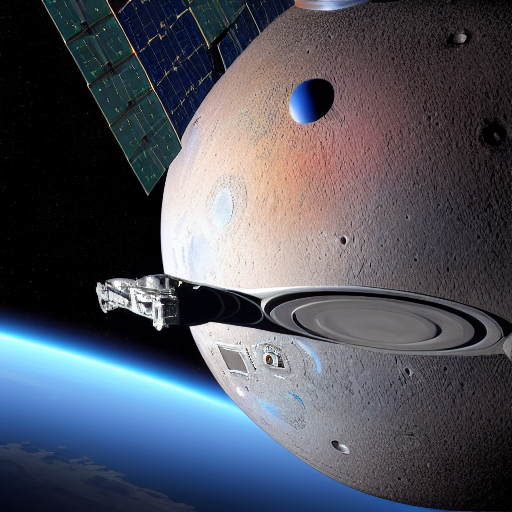

In [ ]:
from PIL import Image
from pathlib import Path
from transformers import CLIPTokenizer
DEVICE = "cpu"

ALLOW_CUDA = False
ALLOW_MPS = False

if torch.cuda.is_available() and ALLOW_CUDA:
    DEVICE = "cuda"
elif (torch.has_mps or torch.backends.mps.is_available()) and ALLOW_MPS:
    DEVICE = "mps"
print(f"Using device: {DEVICE}")


tokenizer = CLIPTokenizer("tokenizer_vocab.json", merges_file="tokenizer_merges.txt")
model_file = "v1-5-pruned-emaonly.ckpt"
models = preload_models_from_standard_weights(model_file, DEVICE)

## TEXT TO IMAGE

# prompt = "A dog with sunglasses, wearing comfy hat, looking at camera, highly detailed, ultra sharp, cinematic, 100mm lens, 8k resolution."
prompt = "spacecraft in the space near the Earth planetS, highly detailed, 8k resolution, very realistic"
uncond_prompt = ""  # Also known as negative prompt
do_cfg = True
cfg_scale = 8  # min: 1, max: 14

## IMAGE TO IMAGE

input_image = None
# Comment to disable image to image
# image_path = "dog.jpg"
# input_image = Image.open(image_path)
# Higher values means more noise will be added to the input image, so the result will further from the input image.
# Lower values means less noise is added to the input image, so output will be closer to the input image.
strength = 0.9

## SAMPLER

sampler = "ddpm"
num_inference_steps = 50
seed = 42

output_image = generate(
    prompt=prompt,
    uncond_prompt=uncond_prompt,
    input_image=input_image,
    strength=strength,
    do_cfg=do_cfg,
    cfg_scale=cfg_scale,
    sampler_name=sampler,
    n_inference_steps=num_inference_steps,
    seed=seed,
    models=models,
    device=DEVICE,
    idle_device="cpu",
    tokenizer=tokenizer,
)

# Combine the input image and the output image into a single image.
Image.fromarray(output_image)